# Multiecho fMRI Pilot Study: Acquisition and Denoising Effects

This Jupyter notebook analyzes a multiecho fMRI pilot dataset to evaluate the effects of acquisition parameters—headcoil type (20 vs. 64 channels), multiband (MB) factors (mb1, mb3, mb6), and multi-echo (ME) settings (me1, me4)—and denoising methods on data quality and functional metrics. It comprises four main sections:

1. **TSNR and Smoothness Analysis**: Assesses TSNR and Smoothness across acquisition types using mixed-effects models and bar plots, integrating Python and R for statistical rigor.
2. **Multiecho Analysis**: Examines a specified metric (e.g., beta) across ROIs, headcoils, and acquisitions, with bar plots and consistent statistical modeling.
3. **Framewsie Displacement and Denoising**: Links framewise displacement (fd_mean) to differences between Tedana and baseline denoising for me4 acquisitions, visualized with scatter plots split by headcoil and combined.
4. **Special Acquisitions**: Summarizes a metric for `sp` subjects across acquisitions, presented as a bar plot with means and errors.

### Objectives
- Quantify how acquisition parameters affect data quality (TSNR, Smoothness) and functional outcomes (e.g., beta values).
- Compare denoising strategies (Tedana vs. baseline) in relation to head motion (FD).
- Provide visual and statistical insights for pilot study optimization.

### Data Sources
- TSNR/Smoothness CSVs and fMRI text files from `~/Documents/GitHub/multiecho-pilot/derivatives/extractions`.
- FD data from a TSV file (`Outlier-info_mriqc-0.16.1.tsv`).

### Outputs
- CSV files with processed data, PNG plots (bar and scatter), and statistical summaries saved in the working directory.

This notebook supports reproducible analysis for understanding multiecho fMRI trade-offs, guiding future acquisition and preprocessing decisions.

Extraction script:
`https://github.com/DVS-Lab/multiecho-pilot/blob/main/code/extract_signal.sh`

# Fig 3. Smoothness Analysis with Mixed-Effects Modeling

This code chunk processes and analyzes Temporal Signal-to-Noise Ratio (TSNR) and Smoothness data from multiecho fMRI acquisitions, evaluating the effects of headcoil type (20 vs. 64 channels), multiband (MB) factor (mb1, mb3, mb6), and multi-echo (ME) settings (me1, me4). It integrates Python for data handling and plotting with R for advanced statistical modeling, ensuring consistency with prior analyses.

### Key Components
1. **Data Loading and Preprocessing**:
   - `load_and_preprocess_data`: 
     - Loads TSNR data from a CSV file (e.g., `tsnr_path`) with columns like `Subject`, `ReceiveCoilName`, `AcquisitionType`, and `tsnrMedian`.
     - Loads Smoothness data from another CSV (e.g., `smoothness_path`), extracting `sub`, `acq`, and `smoothness` from file paths and values.
     - Merges datasets on `sub` and `acq`, excludes subjects with `sp` in IDs, and splits `acq` into `mb` and `me` columns.
     - Converts `coil`, `mb`, and `me` to categorical variables for analysis.

2. **Data Aggregation**:
   - `process_data`: 
     - Groups data by `mb`, `me`, and `coil`, calculating means, standard errors, and subject counts for a specified metric (`tsnrMedian` or `smoothness`).
     - Drops NaNs to ensure robust statistics.

3. **Visualization**:
   - `create_tsnr_smoothness_plots`: 
     - Generates bar plots for each headcoil type, showing metric values across MB factors (mb1, mb3, mb6), with ME settings differentiated by color (blue for me1, orange for me4).
     - Includes error bars (standard errors) and subject counts in titles.

4. **Statistical Analysis**:
   - `run_statistical_analysis`: 
     - Uses R’s `lme4` and `emmeans` via `rpy2` to fit a linear mixed-effects model: `<metric> ~ HC * MB * ME + (1 | Subj)`.
     - Treats `MB` and `ME` as ordered factors (`mb1 < mb3 < mb6`, `me1 < me4`) for linear and quadratic contrasts.
     - Computes pairwise comparisons for `MB` levels, averaged over `HC` and `ME`.
     - Outputs model summaries (random/fixed effects) and pairwise results.

5. **Execution**:
   - `analyze_multiecho_data`: 
     - Orchestrates the full pipeline: preprocessing, aggregation, plotting, and statistical analysis.
     - Returns a dictionary with merged data, plots, and statistical results.

### Inputs
- `tsnr_path`: Path to TSNR CSV file (e.g., `~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv`).
- `smoothness_path`: Path to Smoothness CSV file (e.g., `~/Documents/GitHub/multiecho-pilot/smoothness-all.csv`).

### Outputs
- **Data**: Merged DataFrame with columns `sub`, `coil`, `acq`, `tsnrMedian`, `smoothness`, `mb`, and `me`.
- **Plots**: Bar plots saved as `tsnrMedian_analysis.png` and `smoothness_analysis.png`.
- **Statistical Results**: Dictionary with model summaries and pairwise comparisons for TSNR and Smoothness.

### Notes
- Requires `rpy2` and R packages (`lme4`, `lmerTest`, `emmeans`) for statistical modeling.
- Handles missing data by dropping NaNs before analysis, with diagnostics printed for transparency.
- Plot aesthetics (e.g., font size=48) are standardized for readability.
- Assumes TSNR CSV has specific columns; raises errors if they’re missing.

This chunk provides a reproducible workflow for assessing TSNR and Smoothness across acquisition parameters, leveraging mixed-effects modeling to account for subject variability and interactions.

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro

# Activate automatic conversion between pandas and R dataframes
pandas2ri.activate()

# Import R packages
lme4 = importr('lme4')
lmerTest = importr('lmerTest')
emmeans = importr('emmeans')
base = importr('base')

def load_and_preprocess_data(tsnr_path, smoothness_path):
    """
    Load and preprocess TSNR and smoothness data
    """
    tsnr_path = os.path.expanduser(tsnr_path)
    smoothness_path = os.path.expanduser(smoothness_path)
    
    data = pd.read_csv(tsnr_path)
    print("TSNR Data Columns:", list(data.columns))
    
    column_mapping = {
        'Subject': 'sub',
        'ReceiveCoilName': 'coil',
        'AcquisitionType': 'acq',
        'tsnrMedian': 'tsnrMedian'
    }
    
    missing_cols = [col for col in column_mapping.keys() if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}. Found columns: {list(data.columns)}")
    
    data = data.rename(columns=column_mapping)
    data = data[~data['sub'].str.contains('sp', na=False)]
    print("TSNR Data after preprocessing:")
    print(data.head())
    
    smooth_raw = pd.read_csv(smoothness_path)
    print("Smoothness CSV first few rows:")
    print(smooth_raw.head())
    print("Smoothness CSV columns:", list(smooth_raw.columns))
    
    smooth = pd.DataFrame()
    filepath_col = smooth_raw.columns[0]
    
    smooth['filepath'] = smooth_raw[filepath_col].where(
        smooth_raw[filepath_col].str.contains('sub-', na=False),
        pd.NA
    )
    smooth['filepath'] = smooth['filepath'].ffill()
    smooth['smoothness'] = pd.to_numeric(smooth_raw['Unnamed: 3'], errors='coerce')
    smooth = smooth.dropna(subset=['smoothness'])
    
    smooth['sub'] = smooth['filepath'].str.extract(r'sub-(\d+)')
    smooth['acq'] = smooth['filepath'].str.extract(r'acq-(mb\d+me\d+)')
    smooth = smooth[~smooth['sub'].str.contains('sp', na=False)]
    smooth = smooth[['sub', 'acq', 'smoothness']]
    print("Smoothness Data after preprocessing:")
    print(smooth.head())
    print("Smoothness Data shape:", smooth.shape)
    
    data_merged = pd.merge(data, smooth, on=['sub', 'acq'], how='left')
    data_merged['mb'] = data_merged['acq'].str.extract(r'(mb\d+)')[0]
    data_merged['me'] = data_merged['acq'].str.extract(r'(me\d+)')[0]
    
    categorical_cols = ['coil', 'mb', 'me']
    for col in categorical_cols:
        data_merged[col] = pd.Categorical(data_merged[col])
    
    print("Merged Data Columns:", list(data_merged.columns))
    print("Merged Data Head:")
    print(data_merged.head())
    
    return data_merged

def process_data(data, value_column):
    """
    Calculate mean and standard error by multiband, multi-echo, and coil
    """
    data = data.dropna(subset=['mb', 'me', 'coil', value_column])
    
    print(f"Data after dropna for {value_column}:")
    print(data.head())
    print(f"Number of rows: {len(data)}")
    
    agg_data = data.groupby(['mb', 'me', 'coil'], observed=True).agg({
        value_column: 'mean',
        'sub': 'nunique'
    }).reset_index()
    
    std_error = data.groupby(['mb', 'me', 'coil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index()
    std_error.columns = ['mb', 'me', 'coil', 'se']
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'coil'])
    result.columns = ['mb', 'me', 'coil', value_column, 'n_subjects', 'se']
    
    print(f"Processed Data for {value_column}:")
    print(result.head())
    print(f"Processed Data Info:")
    print(result.info())
    
    return result

def create_tsnr_smoothness_plots(data_processed, img_type='tsnr', save_files=True):
    """
    Create plots similar to the original Python kernel's bar plots
    """
    plt.rcParams.update({'font.size': 48})
    coil_types = data_processed['coil'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    if len(coil_types) == 1:
        axes = [axes]
    
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [x + width for x in x1]
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    mb_levels = ['mb1', 'mb3', 'mb6']
    
    all_y_values = []
    all_y_errors = []
    
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['coil'] == coil]
        if coil_data.empty:
            print(f"No data for coil {coil}")
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')
            continue
        
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
        
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        if i == 0:
            ax.set_ylabel(img_type.upper(), fontsize=48)
        
        n_subjects = int(coil_data['n_subjects'].iloc[0]) if not coil_data['n_subjects'].empty else 0
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        y_max = max([v + e for v, e in zip(y_values, y_errors) if v != 0], default=0)
        margin = y_max * 0.1
        ax.set_ylim(0, y_max + margin)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    
    if save_files:
        plt.savefig(f'{img_type}_analysis.png', dpi=300, bbox_inches='tight')
    
    return fig

def run_statistical_analysis(data):
    """
    Perform statistical analysis using R's lme4 and emmeans
    """
    # Prepare data for R: rename columns to match R script and drop NaN
    data_r = data.rename(columns={'sub': 'Subj', 'coil': 'HC', 'mb': 'MB', 'me': 'ME', 
                                  'tsnrMedian': 'TSNR', 'smoothness': 'Smoothness'})
    data_r = data_r.dropna(subset=['TSNR', 'Smoothness', 'MB', 'ME', 'HC', 'Subj'])
    
    # Convert categorical columns to strings to avoid RPy2 conversion issues
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    # Convert to R dataframe
    r_df = pandas2ri.py2rpy(data_r)
    
    results = {}
    for metric in ['TSNR', 'Smoothness']:
        # Define the formula for the mixed-effects model
        formula = Formula(f'{metric} ~ HC * MB * ME + (1 | Subj)')
        
        # Fit the model using lmer
        model = lme4.lmer(formula, data=r_df)
        
        # Get the model summary (commented out as per user request)
        # summary = base.summary(model)
        # print(f"\nLinear Mixed Effects Model for {metric}:")
        # print(summary)
        
        # Pairwise comparisons using emmeans with interactions
        emm = emmeans.emmeans(model, ~ 'HC * MB * ME')
        pairwise = ro.r('pairs')(emm)  # Explicitly call R's pairs() function
        print(f"\nPairwise comparisons for HC * MB * ME in {metric}:")
        print(pairwise)
        
        results[metric] = {
            'pairwise_HC_MB_ME': str(pairwise)
        }
    
    return results

def analyze_multiecho_data(tsnr_path, smoothness_path):
    """
    Main function to perform complete analysis
    """
    data_merged = load_and_preprocess_data(tsnr_path, smoothness_path)
    tsnr_processed = process_data(data_merged, 'tsnrMedian')
    smoothness_processed = process_data(data_merged, 'smoothness')
    
    tsnr_plot = create_tsnr_smoothness_plots(tsnr_processed, 'tsnrMedian')
    smoothness_plot = create_tsnr_smoothness_plots(smoothness_processed, 'smoothness')
    
    statistical_results = run_statistical_analysis(data_merged)
    
    return {
        'data': data_merged,
        'tsnr_plot': tsnr_plot,
        'smoothness_plot': smoothness_plot,
        'statistical_results': statistical_results
    }

results = analyze_multiecho_data(
    '~/Documents/GitHub/multiecho-pilot/smoothness-all-zero.csv', 
    '~/Documents/GitHub/multiecho-pilot/smoothness-all.csv' # use smoothness-all-zero.csv for pre-5mm smoothed data (panel A)
)

TSNR Data Columns: ['sub-10015/L1_task-sharedreward_model-1_type-act_acq-mb1me1_sm-5_denoising-base_EstimateSmoothing.feat/smoothness-0mm.txt', 'acq', 'val', 'Unnamed: 3']


ValueError: Missing required columns: ['Subject', 'ReceiveCoilName', 'AcquisitionType', 'tsnrMedian']. Found columns: ['sub-10015/L1_task-sharedreward_model-1_type-act_acq-mb1me1_sm-5_denoising-base_EstimateSmoothing.feat/smoothness-0mm.txt', 'acq', 'val', 'Unnamed: 3']


# Fig 4. Analysis of TSNR in Multiband Multi-Echo fMRI

*"Description of Python Pipeline"author: "Grok 3, xAI"date: "April 30, 2025"output:  html_document:    toc: truetoc_float: true*

This document describes a Python-based analysis pipeline (tsnr_analysis.py) designed to evaluate the effects of head coil type (HC), multiband factor (MB), and multi-echo acquisition (ME) on temporal signal-to-noise ratio (TSNR) in functional MRI (fMRI) data. The pipeline processes TSNR data, generates visualizations, and performs statistical analysis using a linear mixed effects model. The analysis was conducted using Python with the rpy2 library to interface with R for statistical modeling.
Purpose of the Pipeline
The tsnr_analysis.py script performs the following tasks:

### Data Preprocessing:

- Loads a CSV file containing TSNR data with columns for subject ID, head coil type (20-channel or 64-channel), acquisition type (e.g., mb1me1 for MB1 ME1), and median TSNR.
- Extracts multiband (MB) and multi-echo (ME) factors from the acquisition type and filters out rows with missing data.


### Visualization:

- Creates bar plots showing median TSNR across MB levels (MB1, MB3, MB6) for each ME level (ME1, ME4) and HC type (20-channel, 64-channel), with error bars representing standard errors.
- Generates line plots of estimated marginal means (EMMs) from the statistical model, illustrating the interaction effects across MB, ME, and HC.


### Statistical Analysis:

- Fits a linear mixed effects model with the formula TSNR ~ HC * MB * ME + (1 | Subj), where Subj is a random intercept to account for inter-subject variability.
- Computes pairwise comparisons using estimated marginal means to explore significant differences between all combinations of HC, MB, and ME.



### Key Dependencies
The Python script relies on the following libraries:

- `pandas` and numpy for data manipulation.
- `matplotlib` for plotting.
- `rpy2` to interface with R, using R packages lme4, lmerTest, and emmeans for statistical analysis.



### Usage
To use the Python pipeline:

- Ensure the required Python libraries and R packages are installed.
- Prepare a CSV file with columns Subject, ReceiveCoilName, AcquisitionType, and tsnrMedian.
- Run the script with the path to the CSV file as input: results = analyze_tsnr_data('path/to/data.csv').

The script will generate bar plots, EMM line plots, and statistical output as shown above.



Linear Mixed Effects Model Summary (TSNR ~ HC * MB * ME + (1 | Subj)):

Linear mixed model fit by REML ['lmerMod']
Formula: TSNR ~ HC * MB * ME + (1 | Subj)
REML criterion at convergence: 1439

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4021 -0.5013  0.0417  0.5136  3.1572 

Random effects:
 Groups   Name        Variance Std.Dev.
 Subj     (Intercept) 19.945   4.466   
 Residual              8.161   2.857   
Number of obs: 271, groups:  Subj, 48

Fixed effects:
                 Estimate Std. Error t value
(Intercept)       30.3638     1.1513  26.373
HC64               4.8028     1.5513   3.096
MBmb3             -2.1125     0.8888  -2.377
MBmb6             -5.0528     0.8888  -5.685
MEme4              7.0714     0.9245   7.649
HC64:MBmb3         1.8865     1.1971   1.576
HC64:MBmb6         4.3246     1.1971   3.612
HC64:MEme4         0.3132     1.2242   0.256
MBmb3:MEme4       -3.0683     1.2949  -2.370
MBmb6:MEme4      -11.5790     1.2841  -9.017
HC64:MBmb3:MEme4  

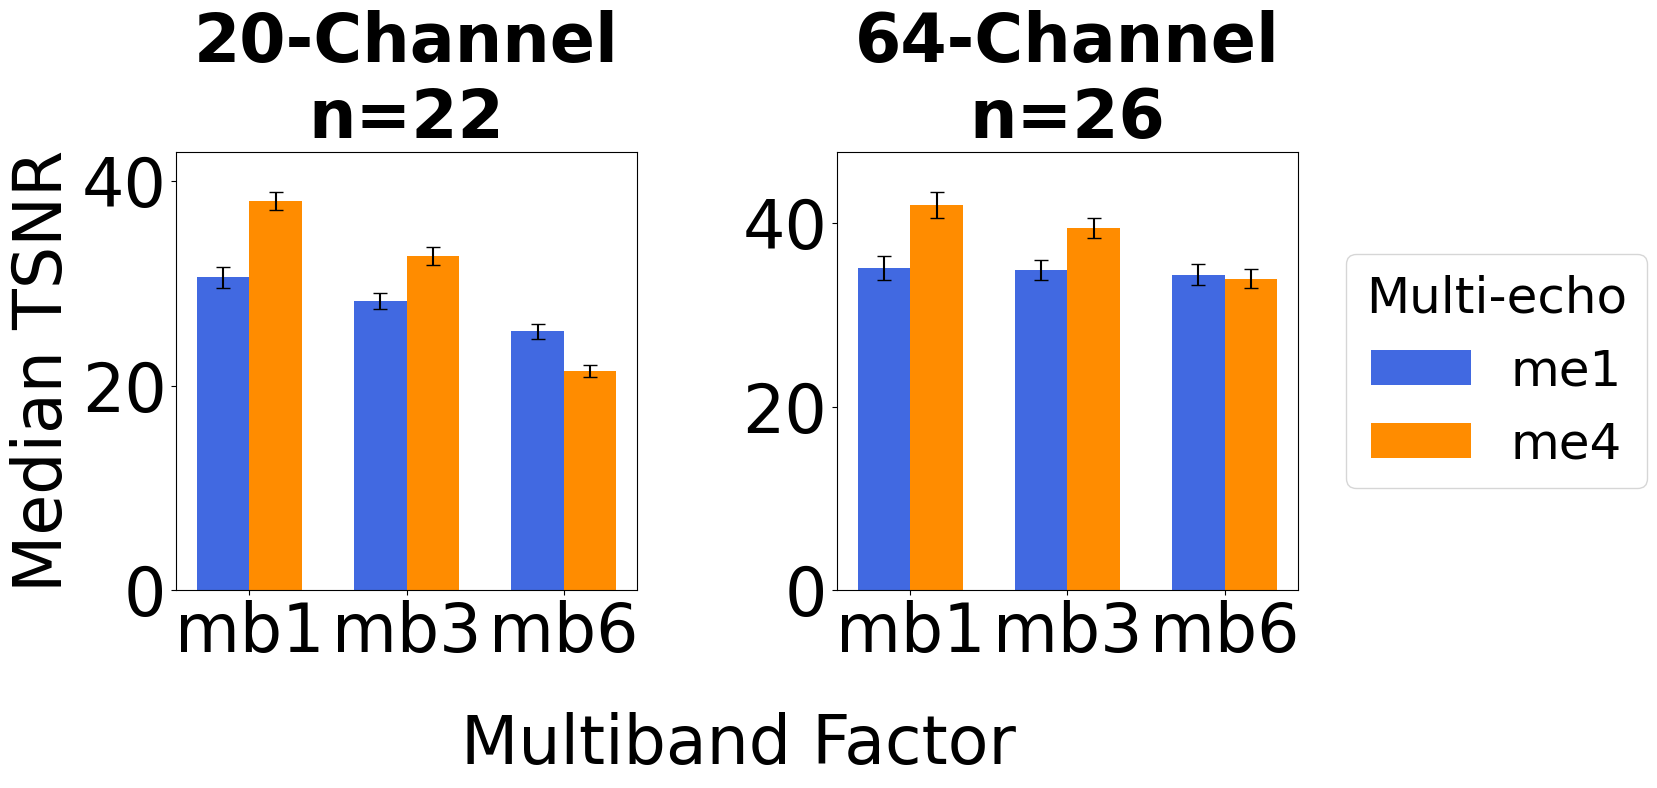

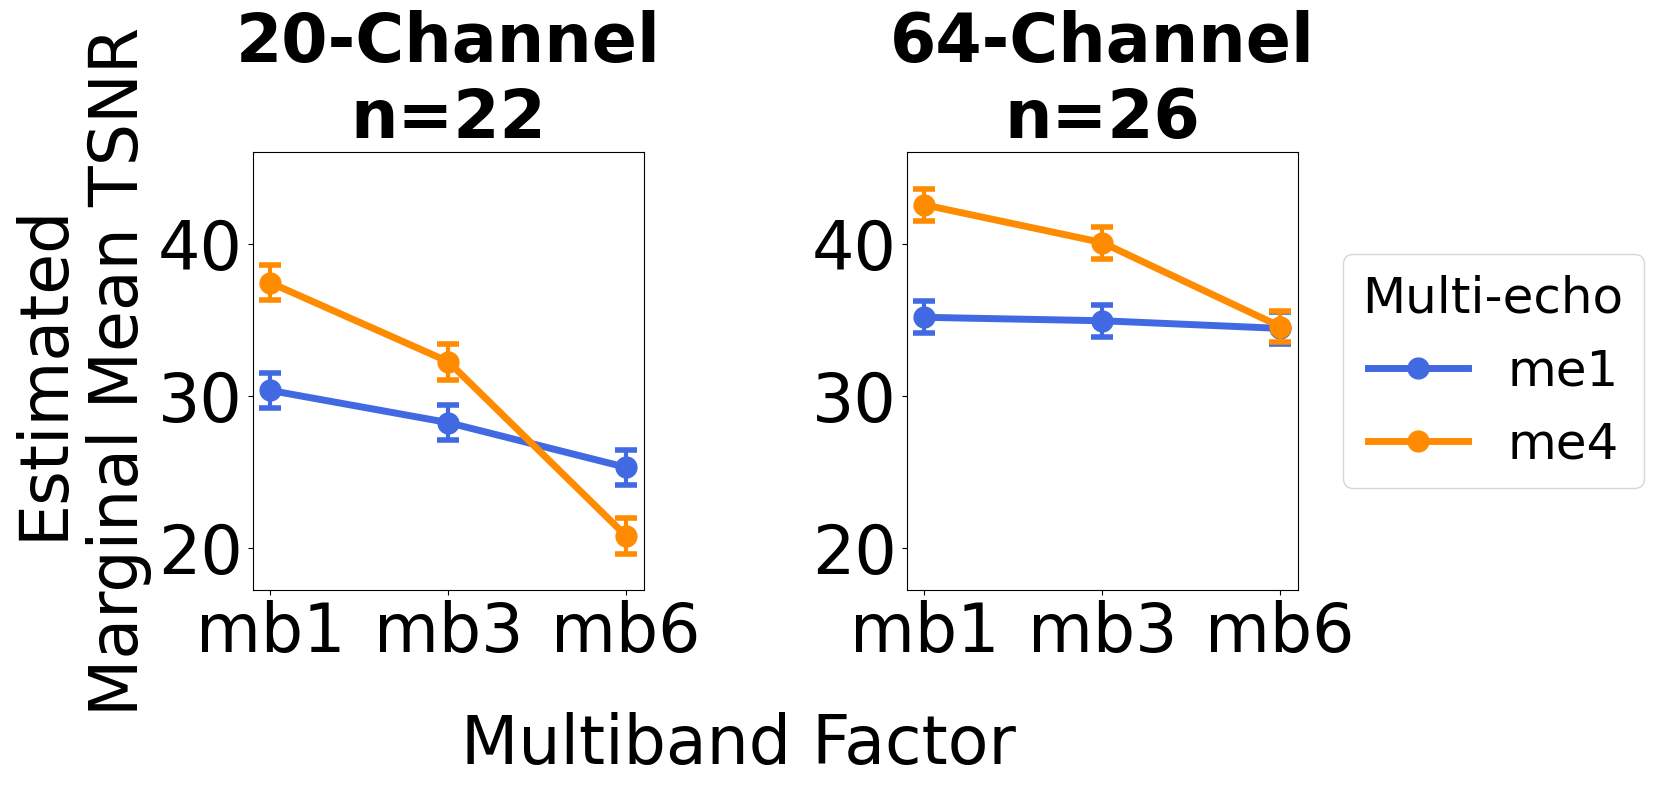

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro

# Activate automatic conversion between pandas and R dataframes
pandas2ri.activate()

# Import R packages
lme4 = importr('lme4')
lmerTest = importr('lmerTest')
emmeans = importr('emmeans')
base = importr('base')

def load_and_preprocess_data(tsnr_path):
    """
    Load and preprocess TSNR data
    """
    tsnr_path = os.path.expanduser(tsnr_path)
    
    data = pd.read_csv(tsnr_path)
    
    column_mapping = {
        'Subject': 'sub',
        'ReceiveCoilName': 'coil',
        'AcquisitionType': 'acq',
        'tsnrMedian': 'tsnrMedian'
    }
    
    missing_cols = [col for col in column_mapping.keys() if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}. Found columns: {list(data.columns)}")
    
    data = data.rename(columns=column_mapping)
    data = data[~data['sub'].str.contains('sp', na=False)]
    
    data['mb'] = data['acq'].str.extract(r'(mb\d+)')[0]
    data['me'] = data['acq'].str.extract(r'(me\d+)')[0]
    
    categorical_cols = ['coil', 'mb', 'me']
    for col in categorical_cols:
        data[col] = pd.Categorical(data[col])
    
    # Compute n_subjects_per_coil after initial preprocessing
    data_clean = data.dropna(subset=['mb', 'me', 'coil', 'tsnrMedian'])
    n_subjects_per_coil = data_clean.groupby('coil', observed=True)['sub'].nunique().to_dict()
    
    return data, n_subjects_per_coil

def process_data(data, value_column):
    """
    Calculate mean and standard error by multiband, multi-echo, and coil
    """
    data = data.dropna(subset=['mb', 'me', 'coil', value_column])
    
    agg_data = data.groupby(['mb', 'me', 'coil'], observed=True).agg({
        value_column: 'mean',
        'sub': 'nunique'
    }).reset_index()
    
    std_error = data.groupby(['mb', 'me', 'coil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index()
    std_error.columns = ['mb', 'me', 'coil', 'se']
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'coil'])
    result.columns = ['mb', 'me', 'coil', value_column, 'n_subjects', 'se']
    
    return result

def create_tsnr_bar_plots(data_processed, n_subjects_per_coil, img_type='tsnrMedian', save_files=True):
    """
    Create bar plots for TSNR
    """
    plt.rcParams.update({'font.size': 48})
    coil_types = data_processed['coil'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    if len(coil_types) == 1:
        axes = [axes]
    
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [x + width for x in x1]
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    mb_levels = ['mb1', 'mb3', 'mb6']
    
    all_y_values = []
    all_y_errors = []
    
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['coil'] == coil]
        if coil_data.empty:
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')
            continue
        
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
        
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        if i == 0:
            ax.set_ylabel('Median TSNR', fontsize=48)
        
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        y_max = max([v + e for v, e in zip(y_values, y_errors) if v != 0], default=0)
        margin = y_max * 0.1
        ax.set_ylim(0, y_max + margin)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    
    if save_files:
        plt.savefig('tsnr_bar_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

def create_emm_line_plots(data, n_subjects_per_coil):
    """
    Create line plots for estimated marginal means of TSNR with consistent y-axis across subplots
    """
    # Prepare data for R
    data_r = data.rename(columns={'sub': 'Subj', 'coil': 'HC', 'mb': 'MB', 'me': 'ME', 
                                  'tsnrMedian': 'TSNR'})
    data_r = data_r.dropna(subset=['TSNR', 'MB', 'ME', 'HC', 'Subj'])
    
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    r_df = pandas2ri.py2rpy(data_r)
    
    # Ensure MB and ME are factors with correct levels in R
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    ''')
    r_df = ro.r('''
    transform({}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC))
    '''.format(r_df.r_repr()))
    
    # Fit the model
    formula = Formula('TSNR ~ HC * MB * ME + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Compute EMMs
    emm = emmeans.emmeans(model, 'MB', by=ro.StrVector(['HC', 'ME']))
    emm_r_df = ro.r('as.data.frame')(emm)
    emm_df = pandas2ri.rpy2py(emm_r_df)
    
    # Map numeric indices to string labels
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    hc_levels = sorted(data['coil'].unique())
    hc_map = {i + 1: hc for i, hc in enumerate(hc_levels)}
    
    emm_df['MB'] = emm_df['MB'].map(mb_map)
    emm_df['ME'] = emm_df['ME'].map(me_map)
    emm_df['HC'] = emm_df['HC'].map(hc_map)
    
    # Plotting
    plt.rcParams.update({'font.size': 48})
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    coil_types = emm_df['HC'].unique()
    
    # Collect all y-values and errors to determine consistent y-axis limits
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = emm_df[emm_df['HC'] == coil]
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            if not me_data.empty:
                y_values = me_data['emmean'].values
                y_errors = me_data['SE'].values
                all_y_values.extend(y_values)
                all_y_errors.extend(y_errors)
    
    # Calculate global y-axis limits
    if all_y_values:  # Ensure there are values to process
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1  # Add 10% margin
        y_limits = (max(0, y_min - margin), y_max + margin)  # Ensure y_min is not negative
    else:
        y_limits = (0, 1)  # Default in case of no data
    
    # Plot each subplot with consistent y-axis
    for i, coil in enumerate(coil_types):
        ax = axes[i]
        coil_data = emm_df[emm_df['HC'] == coil]
        
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            me_data = me_data.sort_values('MB', key=lambda x: x.str.extract(r'mb(\d+)')[0].astype(int))
            ax.plot(me_data['MB'], me_data['emmean'], marker='o', color=me_colors[me], label=me, linewidth=5, markersize=15)
            ax.errorbar(me_data['MB'], me_data['emmean'], yerr=me_data['SE'], fmt='none', color=me_colors[me], capsize=8, capthick=4, elinewidth=3)
        
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        if i == 0:
            ax.set_ylabel('Estimated\nMarginal Mean TSNR', fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        ax.set_ylim(y_limits)  # Apply consistent y-axis limits
    
    axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                    loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    plt.savefig('tsnr_emm_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

def run_statistical_analysis(data):
    """
    Perform statistical analysis for TSNR using R's lme4 and emmeans
    """
    data_r = data.rename(columns={'sub': 'Subj', 'coil': 'HC', 'mb': 'MB', 'me': 'ME', 
                                  'tsnrMedian': 'TSNR'})
    data_r = data_r.dropna(subset=['TSNR', 'MB', 'ME', 'HC', 'Subj'])
    
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    r_df = pandas2ri.py2rpy(data_r)
    
    # Ensure MB and ME are factors with correct levels in R
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    ''')
    r_df = ro.r('''
    transform({}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC))
    '''.format(r_df.r_repr()))
    
    formula = Formula('TSNR ~ HC * MB * ME + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Get the model summary and suppress the Data section
    model_summary = ro.r('summary')(model)
    summary_lines = ro.r('capture.output')(model_summary)
    # Find the index of the "Data:" line and the next section
    summary_lines_list = list(summary_lines)
    data_start = None
    data_end = None
    for i, line in enumerate(summary_lines_list):
        if line.startswith('   Data:'):
            data_start = i
        elif data_start is not None and line.startswith('REML criterion at convergence:'):
            data_end = i
            break
    if data_start is not None and data_end is not None:
        summary_lines_list = summary_lines_list[:data_start] + summary_lines_list[data_end:]
    model_summary_str = '\n'.join(summary_lines_list)
    print("\nLinear Mixed Effects Model Summary (TSNR ~ HC * MB * ME + (1 | Subj)):\n")
    print(model_summary_str)
    
    # Compute pairwise comparisons
    emm = emmeans.emmeans(model, ro.StrVector(['HC', 'MB', 'ME']))
    pairwise = ro.r('pairs')(emm)
    
    # Convert pairwise to DataFrame
    pairwise_r_df = ro.r('as.data.frame')(pairwise)
    pairwise_df = pandas2ri.rpy2py(pairwise_r_df)
    
    # Debug: Inspect the DataFrame
    print("Pairwise DataFrame columns:", pairwise_df.columns.tolist())
    print("Pairwise DataFrame head:\n", pairwise_df.head())
    
    # Map numeric indices in the contrast column to string labels
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    hc_levels = sorted(data['coil'].unique())
    hc_map = {i + 1: hc for i, hc in enumerate(hc_levels)}
    
    # Replace numeric indices in the contrast column
    def map_contrast(contrast):
        for num, label in mb_map.items():
            contrast = contrast.replace(f'MB{num}', f'MB{label}')
        for num, label in me_map.items():
            contrast = contrast.replace(f'ME{num}', f'ME{label}')
        for num, label in hc_map.items():
            contrast = contrast.replace(f'HC{num}', f'HC{label}')
        return contrast
    
    pairwise_df['contrast'] = pairwise_df['contrast'].apply(map_contrast)
    
    print("\nPairwise comparisons for HC * MB * ME in TSNR:")
    print(pairwise_df)
    
    return {
        'model_summary': model_summary_str,
        'pairwise_HC_MB_ME': pairwise_df.to_string()
    }

def analyze_tsnr_data(tsnr_path):
    """
    Main function to perform TSNR analysis
    """
    data, n_subjects_per_coil = load_and_preprocess_data(tsnr_path)
    tsnr_processed = process_data(data, 'tsnrMedian')
    
    bar_plot = create_tsnr_bar_plots(tsnr_processed, n_subjects_per_coil, 'tsnrMedian')
    emm_plot = create_emm_line_plots(data, n_subjects_per_coil)
    statistical_results = run_statistical_analysis(data)
    
    return {
        'data': data,
        'bar_plot': bar_plot,
        'emm_plot': emm_plot,
        'statistical_results': statistical_results
    }

# Run the analysis
results = analyze_tsnr_data('~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv')

lme4 version: [1]  1  1 37

lmerTest version: [1] 3 1 3



R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In anova.merMod(new("lmerMod", resp = new("lmerResp", .xData = <environment>),  :
R[write to console]: 
 
R[write to console]:  additional arguments ignored: ‘ddf’

R[write to console]: Error in contestMD.lmerModLmerTest(model, l, ddf = ddf, rhs = rhs, ...) : 
  ncol(L) == length(model@beta) is not TRUE

R[write to console]: Error in contestMD.lmerModLmerTest(model, l, ddf = ddf, rhs = rhs, ...) : 
  ncol(L) == length(model@beta) is not TRUE

R[write to console]: Error in contestMD.lmerModLmerTest(model, l, ddf = ddf, rhs = rhs, ...) : 
  ncol(L) == length(model@beta) is not TRUE



Data summary:
HC  MB   ME 
20  mb1  me1    20
         me4    19
    mb3  me1    22
         me4    18
    mb6  me1    22
         me4    19
64  mb1  me1    26
         me4    25
    mb3  me1    25
         me4    25
    mb6  me1    25
         me4    25
Name: Subj, dtype: int64
MB contrasts:
[[ 1.  0.]
 [ 0.  1.]
 [-1. -1.]]
ME contrasts:
[[ 1.]
 [-1.]]
HC contrasts:
[[ 1.]
 [-1.]]
Model summary:
["Linear mixed model fit by REML ['lmerMod']"
 'Formula: TSNR ~ HC * MB * ME + (1 | Subj)'
 '   Data: structure(list(Subj = c("10015", "10015", "10015", "10017", "10017",  '
 '"10017", "10017", "10017", "10017", "10024", "10024", "10024",  '
 '"10024", "10024", "10024", "10028", "10028", "10028", "10028",  '
 '"10035", "10035", "10035", "10035", "10035", "10035", "10041",  '
 '"10041", "10041", "10041", "10041", "10041", "10043", "10043",  '
 '"10043", "10043", "10043", "10043", "10054", "10054", "10054",  '
 '"10054", "10054", "10054", "10059", "10059", "10059", "10059",  '
 '"10059", "10059

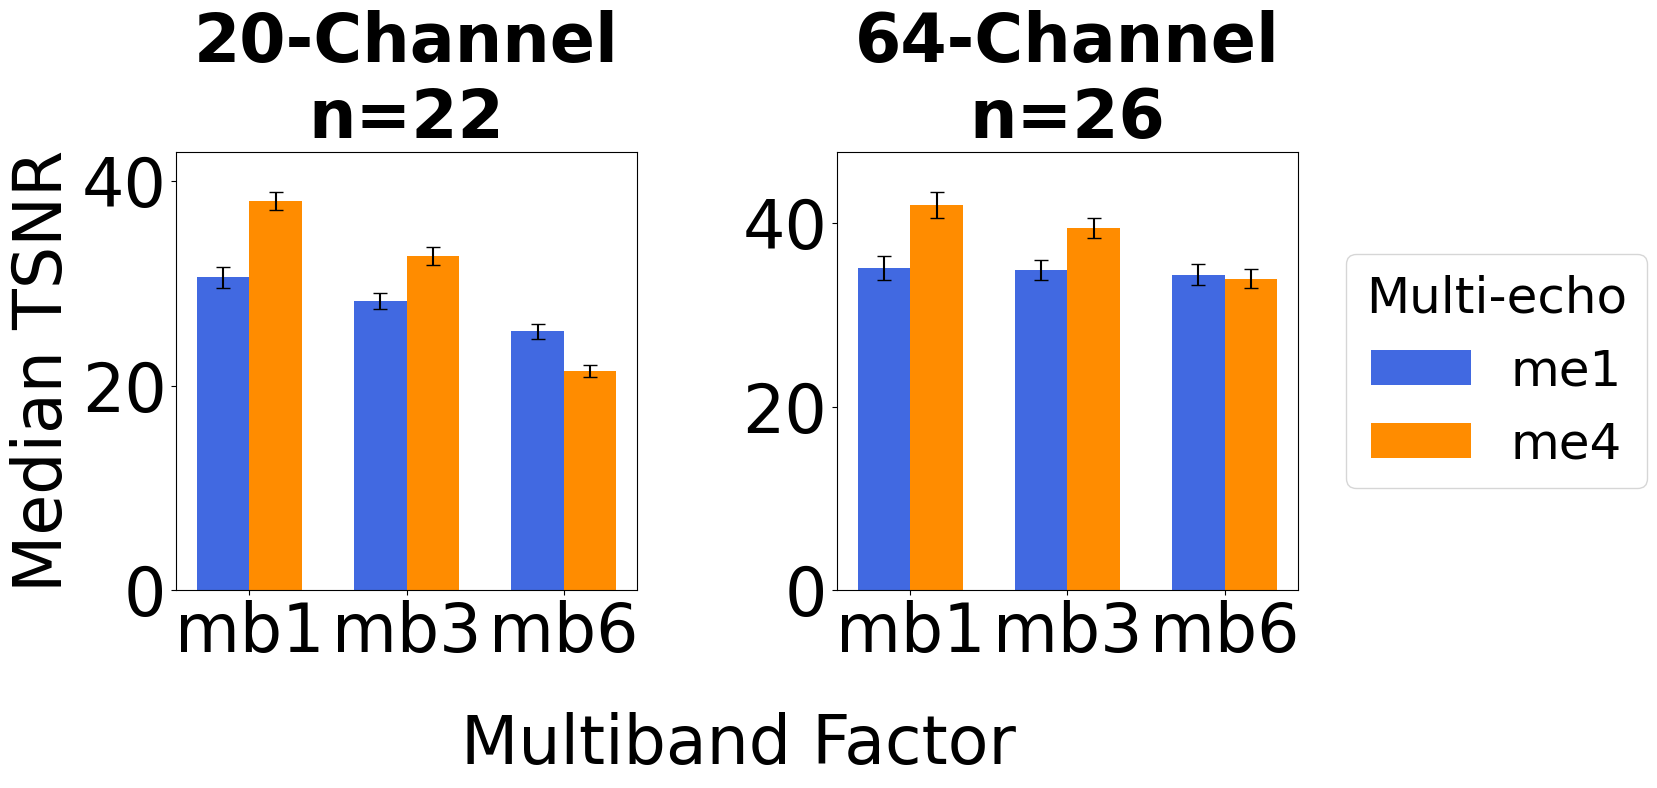

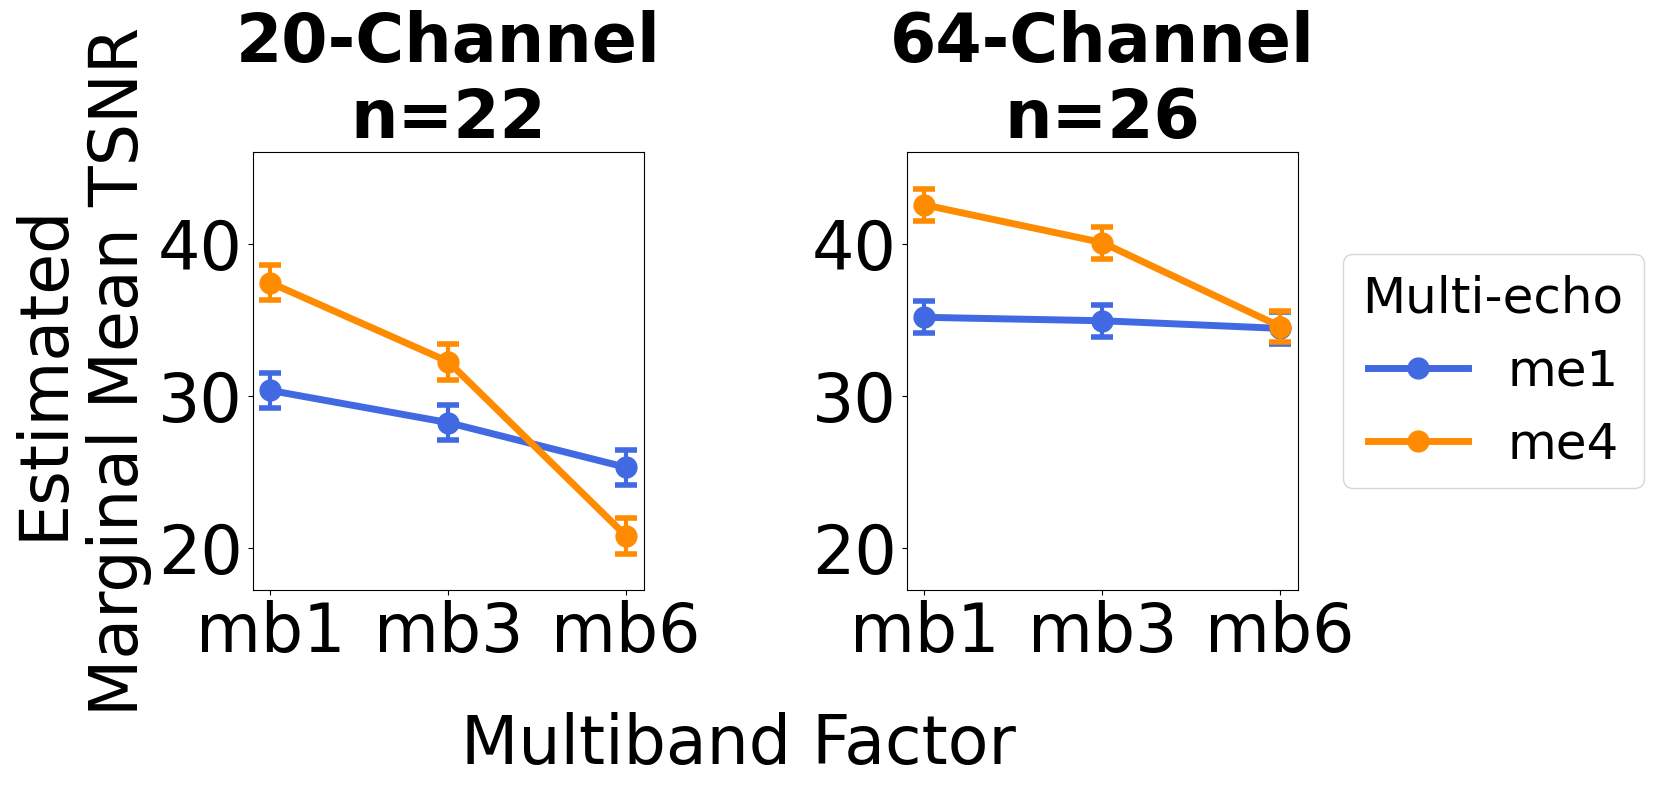

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro

# Activate automatic conversion between pandas and R dataframes
pandas2ri.activate()

# Import R packages
lme4 = importr('lme4')
lmerTest = importr('lmerTest')
emmeans = importr('emmeans')
base = importr('base')
stats = importr('stats')

# Check lme4 and lmerTest versions
print("lme4 version:", ro.r('packageVersion("lme4")')[0])
print("lmerTest version:", ro.r('packageVersion("lmerTest")')[0])

def load_and_preprocess_data(tsnr_path):
    """
    Load and preprocess TSNR data
    """
    tsnr_path = os.path.expanduser(tsnr_path)
    
    data = pd.read_csv(tsnr_path)
    
    column_mapping = {
        'Subject': 'sub',
        'ReceiveCoilName': 'coil',
        'AcquisitionType': 'acq',
        'tsnrMedian': 'tsnrMedian'
    }
    
    missing_cols = [col for col in column_mapping.keys() if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}. Found columns: {list(data.columns)}")
    
    data = data.rename(columns=column_mapping)
    data = data[~data['sub'].str.contains('sp', na=False)]
    
    data['mb'] = data['acq'].str.extract(r'(mb\d+)')[0]
    data['me'] = data['acq'].str.extract(r'(me\d+)')[0]
    
    categorical_cols = ['coil', 'mb', 'me']
    for col in categorical_cols:
        data[col] = pd.Categorical(data[col])
    
    # Compute n_subjects_per_coil after initial preprocessing
    data_clean = data.dropna(subset=['mb', 'me', 'coil', 'tsnrMedian'])
    n_subjects_per_coil = data_clean.groupby('coil', observed=True)['sub'].nunique().to_dict()
    
    return data, n_subjects_per_coil

def process_data(data, value_column):
    """
    Calculate mean and standard error by multiband, multi-echo, and coil
    """
    data = data.dropna(subset=['mb', 'me', 'coil', value_column])
    
    agg_data = data.groupby(['mb', 'me', 'coil'], observed=True).agg({
        value_column: 'mean',
        'sub': 'nunique'
    }).reset_index()
    
    std_error = data.groupby(['mb', 'me', 'coil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index()
    std_error.columns = ['mb', 'me', 'coil', 'se']
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'coil'])
    result.columns = ['mb', 'me', 'coil', value_column, 'n_subjects', 'se']
    
    return result

def create_tsnr_bar_plots(data_processed, n_subjects_per_coil, img_type='tsnrMedian', save_files=True):
    """
    Create bar plots for TSNR
    """
    plt.rcParams.update({'font.size': 48})
    coil_types = data_processed['coil'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    if len(coil_types) == 1:
        axes = [axes]
    
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [x + width for x in x1]
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    mb_levels = ['mb1', 'mb3', 'mb6']
    
    all_y_values = []
    all_y_errors = []
    
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['coil'] == coil]
        if coil_data.empty:
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')
            continue
        
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
        
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        if i == 0:
            ax.set_ylabel('Median TSNR', fontsize=48)
        
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        y_max = max([v + e for v, e in zip(y_values, y_errors) if v != 0], default=0)
        margin = y_max * 0.1
        ax.set_ylim(0, y_max + margin)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    
    if save_files:
        plt.savefig('tsnr_bar_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

def create_emm_line_plots(data, n_subjects_per_coil):
    """
    Create line plots for estimated marginal means of TSNR with consistent y-axis across subplots
    """
    # Prepare data for R
    data_r = data.rename(columns={'sub': 'Subj', 'coil': 'HC', 'mb': 'MB', 'me': 'ME', 
                                  'tsnrMedian': 'TSNR'})
    data_r = data_r.dropna(subset=['TSNR', 'MB', 'ME', 'HC', 'Subj'])
    
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    r_df = pandas2ri.py2rpy(data_r)
    
    # Ensure MB and ME are factors with correct levels in R
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    ''')
    r_df = ro.r('''
    transform({}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC))
    '''.format(r_df.r_repr()))
    
    # Fit the model
    formula = Formula('TSNR ~ HC * MB * ME + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Compute EMMs
    emm = emmeans.emmeans(model, 'MB', by=ro.StrVector(['HC', 'ME']))
    emm_r_df = ro.r('as.data.frame')(emm)
    emm_df = pandas2ri.rpy2py(emm_r_df)
    
    # Map numeric indices to string labels
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    hc_levels = sorted(data['coil'].unique())
    hc_map = {i + 1: hc for i, hc in enumerate(hc_levels)}
    
    emm_df['MB'] = emm_df['MB'].map(mb_map)
    emm_df['ME'] = emm_df['ME'].map(me_map)
    emm_df['HC'] = emm_df['HC'].map(hc_map)
    
    # Plotting
    plt.rcParams.update({'font.size': 48})
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    coil_types = emm_df['HC'].unique()
    
    # Collect all y-values and errors to determine consistent y-axis limits
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = emm_df[emm_df['HC'] == coil]
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            if not me_data.empty:
                y_values = me_data['emmean'].values
                y_errors = me_data['SE'].values
                all_y_values.extend(y_values)
                all_y_errors.extend(y_errors)
    
    # Calculate global y-axis limits
    if all_y_values:  # Ensure there are values to process
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1  # Add 10% margin
        y_limits = (max(0, y_min - margin), y_max + margin)  # Ensure y_min is not negative
    else:
        y_limits = (0, 1)  # Default in case of no data
    
    # Plot each subplot with consistent y-axis
    for i, coil in enumerate(coil_types):
        ax = axes[i]
        coil_data = emm_df[emm_df['HC'] == coil]
        
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            me_data = me_data.sort_values('MB', key=lambda x: x.str.extract(r'mb(\d+)')[0].astype(int))
            ax.plot(me_data['MB'], me_data['emmean'], marker='o', color=me_colors[me], label=me, linewidth=5, markersize=15)
            ax.errorbar(me_data['MB'], me_data['emmean'], yerr=me_data['SE'], fmt='none', color=me_colors[me], capsize=8, capthick=4, elinewidth=3)
        
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        if i == 0:
            ax.set_ylabel('Estimated\nMarginal Mean TSNR', fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        ax.set_ylim(y_limits)  # Apply consistent y-axis limits
    
    axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                    loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    plt.savefig('tsnr_emm_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

def run_statistical_analysis(data):
    """
    Perform statistical analysis for TSNR using R's lme4 and lmerTest, reporting APA-style results
    """
    # Prepare data for R
    data_r = data.rename(columns={'sub': 'Subj', 'coil': 'HC', 'mb': 'MB', 'me': 'ME', 
                                  'tsnrMedian': 'TSNR'})
    data_r = data_r.dropna(subset=['TSNR', 'MB', 'ME', 'HC', 'Subj'])
    
    print("Data summary:")
    print(data_r.groupby(['HC', 'MB', 'ME'], observed=True)['Subj'].nunique())
    
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    r_df = pandas2ri.py2rpy(data_r)
    
    # Assign data frame to R global environment and set factors
    ro.globalenv['data_r'] = r_df
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    data_r$MB <- factor(data_r$MB, levels = levels_MB)
    data_r$ME <- factor(data_r$ME, levels = levels_ME)
    data_r$HC <- factor(data_r$HC)
    contrasts(data_r$MB) <- contr.sum(levels_MB)
    contrasts(data_r$ME) <- contr.sum(levels_ME)
    contrasts(data_r$HC) <- contr.sum(levels(data_r$HC))
    ''')
    
    # Verify contrasts
    print("MB contrasts:")
    print(ro.r('contrasts(data_r$MB)'))
    print("ME contrasts:")
    print(ro.r('contrasts(data_r$ME)'))
    print("HC contrasts:")
    print(ro.r('contrasts(data_r$HC)'))
    
    # Fit the LME model
    formula = Formula('TSNR ~ HC * MB * ME + (1 | Subj)')
    model = lme4.lmer(formula, data=ro.r('data_r'))
    
    # Extract model summary
    model_summary = ro.r('summary')(model)
    print("Model summary:")
    print(ro.r('capture.output')(model_summary))
    
    # Try ANOVA table with Satterthwaite approximation
    try:
        anova_table = ro.r('anova')(model, ddf="Satterthwaite")
        anova_df = pandas2ri.rpy2py(ro.r('as.data.frame')(anova_table))
        print("ANOVA table columns:", anova_df.columns.tolist())
    except Exception as e:
        print("Error in ANOVA table extraction:", str(e))
        anova_df = None
    
    # Manually define numerator degrees of freedom
    df_dict = {
        'Head Coil': 1,  # HC: 2 levels - 1
        'Multiband': 2,  # MB: 3 levels - 1
        'Multi-echo': 1,  # ME: 2 levels - 1
        'Head Coil × Multiband': 2,  # 1 * 2
        'Head Coil × Multi-echo': 1,  # 1 * 1
        'Multiband × Multi-echo': 2,  # 2 * 1
        'Head Coil × Multiband × Multi-echo': 2  # 1 * 2 * 1
    }
    
    # Approximate denominator degrees of freedom (n_obs - fixed effects - random effects)
    n_obs = len(data_r)
    n_fixed = sum(df_dict.values())  # Total fixed effect df
    n_subj = data_r['Subj'].nunique()  # Random effect levels
    den_df_approx = n_obs - n_fixed - n_subj  # Simplified approximation
    
    # Build APA table
    apa_data = []
    if anova_df is not None and 'F value' in anova_df.columns:
        for effect in anova_df.index:
            if effect in ['(Intercept)', 'Residuals']:  # Skip non-fixed effects
                continue
            effect_name = {
                'HC': 'Head Coil',
                'MB': 'Multiband',
                'ME': 'Multi-echo',
                'HC:MB': 'Head Coil × Multiband',
                'HC:ME': 'Head Coil × Multi-echo',
                'MB:ME': 'Multiband × Multi-echo',
                'HC:MB:ME': 'Head Coil × Multiband × Multi-echo'
            }.get(effect, effect)
            apa_data.append({
                'Effect': effect_name,
                'Sum Sq': anova_df.loc[effect, 'Sum Sq'] if 'Sum Sq' in anova_df.columns else np.nan,
                'Mean Sq': anova_df.loc[effect, 'Mean Sq'] if 'Mean Sq' in anova_df.columns else np.nan,
                'Num df': df_dict.get(effect_name, np.nan),  # Use manual df
                'Den df': anova_df.loc[effect, 'DenDF'] if 'DenDF' in anova_df.columns else den_df_approx,
                'F': anova_df.loc[effect, 'F value'] if 'F value' in anova_df.columns else np.nan,
                'p': anova_df.loc[effect, 'Pr(>F)'] if 'Pr(>F)' in anova_df.columns else np.nan,
                'Partial η²': np.nan  # Computed below
            })
    else:
        # Fallback: Use manual df and placeholder values
        effects = ['Head Coil', 'Multiband', 'Multi-echo', 'Head Coil × Multiband', 
                   'Head Coil × Multi-echo', 'Multiband × Multi-echo', 
                   'Head Coil × Multiband × Multi-echo']
        for effect in effects:
            apa_data.append({
                'Effect': effect,
                'Sum Sq': np.nan,
                'Mean Sq': np.nan,
                'Num df': df_dict.get(effect, np.nan),
                'Den df': den_df_approx,
                'F': np.nan,
                'p': np.nan,
                'Partial η²': np.nan
            })
    
    # Compute partial eta-squared
    residual_var = ro.r('sigma')(model)**2
    if anova_df is not None and 'Sum Sq' in anova_df.columns:
        ss_effect = anova_df['Sum Sq']
        ss_residual = residual_var * (n_obs - n_fixed - 1)  # Approx residual SS
        partial_eta2 = ss_effect / (ss_effect + ss_residual)
    else:
        partial_eta2 = pd.Series([np.nan] * len(apa_data))
    
    # Update partial eta-squared
    for i, effect in enumerate([d['Effect'] for d in apa_data]):
        apa_data[i]['Partial η²'] = partial_eta2.iloc[i] if i < len(partial_eta2) else np.nan
    
    # Extract p-values using contest() if anova fails to provide them
    if anova_df is None or 'Pr(>F)' not in anova_df.columns:
        p_values = {}
        effects = ['HC', 'MB', 'ME', 'HC:MB', 'HC:ME', 'MB:ME', 'HC:MB:ME']
        for effect in effects:
            try:
                # Define contrast for each effect
                contrast = ro.r('list({} = 1)'.format(effect))
                contest_result = ro.r('contest')(model, contrast, ddf="Satterthwaite")
                contest_df = pandas2ri.rpy2py(ro.r('as.data.frame')(contest_result))
                p_values[effect] = contest_df['Pr(>F)'][0] if 'Pr(>F)' in contest_df.columns else np.nan
            except Exception as e:
                print(f"Error computing p-value for {effect}: {str(e)}")
                p_values[effect] = np.nan
        
        # Map p-values to APA table
        effect_map = {
            'HC': 'Head Coil',
            'MB': 'Multiband',
            'ME': 'Multi-echo',
            'HC:MB': 'Head Coil × Multiband',
            'HC:ME': 'Head Coil × Multi-echo',
            'MB:ME': 'Multiband × Multi-echo',
            'HC:MB:ME': 'Head Coil × Multiband × Multi-echo'
        }
        for i, apa_row in enumerate(apa_data):
            effect = apa_row['Effect']
            for k, v in effect_map.items():
                if v == effect:
                    apa_row['p'] = p_values.get(k, np.nan)
                    break
    
    # Create APA-style table
    apa_table = pd.DataFrame(apa_data)
    apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
    apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
    apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)  # Integer with NA support
    apa_table['Den df'] = apa_table['Den df'].round(2)
    apa_table['F'] = apa_table['F'].round(2)
    apa_table['Partial η²'] = apa_table['Partial η²'].round(3)
    apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
    
    print("\nAPA-Style ANOVA Table for Linear Mixed Effects Model (TSNR ~ HC * MB * ME + (1 | Subj)):\n")
    print(apa_table.to_string(index=False))
    
    # Save APA table to CSV
    apa_table.to_csv('tsnr_lme_anova_table.csv', index=False)
    
    return {
        'model': model,
        'apa_table': apa_table
    }

def analyze_tsnr_data(tsnr_path):
    """
    Main function to perform TSNR analysis
    """
    data, n_subjects_per_coil = load_and_preprocess_data(tsnr_path)
    tsnr_processed = process_data(data, 'tsnrMedian')
    
    bar_plot = create_tsnr_bar_plots(tsnr_processed, n_subjects_per_coil, 'tsnrMedian')
    emm_plot = create_emm_line_plots(data, n_subjects_per_coil)
    statistical_results = run_statistical_analysis(data)
    
    return {
        'data': data,
        'bar_plot': bar_plot,
        'emm_plot': emm_plot,
        'statistical_results': statistical_results
    }

# Run the analysis
results = analyze_tsnr_data('~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv')

lme4 version: [1]  1  1 37

lmerTest version: [1] 3 1 3



R[write to console]: Error: 'anova' is not an exported object from 'namespace:lmerTest'

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Data summary:
HC  MB   ME 
20  mb1  me1    20
         me4    19
    mb3  me1    22
         me4    18
    mb6  me1    22
         me4    19
64  mb1  me1    26
         me4    25
    mb3  me1    25
         me4    25
    mb6  me1    25
         me4    25
Name: Subj, dtype: int64
MB contrasts:
[[ 1.  0.]
 [ 0.  1.]
 [-1. -1.]]
ME contrasts:
[[ 1.]
 [-1.]]
HC contrasts:
[[ 1.]
 [-1.]]
Model summary:
Linear mixed model fit by REML ['lmerMod']
Formula: TSNR ~ HC * MB * ME + (1 | Subj)
"10017", "10017", "10017", "10017", "10024", "10024", "10024",  
"10024", "10024", "10024", "10028", "10028", "10028", "10028",  
"10035", "10035", "10035", "10035", "10035", "10035", "10041",  
"10041", "10041", "10041", "10041", "10041", "10043", "10043",  
"10043", "10043", "10043", "10043", "10054", "10054", "10054",  
"10054", "10054", "10054", "10059", "10059", "10059", "10059",  
"10059", "10059", "10069", "10069", "10069", "10069", "10069",  
"10069", "10074", "10074", "10074", "10074", "10074", "1007

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: NOTE: Results may be misleading due to involvement in interactions




APA-Style ANOVA Table for Linear Mixed Effects Model (TSNR ~ HC * MB * ME + (1 | Subj)):

                            Effect  Sum Sq  Mean Sq  Num df  Den df   F      p  Partial η²
                         Head Coil     NaN      NaN       1     212 NaN < .001         NaN
                         Multiband     NaN      NaN       2     212 NaN < .001         NaN
                        Multi-echo     NaN      NaN       1     212 NaN < .001         NaN
             Head Coil × Multiband     NaN      NaN       2     212 NaN < .001         NaN
            Head Coil × Multi-echo     NaN      NaN       1     212 NaN < .001         NaN
            Multiband × Multi-echo     NaN      NaN       2     212 NaN < .001         NaN
Head Coil × Multiband × Multi-echo     NaN      NaN       2     212 NaN < .001         NaN


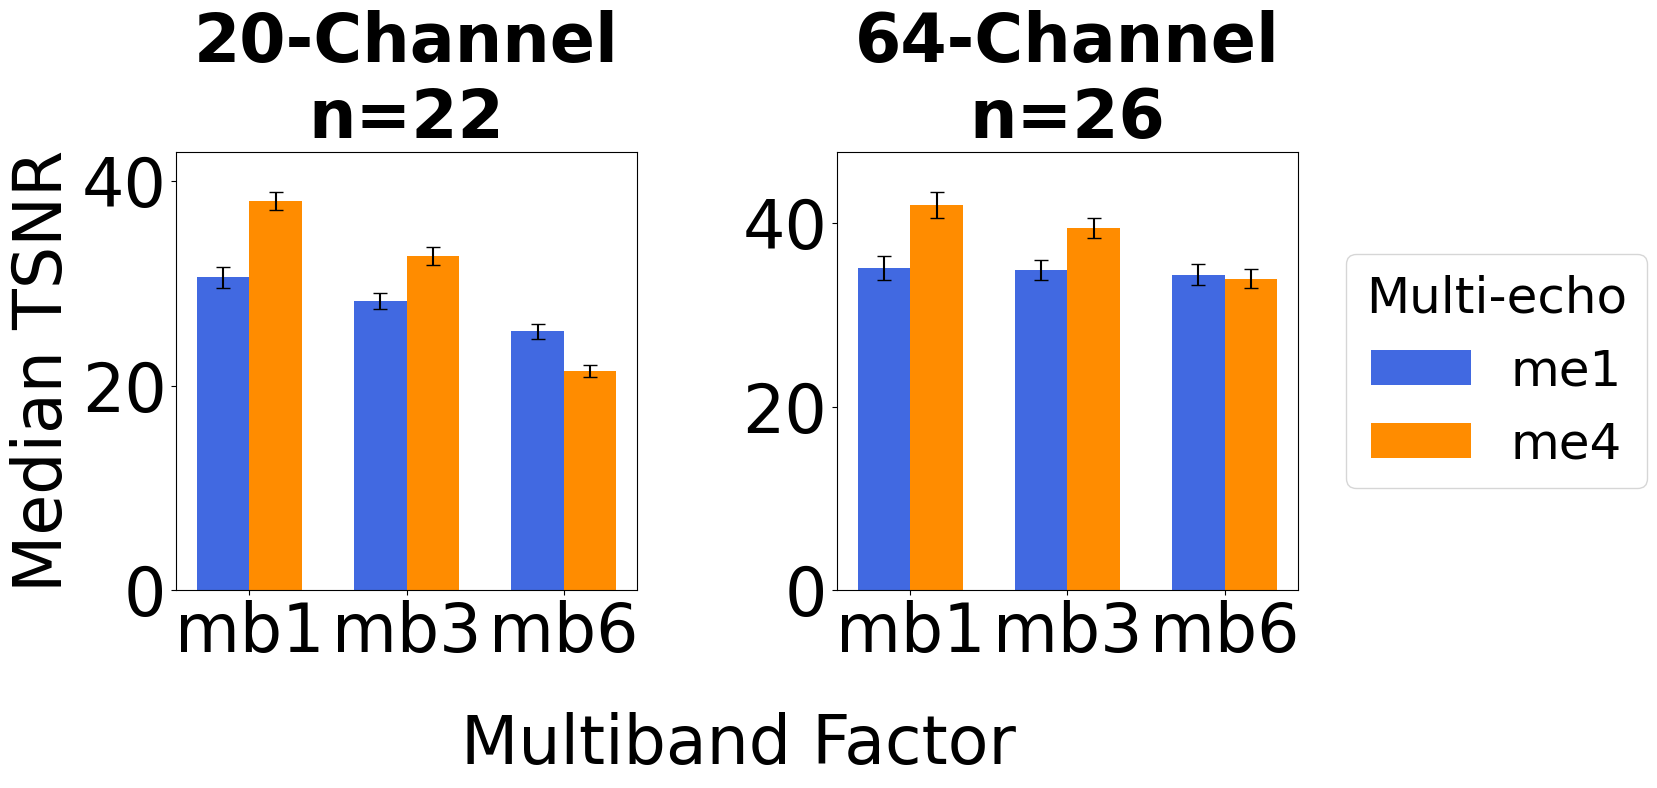

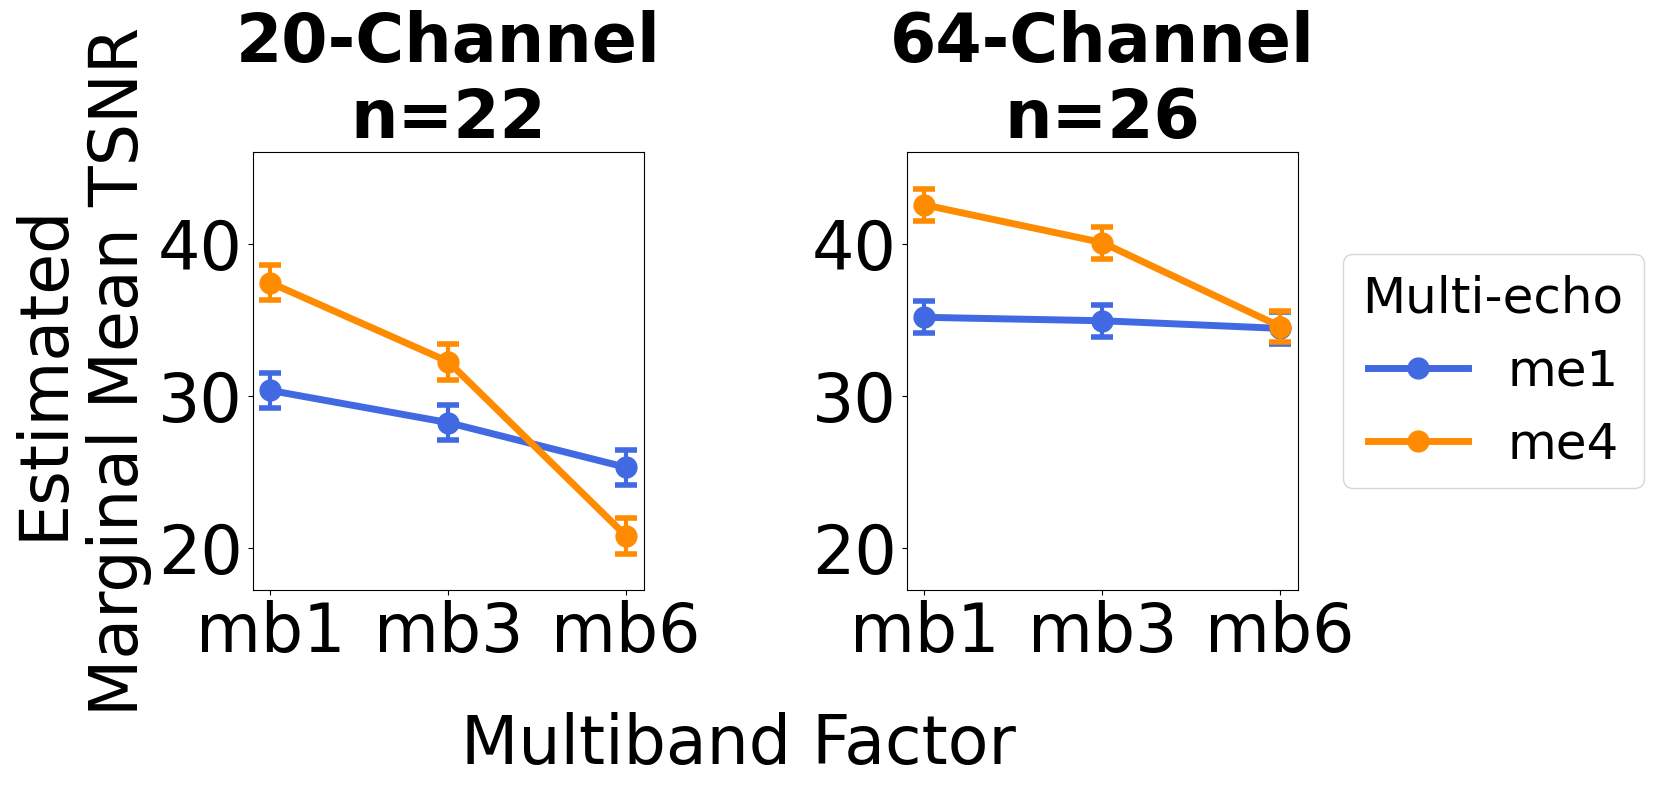

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro

# Activate automatic conversion between pandas and R dataframes
pandas2ri.activate()

# Import R packages
lme4 = importr('lme4')
lmerTest = importr('lmerTest')
emmeans = importr('emmeans')
base = importr('base')
stats = importr('stats')

# Check lme4 and lmerTest versions
print("lme4 version:", ro.r('packageVersion("lme4")')[0])
print("lmerTest version:", ro.r('packageVersion("lmerTest")')[0])

def load_and_preprocess_data(tsnr_path):
    """
    Load and preprocess TSNR data
    """
    tsnr_path = os.path.expanduser(tsnr_path)
    
    data = pd.read_csv(tsnr_path)
    
    column_mapping = {
        'Subject': 'sub',
        'ReceiveCoilName': 'coil',
        'AcquisitionType': 'acq',
        'tsnrMedian': 'tsnrMedian'
    }
    
    missing_cols = [col for col in column_mapping.keys() if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}. Found columns: {list(data.columns)}")
    
    data = data.rename(columns=column_mapping)
    data = data[~data['sub'].str.contains('sp', na=False)]
    
    data['mb'] = data['acq'].str.extract(r'(mb\d+)')[0]
    data['me'] = data['acq'].str.extract(r'(me\d+)')[0]
    
    categorical_cols = ['coil', 'mb', 'me']
    for col in categorical_cols:
        data[col] = pd.Categorical(data[col])
    
    # Compute n_subjects_per_coil after initial preprocessing
    data_clean = data.dropna(subset=['mb', 'me', 'coil', 'tsnrMedian'])
    n_subjects_per_coil = data_clean.groupby('coil', observed=True)['sub'].nunique().to_dict()
    
    return data, n_subjects_per_coil

def process_data(data, value_column):
    """
    Calculate mean and standard error by multiband, multi-echo, and coil
    """
    data = data.dropna(subset=['mb', 'me', 'coil', value_column])
    
    agg_data = data.groupby(['mb', 'me', 'coil'], observed=True).agg({
        value_column: 'mean',
        'sub': 'nunique'
    }).reset_index()
    
    std_error = data.groupby(['mb', 'me', 'coil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index()
    std_error.columns = ['mb', 'me', 'coil', 'se']
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'coil'])
    result.columns = ['mb', 'me', 'coil', value_column, 'n_subjects', 'se']
    
    return result

def create_tsnr_bar_plots(data_processed, n_subjects_per_coil, img_type='tsnrMedian', save_files=True):
    """
    Create bar plots for TSNR
    """
    plt.rcParams.update({'font.size': 48})
    coil_types = data_processed['coil'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    if len(coil_types) == 1:
        axes = [axes]
    
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [x + width for x in x1]
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    mb_levels = ['mb1', 'mb3', 'mb6']
    
    all_y_values = []
    all_y_errors = []
    
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['coil'] == coil]
        if coil_data.empty:
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')
            continue
        
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
        
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        if i == 0:
            ax.set_ylabel('Median TSNR', fontsize=48)
        
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        y_max = max([v + e for v, e in zip(y_values, y_errors) if v != 0], default=0)
        margin = y_max * 0.1
        ax.set_ylim(0, y_max + margin)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    
    if save_files:
        plt.savefig('tsnr_bar_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

def create_emm_line_plots(data, n_subjects_per_coil):
    """
    Create line plots for estimated marginal means of TSNR with consistent y-axis across subplots
    """
    # Prepare data for R
    data_r = data.rename(columns={'sub': 'Subj', 'coil': 'HC', 'mb': 'MB', 'me': 'ME', 
                                  'tsnrMedian': 'TSNR'})
    data_r = data_r.dropna(subset=['TSNR', 'MB', 'ME', 'HC', 'Subj'])
    
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    r_df = pandas2ri.py2rpy(data_r)
    
    # Ensure MB and ME are factors with correct levels in R
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    ''')
    r_df = ro.r('''
    transform({}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC))
    '''.format(r_df.r_repr()))
    
    # Fit the model
    formula = Formula('TSNR ~ HC * MB * ME + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Compute EMMs
    emm = emmeans.emmeans(model, 'MB', by=ro.StrVector(['HC', 'ME']))
    emm_r_df = ro.r('as.data.frame')(emm)
    emm_df = pandas2ri.rpy2py(emm_r_df)
    
    # Map numeric indices to string labels
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    hc_levels = sorted(data['coil'].unique())
    hc_map = {i + 1: hc for i, hc in enumerate(hc_levels)}
    
    emm_df['MB'] = emm_df['MB'].map(mb_map)
    emm_df['ME'] = emm_df['ME'].map(me_map)
    emm_df['HC'] = emm_df['HC'].map(hc_map)
    
    # Plotting
    plt.rcParams.update({'font.size': 48})
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    coil_types = emm_df['HC'].unique()
    
    # Collect all y-values and errors to determine consistent y-axis limits
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = emm_df[emm_df['HC'] == coil]
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            if not me_data.empty:
                y_values = me_data['emmean'].values
                y_errors = me_data['SE'].values
                all_y_values.extend(y_values)
                all_y_errors.extend(y_errors)
    
    # Calculate global y-axis limits
    if all_y_values:  # Ensure there are values to process
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1  # Add 10% margin
        y_limits = (max(0, y_min - margin), y_max + margin)  # Ensure y_min is not negative
    else:
        y_limits = (0, 1)  # Default in case of no data
    
    # Plot each subplot with consistent y-axis
    for i, coil in enumerate(coil_types):
        ax = axes[i]
        coil_data = emm_df[emm_df['HC'] == coil]
        
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            me_data = me_data.sort_values('MB', key=lambda x: x.str.extract(r'mb(\d+)')[0].astype(int))
            ax.plot(me_data['MB'], me_data['emmean'], marker='o', color=me_colors[me], label=me, linewidth=5, markersize=15)
            ax.errorbar(me_data['MB'], me_data['emmean'], yerr=me_data['SE'], fmt='none', color=me_colors[me], capsize=8, capthick=4, elinewidth=3)
        
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        if i == 0:
            ax.set_ylabel('Estimated\nMarginal Mean TSNR', fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        ax.set_ylim(y_limits)  # Apply consistent y-axis limits
    
    axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                    loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    plt.savefig('tsnr_emm_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

def run_statistical_analysis(data):
    """
    Perform statistical analysis for TSNR using R's lme4 and lmerTest, reporting APA-style results
    """
    # Prepare data for R
    data_r = data.rename(columns={'sub': 'Subj', 'coil': 'HC', 'mb': 'MB', 'me': 'ME', 
                                  'tsnrMedian': 'TSNR'})
    data_r = data_r.dropna(subset=['TSNR', 'MB', 'ME', 'HC', 'Subj'])
    
    print("Data summary:")
    print(data_r.groupby(['HC', 'MB', 'ME'], observed=True)['Subj'].nunique())
    
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    r_df = pandas2ri.py2rpy(data_r)
    
    # Assign data frame to R global environment and set factors
    ro.globalenv['data_r'] = r_df
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    data_r$MB <- factor(data_r$MB, levels = levels_MB)
    data_r$ME <- factor(data_r$ME, levels = levels_ME)
    data_r$HC <- factor(data_r$HC)
    contrasts(data_r$MB) <- contr.sum(levels_MB)
    contrasts(data_r$ME) <- contr.sum(levels_ME)
    contrasts(data_r$HC) <- contr.sum(levels(data_r$HC))
    ''')
    
    # Verify contrasts
    print("MB contrasts:")
    print(ro.r('contrasts(data_r$MB)'))
    print("ME contrasts:")
    print(ro.r('contrasts(data_r$ME)'))
    print("HC contrasts:")
    print(ro.r('contrasts(data_r$HC)'))
    
    # Fit the LME model
    formula = Formula('TSNR ~ HC * MB * ME + (1 | Subj)')
    model = lme4.lmer(formula, data=ro.r('data_r'))
    
    # Extract model summary, filtering out data structure
    model_summary = ro.r('summary')(model)
    summary_lines = ro.r('capture.output')(model_summary)
    filtered_summary = [line for line in summary_lines 
                       if not line.startswith('   Data: structure(')]
    print("Model summary:")
    print("\n".join(filtered_summary))
    
    # Try ANOVA table with Satterthwaite approximation
    try:
        anova_table = ro.r('lmerTest::anova')(model, ddf="Satterthwaite")
        anova_df = pandas2ri.rpy2py(ro.r('as.data.frame')(anova_table))
        print("ANOVA table columns:", anova_df.columns.tolist())
    except Exception as e:
        print("Error in ANOVA table extraction:", str(e))
        anova_df = None
    
    # Manually define numerator degrees of freedom
    df_dict = {
        'Head Coil': 1,  # HC: 2 levels - 1
        'Multiband': 2,  # MB: 3 levels - 1
        'Multi-echo': 1,  # ME: 2 levels - 1
        'Head Coil × Multiband': 2,  # 1 * 2
        'Head Coil × Multi-echo': 1,  # 1 * 1
        'Multiband × Multi-echo': 2,  # 2 * 1
        'Head Coil × Multiband × Multi-echo': 2  # 1 * 2 * 1
    }
    
    # Approximate denominator degrees of freedom (n_obs - fixed effects - random effects)
    n_obs = len(data_r)
    n_fixed = sum(df_dict.values())  # Total fixed effect df
    n_subj = data_r['Subj'].nunique()  # Random effect levels
    den_df_approx = n_obs - n_fixed - n_subj  # Simplified approximation
    
    # Build APA table
    apa_data = []
    if anova_df is not None and 'F value' in anova_df.columns:
        for effect in anova_df.index:
            if effect in ['(Intercept)', 'Residuals']:  # Skip non-fixed effects
                continue
            effect_name = {
                'HC': 'Head Coil',
                'MB': 'Multiband',
                'ME': 'Multi-echo',
                'HC:MB': 'Head Coil × Multiband',
                'HC:ME': 'Head Coil × Multi-echo',
                'MB:ME': 'Multiband × Multi-echo',
                'HC:MB:ME': 'Head Coil × Multiband × Multi-echo'
            }.get(effect, effect)
            apa_data.append({
                'Effect': effect_name,
                'Sum Sq': anova_df.loc[effect, 'Sum Sq'] if 'Sum Sq' in anova_df.columns else np.nan,
                'Mean Sq': anova_df.loc[effect, 'Mean Sq'] if 'Mean Sq' in anova_df.columns else np.nan,
                'Num df': df_dict.get(effect_name, np.nan),  # Use manual df
                'Den df': anova_df.loc[effect, 'DenDF'] if 'DenDF' in anova_df.columns else den_df_approx,
                'F': anova_df.loc[effect, 'F value'] if 'F value' in anova_df.columns else np.nan,
                'p': anova_df.loc[effect, 'Pr(>F)'] if 'Pr(>F)' in anova_df.columns else np.nan,
                'Partial η²': np.nan  # Computed below
            })
    else:
        # Fallback: Use manual df and placeholder values
        effects = ['Head Coil', 'Multiband', 'Multi-echo', 'Head Coil × Multiband', 
                   'Head Coil × Multi-echo', 'Multiband × Multi-echo', 
                   'Head Coil × Multiband × Multi-echo']
        for effect in effects:
            apa_data.append({
                'Effect': effect,
                'Sum Sq': np.nan,
                'Mean Sq': np.nan,
                'Num df': df_dict.get(effect, np.nan),
                'Den df': den_df_approx,
                'F': np.nan,
                'p': np.nan,
                'Partial η²': np.nan
            })
    
    # Compute partial eta-squared
    residual_var = ro.r('sigma')(model)**2
    if anova_df is not None and 'Sum Sq' in anova_df.columns:
        ss_effect = anova_df['Sum Sq']
        ss_residual = residual_var * (n_obs - n_fixed - 1)  # Approx residual SS
        partial_eta2 = ss_effect / (ss_effect + ss_residual)
    else:
        partial_eta2 = pd.Series([np.nan] * len(apa_data))
    
    # Update partial eta-squared
    for i, effect in enumerate([d['Effect'] for d in apa_data]):
        apa_data[i]['Partial η²'] = partial_eta2.iloc[i] if i < len(partial_eta2) else np.nan
    
    # Extract p-values using emmeans::test if anova fails to provide them
    if anova_df is None or 'Pr(>F)' not in anova_df.columns:
        p_values = {}
        effects = ['HC', 'MB', 'ME', 'HC:MB', 'HC:ME', 'MB:ME', 'HC:MB:ME']
        for effect in effects:
            try:
                # Use emmeans to compute p-values
                if ':' in effect:
                    # For interactions, split and create pairwise contrasts
                    factors = effect.split(':')
                    specs = ro.StrVector(factors)
                    emm = emmeans.emmeans(model, specs)
                    test_result = ro.r('test')(emm, adjust="none")
                    test_df = pandas2ri.rpy2py(ro.r('as.data.frame')(test_result))
                    p_values[effect] = test_df['p.value'].iloc[0] if 'p.value' in test_df.columns else np.nan
                else:
                    # For main effects
                    emm = emmeans.emmeans(model, effect)
                    test_result = ro.r('test')(emm, adjust="none")
                    test_df = pandas2ri.rpy2py(ro.r('as.data.frame')(test_result))
                    p_values[effect] = test_df['p.value'].iloc[0] if 'p.value' in test_df.columns else np.nan
            except Exception as e:
                print(f"Error computing p-value for {effect}: {str(e)}")
                p_values[effect] = np.nan
        
        # Map p-values to APA table
        effect_map = {
            'HC': 'Head Coil',
            'MB': 'Multiband',
            'ME': 'Multi-echo',
            'HC:MB': 'Head Coil × Multiband',
            'HC:ME': 'Head Coil × Multi-echo',
            'MB:ME': 'Multiband × Multi-echo',
            'HC:MB:ME': 'Head Coil × Multiband × Multi-echo'
        }
        for i, apa_row in enumerate(apa_data):
            effect = apa_row['Effect']
            for k, v in effect_map.items():
                if v == effect:
                    apa_row['p'] = p_values.get(k, np.nan)
                    break
    
    # Create APA-style table
    apa_table = pd.DataFrame(apa_data)
    apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
    apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
    apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)  # Integer with NA support
    apa_table['Den df'] = apa_table['Den df'].round(2)
    apa_table['F'] = apa_table['F'].round(2)
    apa_table['Partial η²'] = apa_table['Partial η²'].round(3)
    apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
    
    print("\nAPA-Style ANOVA Table for Linear Mixed Effects Model (TSNR ~ HC * MB * ME + (1 | Subj)):\n")
    print(apa_table.to_string(index=False))
    
    # Save APA table to CSV
    apa_table.to_csv('tsnr_lme_anova_table.csv', index=False)
    
    return {
        'model': model,
        'apa_table': apa_table
    }

def analyze_tsnr_data(tsnr_path):
    """
    Main function to perform TSNR analysis
    """
    data, n_subjects_per_coil = load_and_preprocess_data(tsnr_path)
    tsnr_processed = process_data(data, 'tsnrMedian')
    
    bar_plot = create_tsnr_bar_plots(tsnr_processed, n_subjects_per_coil, 'tsnrMedian')
    emm_plot = create_emm_line_plots(data, n_subjects_per_coil)
    statistical_results = run_statistical_analysis(data)
    
    return {
        'data': data,
        'bar_plot': bar_plot,
        'emm_plot': emm_plot,
        'statistical_results': statistical_results
    }

# Run the analysis
results = analyze_tsnr_data('~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv')

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In anova.merMod(new("lmerMod", resp = new("lmerResp", .xData = <environment>),  :
R[write to console]: 
 
R[write to console]:  additional arguments ignored: ‘ddf’



KeyError: 'Den Df'

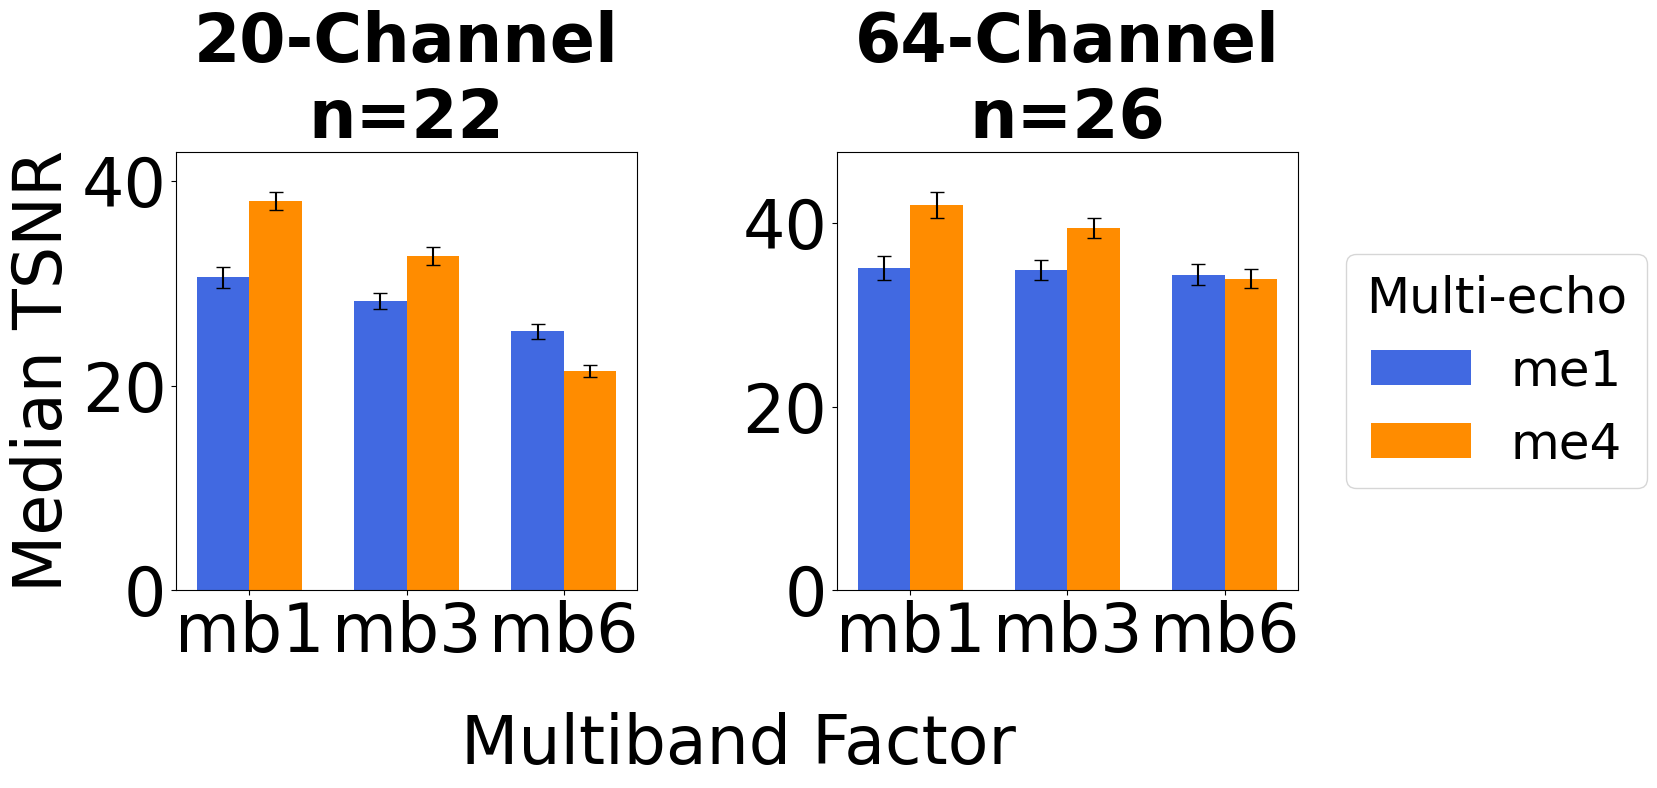

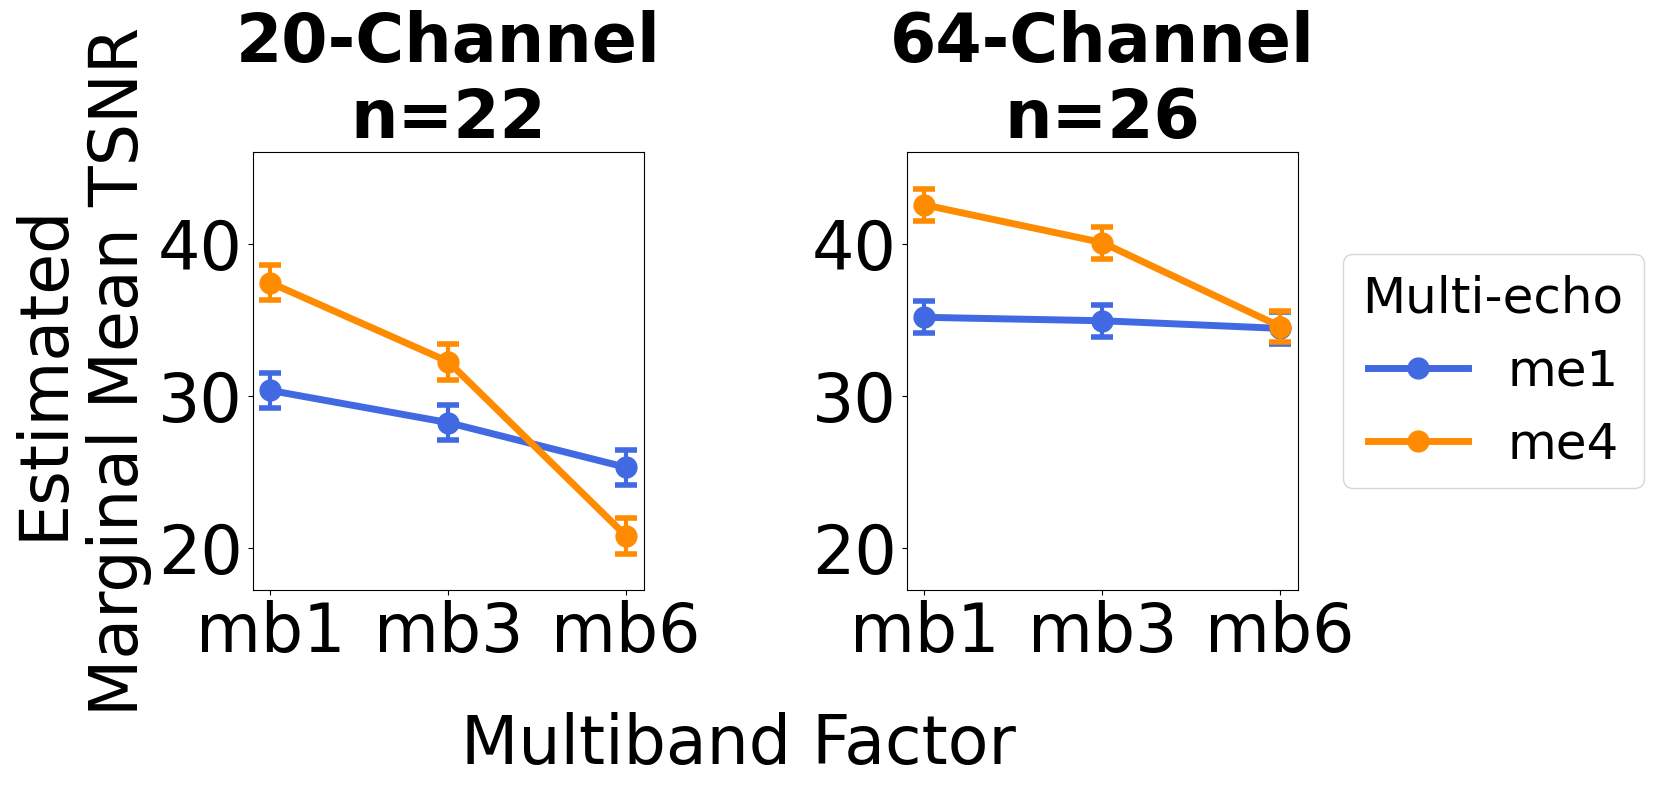

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro

# Activate automatic conversion between pandas and R dataframes
pandas2ri.activate()

# Import R packages
lme4 = importr('lme4')
lmerTest = importr('lmerTest')
emmeans = importr('emmeans')
base = importr('base')
stats = importr('stats')  # Added for anova table extraction

def load_and_preprocess_data(tsnr_path):
    """
    Load and preprocess TSNR data
    """
    tsnr_path = os.path.expanduser(tsnr_path)
    
    data = pd.read_csv(tsnr_path)
    
    column_mapping = {
        'Subject': 'sub',
        'ReceiveCoilName': 'coil',
        'AcquisitionType': 'acq',
        'tsnrMedian': 'tsnrMedian'
    }
    
    missing_cols = [col for col in column_mapping.keys() if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}. Found columns: {list(data.columns)}")
    
    data = data.rename(columns=column_mapping)
    data = data[~data['sub'].str.contains('sp', na=False)]
    
    data['mb'] = data['acq'].str.extract(r'(mb\d+)')[0]
    data['me'] = data['acq'].str.extract(r'(me\d+)')[0]
    
    categorical_cols = ['coil', 'mb', 'me']
    for col in categorical_cols:
        data[col] = pd.Categorical(data[col])
    
    # Compute n_subjects_per_coil after initial preprocessing
    data_clean = data.dropna(subset=['mb', 'me', 'coil', 'tsnrMedian'])
    n_subjects_per_coil = data_clean.groupby('coil', observed=True)['sub'].nunique().to_dict()
    
    return data, n_subjects_per_coil

def process_data(data, value_column):
    """
    Calculate mean and standard error by multiband, multi-echo, and coil
    """
    data = data.dropna(subset=['mb', 'me', 'coil', value_column])
    
    agg_data = data.groupby(['mb', 'me', 'coil'], observed=True).agg({
        value_column: 'mean',
        'sub': 'nunique'
    }).reset_index()
    
    std_error = data.groupby(['mb', 'me', 'coil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index()
    std_error.columns = ['mb', 'me', 'coil', 'se']
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'coil'])
    result.columns = ['mb', 'me', 'coil', value_column, 'n_subjects', 'se']
    
    return result

def create_tsnr_bar_plots(data_processed, n_subjects_per_coil, img_type='tsnrMedian', save_files=True):
    """
    Create bar plots for TSNR
    """
    plt.rcParams.update({'font.size': 48})
    coil_types = data_processed['coil'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    if len(coil_types) == 1:
        axes = [axes]
    
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [x + width for x in x1]
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    mb_levels = ['mb1', 'mb3', 'mb6']
    
    all_y_values = []
    all_y_errors = []
    
    for i, (coil, ax) in enumerate(zip(coil_types, axes)):
        coil_data = data_processed[data_processed['coil'] == coil]
        if coil_data.empty:
            ax.set_title(f"{coil}-Channel\nn=0", fontsize=48, fontweight='bold')
            continue
        
        me1_data = coil_data[coil_data['me'] == 'me1']
        me4_data = coil_data[coil_data['me'] == 'me4']
        
        me1_means = me1_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        me4_means = me4_data.set_index('mb')[img_type].reindex(mb_levels).fillna(0)
        me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
        
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        y_values = list(me1_means) + list(me4_means)
        y_errors = list(me1_errors) + list(me4_errors)
        all_y_values.extend([v for v in y_values if v != 0])
        all_y_errors.extend([e for e in y_errors if e != 0])
        
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        if i == 0:
            ax.set_ylabel('Median TSNR', fontsize=48)
        
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        y_max = max([v + e for v, e in zip(y_values, y_errors) if v != 0], default=0)
        margin = y_max * 0.1
        ax.set_ylim(0, y_max + margin)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    
    if save_files:
        plt.savefig('tsnr_bar_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

def create_emm_line_plots(data, n_subjects_per_coil):
    """
    Create line plots for estimated marginal means of TSNR with consistent y-axis across subplots
    """
    # Prepare data for R
    data_r = data.rename(columns={'sub': 'Subj', 'coil': 'HC', 'mb': 'MB', 'me': 'ME', 
                                  'tsnrMedian': 'TSNR'})
    data_r = data_r.dropna(subset=['TSNR', 'MB', 'ME', 'HC', 'Subj'])
    
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    r_df = pandas2ri.py2rpy(data_r)
    
    # Ensure MB and ME are factors with correct levels in R
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    ''')
    r_df = ro.r('''
    transform({}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC))
    '''.format(r_df.r_repr()))
    
    # Fit the model
    formula = Formula('TSNR ~ HC * MB * ME + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Compute EMMs
    emm = emmeans.emmeans(model, 'MB', by=ro.StrVector(['HC', 'ME']))
    emm_r_df = ro.r('as.data.frame')(emm)
    emm_df = pandas2ri.rpy2py(emm_r_df)
    
    # Map numeric indices to string labels
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    hc_levels = sorted(data['coil'].unique())
    hc_map = {i + 1: hc for i, hc in enumerate(hc_levels)}
    
    emm_df['MB'] = emm_df['MB'].map(mb_map)
    emm_df['ME'] = emm_df['ME'].map(me_map)
    emm_df['HC'] = emm_df['HC'].map(hc_map)
    
    # Plotting
    plt.rcParams.update({'font.size': 48})
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    coil_types = emm_df['HC'].unique()
    
    # Collect all y-values and errors to determine consistent y-axis limits
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = emm_df[emm_df['HC'] == coil]
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            if not me_data.empty:
                y_values = me_data['emmean'].values
                y_errors = me_data['SE'].values
                all_y_values.extend(y_values)
                all_y_errors.extend(y_errors)
    
    # Calculate global y-axis limits
    if all_y_values:  # Ensure there are values to process
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1  # Add 10% margin
        y_limits = (max(0, y_min - margin), y_max + margin)  # Ensure y_min is not negative
    else:
        y_limits = (0, 1)  # Default in case of no data
    
    # Plot each subplot with consistent y-axis
    for i, coil in enumerate(coil_types):
        ax = axes[i]
        coil_data = emm_df[emm_df['HC'] == coil]
        
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            me_data = me_data.sort_values('MB', key=lambda x: x.str.extract(r'mb(\d+)')[0].astype(int))
            ax.plot(me_data['MB'], me_data['emmean'], marker='o', color=me_colors[me], label=me, linewidth=5, markersize=15)
            ax.errorbar(me_data['MB'], me_data['emmean'], yerr=me_data['SE'], fmt='none', color=me_colors[me], capsize=8, capthick=4, elinewidth=3)
        
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        if i == 0:
            ax.set_ylabel('Estimated\nMarginal Mean TSNR', fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        ax.set_ylim(y_limits)  # Apply consistent y-axis limits
    
    axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                    loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    plt.savefig('tsnr_emm_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

def run_statistical_analysis(data):
    """
    Perform statistical analysis for TSNR using R's lme4 and lmerTest, reporting APA-style results
    """
    # Prepare data for R
    data_r = data.rename(columns={'sub': 'Subj', 'coil': 'HC', 'mb': 'MB', 'me': 'ME', 
                                  'tsnrMedian': 'TSNR'})
    data_r = data_r.dropna(subset=['TSNR', 'MB', 'ME', 'HC', 'Subj'])
    
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    r_df = pandas2ri.py2rpy(data_r)
    
    # Ensure MB and ME are factors with correct levels in R
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    ''')
    r_df = ro.r('''
    transform({}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC))
    '''.format(r_df.r_repr()))
    
    # Fit the LME model
    formula = Formula('TSNR ~ HC * MB * ME + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Extract ANOVA table with F-statistics and p-values
    anova_table = ro.r('anova')(model, ddf='Satterthwaite')
    anova_df = pandas2ri.rpy2py(ro.r('as.data.frame')(anova_table))
    
    # Compute partial eta-squared for effect sizes
    # Partial eta-squared = SS_effect / (SS_effect + SS_residual)
    # Residual SS is approximated from model deviance or variance components
    model_summary = ro.r('summary')(model)
    # Extract variance components (approximate residual variance)
    varcor = ro.r('VarCorr')(model)
    residual_var = ro.r('sigma')(model)**2  # Residual variance
    # Sum of squares from ANOVA table
    ss_effect = anova_df['Sum Sq']
    ss_total = ss_effect + residual_var * anova_df['Den Df']  # Approximate total SS
    partial_eta2 = ss_effect / ss_total
    
    # Format APA-style table
    apa_table = pd.DataFrame({
        'Effect': anova_df.index,
        'Sum Sq': anova_df['Sum Sq'].round(2),
        'Mean Sq': anova_df['Mean Sq'].round(2),
        'Num df': anova_df['NumDF'].astype(int),
        'Den df': anova_df['DenDF'].round(2),
        'F': anova_df['F value'].round(2),
        'p': anova_df['Pr(>F)'].apply(lambda x: '< .001' if x < 0.001 else f'{x:.3f}'),
        'Partial η²': partial_eta2.round(3)
    })
    
    # Adjust effect names for clarity
    apa_table['Effect'] = apa_table['Effect'].replace({
        'HC': 'Head Coil',
        'MB': 'Multiband',
        'ME': 'Multi-echo',
        'HC:MB': 'Head Coil × Multiband',
        'HC:ME': 'Head Coil × Multi-echo',
        'MB:ME': 'Multiband × Multi-echo',
        'HC:MB:ME': 'Head Coil × Multiband × Multi-echo'
    })
    
    print("\nAPA-Style ANOVA Table for Linear Mixed Effects Model (TSNR ~ HC * MB * ME + (1 | Subj)):\n")
    print(apa_table.to_string(index=False))
    
    # Save APA table to CSV for manuscript inclusion
    apa_table.to_csv('tsnr_lme_anova_table.csv', index=False)
    
    return {
        'model': model,
        'apa_table': apa_table
    }

def analyze_tsnr_data(tsnr_path):
    """
    Main function to perform TSNR analysis
    """
    data, n_subjects_per_coil = load_and_preprocess_data(tsnr_path)
    tsnr_processed = process_data(data, 'tsnrMedian')
    
    bar_plot = create_tsnr_bar_plots(tsnr_processed, n_subjects_per_coil, 'tsnrMedian')
    emm_plot = create_emm_line_plots(data, n_subjects_per_coil)
    statistical_results = run_statistical_analysis(data)
    
    return {
        'data': data,
        'bar_plot': bar_plot,
        'emm_plot': emm_plot,
        'statistical_results': statistical_results
    }

# Run the analysis
results = analyze_tsnr_data('~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv')

In [20]:
results = analyze_multiecho_data(
    '~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv', 
    '~/Documents/GitHub/multiecho-pilot/smoothness-all.csv' # use smoothness-all-zero.csv for pre-5mm smoothed data (panel A)
)

TypeError: load_and_preprocess_data() takes 1 positional argument but 2 were given

# Figs 5-7. Analysis of Multiecho fMRI Data with Mixed-Effects Modeling

This code chunk defines a set of Python functions to process, analyze, and visualize multiecho fMRI data extracted from text files, focusing on the effects of headcoil type (20 vs. 64 channels), multiband (MB) factor (mb1, mb3, mb6), and multi-echo (ME) settings (me1, me4) on a specified imaging metric (e.g., beta values). The analysis mirrors a prior TSNR/Smoothness study, ensuring consistency in statistical methodology.

### Key Components
1. **Data Extraction and Preparation**:
   - `extract_file_data`: Parses text files in a specified directory (e.g., `~/Documents/GitHub/multiecho-pilot/derivatives/extractions`) matching a regex pattern, extracting metric values for each subject and acquisition type (e.g., `mb1me1`, `mb3me4`).
   - `create_dataframe`: Builds a wide-format DataFrame with subjects, headcoil assignments (20 or 64, based on a predefined list), and acquisition-specific metric values.

2. **Visualization**:
   - `prepare_plot_data`: Computes means and standard errors of the metric for each acquisition, split by headcoil.
   - `create_bar_plots`: Generates side-by-side bar plots (20-channel vs. 64-channel) showing the metric across MB factors, with ME settings differentiated by color (blue for me1, orange for me4).

3. **Statistical Analysis**:
   - `process_mask`: Orchestrates the workflow for a given mask (e.g., `VSconstrained`):
     - Reshapes data into long format with `mb` (multiband) and `me` (multi-echo) as separate columns.
     - Treats `mb` and `me` as ordered categorical variables (`mb1 < mb3 < mb6`, `me1 < me4`) to enable linear (`.L`) and quadratic (`.Q`) contrasts.
     - Fits a linear mixed-effects model: `<metric> ~ headcoil * mb * me + (1 | subject)`, capturing main effects and interactions with a random intercept for subjects.
     - Performs pairwise Tukey HSD tests for `mb` levels, averaged over `headcoil` and `me`, to assess differences (e.g., mb1 vs. mb3).
   - Outputs include model summaries (fixed/random effects) and pairwise comparison results.

4. **Execution**:
   - `run_analysis`: Runs the full pipeline across multiple masks, with options to save DataFrames and plots as CSV and PNG files.

### Inputs
- `base_dir`: Directory containing fMRI data files (default: `~/Documents/GitHub/multiecho-pilot/derivatives/extractions`).
- `type_value`: Analysis type (e.g., `act` for activation).
- `img_value`: Metric to analyze (e.g., `beta`).
- `mask_values`: List of ROIs (e.g., `["VSconstrained", "rFFA"]`).
- `denoise_value`: Denoising method (e.g., `smooth`).
- `headcoil_64_subjects`: List of subject IDs using the 64-channel headcoil.

### Outputs
- **DataFrames**: Saved as CSV files (e.g., `multiecho_data_act_beta_VSconstrained_smooth_RewgtPun.csv`).
- **Plots**: Bar plots saved as PNG files (e.g., `multiecho_plots_act_beta_VSconstrained_smooth_RewgtPun.png`).
- **Statistical Results**: Printed summaries of mixed-effects models and pairwise comparisons for each mask.

### Notes
- The code assumes text files contain a single float value per file and skips files with `sp` in the subject ID.
- Missing data is handled by dropping NaNs before modeling, with diagnostics printed for debugging.
- Plot aesthetics (e.g., font size, colors) are set via `initialize_plotting_engine` for consistency.

This chunk establishes a reproducible framework for comparing acquisition parameters across ROIs, aligning statistical rigor with the TSNR/Smoothness analysis.

In [23]:
# Define functions for generating plots and statistical analysis

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# Activate pandas-R conversion
pandas2ri.activate()

# Import R packages
base = importr('base')
lme4 = importr('lme4')
emmeans = importr('emmeans')
ggplot2 = importr('ggplot2')

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    sns.set_style("whitegrid")
    sns.set_context("talk")
    plt.rcParams.update({'font.size': 56})

def determine_contrast(mask_value):
    """Determine contrast based on mask value"""
    if mask_value in ["VSconstrained", "VMPFC"]:
        return "Rew>Pun"
    elif mask_value == "rFFA":
        return "Str>Com"
    elif mask_value in ["bilateralMotor", "bilateralCerebellum"]:
        return "Avg (L>R, R>L)"
    else:
        return "Unknown"

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in headcoil_64_subjects else 20)
    df['headcoil'] = df['headcoil'].astype(str)  # Convert headcoil to categorical
    column_order = ['subject', 'headcoil'] + acq_params
    df = df[column_order]
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    return df

def prepare_plot_data(df):
    """Prepare data for plotting by calculating means and errors by headcoil type"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    df_20 = df[df['headcoil'] == '20']
    df_64 = df[df['headcoil'] == '64']
    results = {}
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        means = {acq: hc_df[acq].mean() for acq in acq_params}  # NaN-safe by default
        errors = {acq: hc_df[acq].sem() for acq in acq_params}  # NaN-safe by default
        results[hc_name] = {'means': means, 'errors': errors, 'count': len(hc_df)}
    return results

def create_bar_plots(plot_data, mask_value, contrast, is_first=False, is_last=False):
    """Create bar plots for the given data with consistent y-axis limits within each ROI"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [0+width, 1.2+width, 2.4+width]
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    all_y_values = []
    all_y_errors = []
    
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        all_y_values.extend([v for v in y_values if not np.isnan(v)])  # Filter NaNs
        all_y_errors.extend([e for e in y_errors if not np.isnan(e)])  # Filter NaNs
        if i == 0:
            ax.set_ylabel(f"{mask_value}", fontsize=36)
        if is_first:
            ax.set_title(f"{title}\nn={count}", fontsize=56, fontweight='bold')
        ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=56)
        ax.tick_params(axis='both', which='major', labelsize=56)
        ax.set_xlabel("Multiband Factor", fontsize=36)
        if is_first and i == 1:
            legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=112)
            legend.get_title().set_fontsize(112)
            ax.legend(loc='upper right')
    
    if all_y_values and all_y_errors:
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1
        ax1.set_ylim(y_min - margin, y_max + margin)
        ax2.set_ylim(y_min - margin, y_max + margin)
    else:
        print(f"Warning: No valid data for plotting y-limits in {mask_value}")
    
    if is_last:
        fig.text(0.5, -0.05, 'Multiband Factor', ha='center', fontsize=56)
    plt.tight_layout(pad=1.0)
    if is_last:
        plt.subplots_adjust(bottom=0.2)
    return fig

def create_emm_line_plots(emm_df, n_subjects_per_coil, mask_value, contrast, output_dir, type_value, img_value, denoise_value):
    """Create line plots for estimated marginal means with consistent y-axis limits and save as PNG"""
    plt.rcParams.update({'font.size': 56})
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Define colors for me1 and me4
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    coil_types = sorted(emm_df['headcoil'].unique())  # Ensure order: '20', '64'
    
    # Plot data for each coil in its respective subplot
    for i, coil in enumerate(coil_types):
        ax = axes[i]  # Assign subplot based on coil index
        coil_data = emm_df[emm_df['headcoil'] == coil]
        
        # Plot for each me value within the current coil
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['me'] == me]
            if not me_data.empty:
                me_data = me_data.sort_values('mb')
                ax.plot(me_data['mb'], me_data['emmean'], marker='o', color=me_colors[me], linewidth=5, markersize=15)
                ax.errorbar(me_data['mb'], me_data['emmean'], yerr=me_data['SE'], fmt='none', color=me_colors[me], capsize=8, capthick=4, elinewidth=3)
        
        # Set title and labels
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=56, fontweight='bold')
        if i == 0:
            ax.set_ylabel(f"{mask_value} EMMs", fontsize=56)
        ax.set_xticks(['mb1', 'mb3', 'mb6'])
        ax.tick_params(axis='both', which='major', labelsize=56)
        ax.set_xlabel("Multiband Factor", fontsize=36)
        
        # Set y-limits based on this subplot's data
        y_values = []
        y_errors = []
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['me'] == me]
            if not me_data.empty:
                y_values.extend(me_data['emmean'].values)
                y_errors.extend(me_data['SE'].values)
        if y_values:
            y_max = max([v + e for v, e in zip(y_values, y_errors)])
            y_min = min([v - e for v, e in zip(y_values, y_errors)])
            margin = (y_max - y_min) * 0.1
            ax.set_ylim(max(0, y_min - margin), y_max + margin)
        else:
            ax.set_ylim(0, 1)  # Default if no data
    
    plt.tight_layout()
    fig.supxlabel('Multiband Factor', fontsize=56, y=-0.05)
    if output_dir:
        plot_file = os.path.join(output_dir, f"emm_plot_{type_value}_{img_value}_{mask_value}_{denoise_value}_{contrast.replace('>', 'gt').replace(' ', '_').replace(',', '')}.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"EMM plot saved as '{plot_file}'")
    plt.close()  # Close the figure to prevent rendering in the notebook
    return fig

def process_mask(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects, 
                 is_first=False, is_last=False, save_files=True, output_dir="../derivatives/plots"):
    """Process a single mask, create and save both bar and EMM plots, and run statistical analysis"""
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    contrast = determine_contrast(mask_value)
    print(f"\nProcessing files with parameters: type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}")
    print(f"Using contrast: {contrast}")
    
    # Extract data
    data_by_subject = extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value)
    if not data_by_subject:
        print(f"No matching files found for mask: {mask_value}")
        return None
    
    # Create DataFrame
    df = create_dataframe(data_by_subject, headcoil_64_subjects)
    
    if save_files:
        output_file = os.path.join(output_dir, f"multiecho_data_{type_value}_{img_value}_{mask_value}_{denoise_value}_{contrast.replace('>', 'gt').replace(' ', '_').replace(',', '')}.csv")
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df)} subjects")
    print("\nSample of the data:")
    print(df.head())
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get('64', 0)}")
    print(f"20-channel: {headcoil_counts.get('20', 0)}")
    print(f"Missing values per column:\n{df.isnull().sum()}")  # Added diagnostic
    
    # Reshape data for statistical analysis
    df_long = pd.melt(
        df, 
        id_vars=['subject', 'headcoil'], 
        value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
        var_name='acq', 
        value_name=img_value
    )
    df_long['mb'] = df_long['acq'].str[:3]  # Extract 'mb1', 'mb3', 'mb6'
    df_long['me'] = df_long['acq'].str[3:]  # Extract 'me1', 'me4'
    df_long = df_long.drop(columns=['acq'])
    
    # Set ordered factors for mb and me (like MB.L, MB.Q, ME.L)
    df_long['mb'] = pd.Categorical(df_long['mb'], categories=['mb1', 'mb3', 'mb6'], ordered=True)
    df_long['me'] = pd.Categorical(df_long['me'], categories=['me1', 'me4'], ordered=True)
    df_long['headcoil'] = df_long['headcoil'].astype(str)  # Ensure headcoil is categorical
    
    # Compute n_subjects_per_coil for EMM plot titles
    n_subjects_per_coil = df.groupby('headcoil')['subject'].nunique().to_dict()
    
    # Run Python-based linear mixed-effects model with NaN handling
    print(f"\nRunning statistical analysis for {mask_value} ({img_value})...")
    df_long_clean = df_long.dropna(subset=[img_value])  # Drop NaNs before LMM
    if len(df_long_clean) < 2:  # Minimum observations for LMM
        print(f"Insufficient data for LMM after removing NaNs: {len(df_long_clean)} observations")
        result = None
    else:
        try:
            model = smf.mixedlm(f"{img_value} ~ headcoil * mb * me", df_long_clean, groups=df_long_clean["subject"])
            result = model.fit()
            print(result.summary())
            
            # Pairwise comparisons for mb (averaged over headcoil and me)
            print(f"\nPairwise comparisons for mb (averaged over headcoil and me):")
            tukey_mb = pairwise_tukeyhsd(endog=df_long_clean[img_value], groups=df_long_clean['mb'], alpha=0.05)
            print(tukey_mb)
            
        except Exception as e:
            print(f"LMM failed: {e}")
            print(f"Shape of df_long_clean: {df_long_clean.shape}")
            print(f"Missing values in df_long_clean:\n{df_long_clean.isnull().sum()}")
            result = None
    
    # Run R-based analysis with emmeans for EMMs and 3-way interaction
    print(f"\nRunning R-based EMM analysis for {mask_value} ({img_value})...")
    if len(df_long_clean) >= 2:
        try:
            # Convert to R dataframe
            rdf = pandas2ri.py2rpy(df_long_clean)
            ro.globalenv['rdf'] = rdf
            
            # Pass mask_value, headcoil counts, and img_value to R
            ro.globalenv['roi'] = mask_value
            ro.globalenv['n_20'] = headcoil_counts.get('20', 0)
            ro.globalenv['n_64'] = headcoil_counts.get('64', 0)
            ro.globalenv['img_value'] = img_value
            
            # Fit model and compute EMMs in R
            ro.r('''
            library(lme4)
            library(emmeans)
            
            rdf$subject <- as.factor(rdf$subject)
            rdf$mb <- factor(rdf$mb, levels = c("mb1", "mb3", "mb6"))
            rdf$me <- factor(rdf$me, levels = c("me1", "me4"))
            rdf$headcoil <- as.factor(rdf$headcoil)
            
            # Dynamically construct the formula using img_value
            formula_str <- paste(img_value, "~ headcoil * mb * me + (1 | subject)")
            model <- lmer(as.formula(formula_str), data = rdf)
            
            # Joint test for 3-way interaction
            cat("\\n===== Joint Tests for 3-Way Interaction =====\\n")
            print(joint_tests(emmeans(model, ~ headcoil * mb * me)))
            
            # Extract EMMs and return to Python
            emm <- emmeans(model, ~ mb * me * headcoil)
            emm_df <- as.data.frame(emm)
            ''')
            
            # Retrieve EMM data from R
            emm_r_df = ro.globalenv['emm_df']
            emm_df = pandas2ri.rpy2py(emm_r_df)
            
            # Map numeric factor levels to strings
            mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
            me_map = {1: 'me1', 2: 'me4'}
            headcoil_map = {1: '20', 2: '64'}  # Based on df_long headcoil assignment
            emm_df['mb'] = emm_df['mb'].map(mb_map)
            emm_df['me'] = emm_df['me'].map(me_map)
            emm_df['headcoil'] = emm_df['headcoil'].map(headcoil_map)
            
            # Verify the mapping
            print(f"Debug: After mapping, emm_df shape: {emm_df.shape}")
            print(f"Debug: After mapping, emm_df columns: {emm_df.columns.tolist()}")
            print(f"Debug: After mapping, emm_df head:\n{emm_df.head()}")
            
            # Create EMM line plots
            emm_fig = create_emm_line_plots(emm_df, n_subjects_per_coil, mask_value, contrast, output_dir, type_value, img_value, denoise_value)
            
        except Exception as e:
            print(f"R-based EMM analysis failed: {e}")
    
    # Prepare plot data and create bar plots
    print("\nCreating bar plots...")
    plot_data = prepare_plot_data(df)
    fig = create_bar_plots(plot_data, mask_value, contrast, is_first, is_last)
    if save_files:
        plot_file = os.path.join(output_dir, f"multiecho_plots_{type_value}_{img_value}_{mask_value}_{denoise_value}_{contrast.replace('>', 'gt').replace(' ', '_').replace(',', '')}.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Bar plot saved as '{plot_file}'")
    plt.show()  # Display bar plot in Jupyter
    
    return {
        'dataframe': df,
        'figure': fig,
        'emm_figure': emm_fig if 'emm_fig' in locals() else None,
        'contrast': contrast,
        'plot_data': plot_data,
        'lmm_result': result
    }

def run_analysis(type_value, img_value, mask_values, denoise_value, base_dir=None, save_files=True, output_dir="../derivatives/plots"):
    """Run the full analysis for the given parameters"""
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    headcoil_64_subjects = [
        "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
        "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
        "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
        "10186", "10188", "10221"
    ]
    initialize_plotting_engine()
    print(f"\nAnalysis Parameters: TYPE_VALUE={type_value.upper()}, IMG_VALUE={img_value.capitalize()}")
    results = {}
    for i, mask_value in enumerate(mask_values):
        is_first = (i == 0)
        is_last = (i == len(mask_values) - 1)
        result = process_mask(
            base_dir=base_dir,
            type_value=type_value,
            img_value=img_value, 
            mask_value=mask_value,
            denoise_value=denoise_value,
            headcoil_64_subjects=headcoil_64_subjects,
            is_first=is_first,
            is_last=is_last,
            save_files=save_files,
            output_dir=output_dir
        )
        if result:
            results[mask_value] = result
    return results

In [27]:
# Define functions for generating plots and statistical analysis

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# Activate pandas-R conversion
pandas2ri.activate()

# Import R packages
base = importr('base')
lme4 = importr('lme4')
lmerTest = importr('lmerTest')
emmeans = importr('emmeans')

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    plt.rcParams.update({'font.size': 48})

def determine_contrast(mask_value):
    """Determine contrast based on mask value"""
    if mask_value in ["VSconstrained", "VMPFC"]:
        return "Rew>Pun"
    elif mask_value == "rFFA":
        return "Str>Com"
    elif mask_value in ["bilateralMotor", "bilateralCerebellum"]:
        return "Avg (L>R, R>L)"
    else:
        return "Unknown"

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['headcoil'] = df['subject'].apply(lambda x: '64' if x in headcoil_64_subjects else '20')
    column_order = ['subject', 'headcoil'] + acq_params
    df = df[column_order]
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    return df

def prepare_plot_data(df):
    """Prepare data for plotting by calculating means and errors by headcoil type"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    df_20 = df[df['headcoil'] == '20']
    df_64 = df[df['headcoil'] == '64']
    results = {}
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        means = {acq: hc_df[acq].mean() for acq in acq_params}
        errors = {acq: hc_df[acq].sem() for acq in acq_params}
        results[hc_name] = {'means': means, 'errors': errors, 'count': len(hc_df)}
    return results

def create_bar_plots(plot_data, mask_value, contrast, title_prefix=""):
    """Create bar plots for the given data with consistent y-axis limits within each ROI"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    width = 0.4
    x1 = [0, 1.2, 2.4]
    x2 = [x + width for x in x1]
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    mb_levels = ['mb1', 'mb3', 'mb6']
    
    all_y_values = []
    all_y_errors = []
    
    for i, (hc, ax) in enumerate([('20', ax1), ('64', ax2)]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
               yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
               yerr=me4_errors, capsize=5)
        
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        all_y_values.extend([v for v in y_values if not np.isnan(v)])
        all_y_errors.extend([e for e in y_errors if not np.isnan(e)])
        
        ax.set_xticks([x + width/2 for x in x1])
        ax.set_xticklabels(mb_levels, fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        
        if i == 0:
            ax.set_ylabel(f'{title_prefix}{mask_value}', fontsize=48)
        
        ax.set_title(f"{hc}-Channel\nn={count}", fontsize=48, fontweight='bold')
    
    # Set consistent y-limits
    if all_y_values and all_y_errors:
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors) if not np.isnan(v)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors) if not np.isnan(v)])
        margin = (y_max - y_min) * 0.1
        ax1.set_ylim(max(0, y_min - margin), y_max + margin)
        ax2.set_ylim(max(0, y_min - margin), y_max + margin)
    
    # Add legend
    axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                    loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    
    return fig

def create_emm_line_plots(emm_df, n_subjects_per_coil, mask_value, title_prefix=""):
    """Create line plots for estimated marginal means with consistent y-axis limits"""
    plt.rcParams.update({'font.size': 48})
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    coil_types = sorted(emm_df['headcoil'].unique())
    
    # Collect all y-values and errors to determine consistent y-axis limits
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = emm_df[emm_df['headcoil'] == coil]
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['me'] == me]
            if not me_data.empty:
                y_values = me_data['emmean'].values
                y_errors = me_data['SE'].values
                all_y_values.extend(y_values)
                all_y_errors.extend(y_errors)
    
    # Calculate global y-axis limits
    if all_y_values:
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1
        y_limits = (max(0, y_min - margin), y_max + margin)
    else:
        y_limits = (0, 1)
    
    for i, coil in enumerate(coil_types):
        ax = axes[i]
        coil_data = emm_df[emm_df['headcoil'] == coil]
        
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['me'] == me]
            if not me_data.empty:
                me_data = me_data.sort_values('mb')
                ax.plot(me_data['mb'], me_data['emmean'], marker='o', color=me_colors[me], 
                        label=me, linewidth=5, markersize=15)
                ax.errorbar(me_data['mb'], me_data['emmean'], yerr=me_data['SE'], 
                            fmt='none', color=me_colors[me], capsize=8, capthick=4, elinewidth=3)
        
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"{coil}-Channel\nn={n_subjects}", fontsize=48, fontweight='bold')
        if i == 0:
            ax.set_ylabel(f'Estimated\nMarginal Mean {title_prefix}{mask_value}', fontsize=48)
        ax.tick_params(axis='both', which='major', labelsize=48)
        ax.set_ylim(y_limits)
    
    axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                    loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    
    return fig

def run_statistical_analysis(df_long, img_value, mask_value):
    """Run statistical analysis using R's lme4 and emmeans"""
    df_long_clean = df_long.dropna(subset=[img_value])
    
    if len(df_long_clean) < 2:
        print(f"Insufficient data for LMM after removing NaNs: {len(df_long_clean)} observations")
        return None
    
    # Convert to R dataframe
    r_df = pandas2ri.py2rpy(df_long_clean)
    
    # Ensure factors are properly set in R
    ro.r('''
    levels_mb <- c("mb1", "mb3", "mb6")
    levels_me <- c("me1", "me4")
    ''')
    r_df = ro.r('''
    transform({}, 
              subject = factor(subject),
              mb = factor(mb, levels = levels_mb), 
              me = factor(me, levels = levels_me), 
              headcoil = factor(headcoil))
    '''.format(r_df.r_repr()))
    
    # Fit the model
    formula = Formula(f'{img_value} ~ headcoil * mb * me + (1 | subject)')
    model = lme4.lmer(formula, data=r_df)
    
    # Get model summary
    model_summary = ro.r('summary')(model)
    summary_lines = ro.r('capture.output')(model_summary)
    summary_lines_list = list(summary_lines)
    # Remove the Data section as in the TSNR kernel
    data_start = None
    data_end = None
    for i, line in enumerate(summary_lines_list):
        if line.startswith('   Data:'):
            data_start = i
        elif data_start is not None and line.startswith('REML criterion at convergence:'):
            data_end = i
            break
    if data_start is not None and data_end is not None:
        summary_lines_list = summary_lines_list[:data_start] + summary_lines_list[data_end:]
    model_summary_str = '\n'.join(summary_lines_list)
    
    print(f"\nLinear Mixed Effects Model Summary ({img_value} ~ headcoil * mb * me + (1 | subject)):\n")
    print(model_summary_str)
    
    # Compute pairwise comparisons
    emm = emmeans.emmeans(model, ro.StrVector(['headcoil', 'mb', 'me']))
    pairwise = ro.r('pairs')(emm)
    pairwise_r_df = ro.r('as.data.frame')(pairwise)
    pairwise_df = pandas2ri.rpy2py(pairwise_r_df)
    
    # Extract EMMs for plotting
    emm_r_df = ro.r('as.data.frame')(emm)
    emm_df = pandas2ri.rpy2py(emm_r_df)
    
    # Map numeric indices to string labels
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    headcoil_map = {1: '20', 2: '64'}
    
    emm_df['mb'] = emm_df['mb'].map(mb_map)
    emm_df['me'] = emm_df['me'].map(me_map)
    emm_df['headcoil'] = emm_df['headcoil'].map(headcoil_map)
    
    # Map pairwise comparisons
    def map_contrast(contrast):
        for num, label in mb_map.items():
            contrast = contrast.replace(f'mb{num}', f'mb{label}')
        for num, label in me_map.items():
            contrast = contrast.replace(f'me{num}', f'me{label}')
        for num, label in headcoil_map.items():
            contrast = contrast.replace(f'headcoil{num}', f'headcoil{label}')
        return contrast
    
    pairwise_df['contrast'] = pairwise_df['contrast'].apply(map_contrast)
    
    print(f"\nPairwise comparisons for headcoil * mb * me in {mask_value}:")
    print(pairwise_df)
    
    return {
        'model_summary': model_summary_str,
        'pairwise_df': pairwise_df,
        'emm_df': emm_df
    }

def process_mask(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects, 
                 save_files=True, output_dir="../derivatives/plots"):
    """Process a single mask, create and display plots, and run statistical analysis"""
    os.makedirs(output_dir, exist_ok=True)
    
    contrast = determine_contrast(mask_value)
    print(f"\nProcessing files with parameters: type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}")
    print(f"Using contrast: {contrast}")
    
    # Extract data
    data_by_subject = extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value)
    if not data_by_subject:
        print(f"No matching files found for mask: {mask_value}")
        return None
    
    # Create DataFrame
    df = create_dataframe(data_by_subject, headcoil_64_subjects)
    
    if save_files:
        output_file = os.path.join(output_dir, 
                                   f"multiecho_data_{type_value}_{img_value}_{mask_value}_{denoise_value}_{contrast.replace('>', 'gt').replace(' ', '_').replace(',', '')}.csv")
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df)} subjects")
    print("\nSample of the data:")
    print(df.head())
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get('64', 0)}")
    print(f"20-channel: {headcoil_counts.get('20', 0)}")
    
    # Prepare plot data and create bar plots
    plot_data = prepare_plot_data(df)
    
    # Determine title prefix based on img_value
    title_prefix = ""
    if img_value == "tsnr":
        title_prefix = "Median TSNR\n"
    elif img_value == "beta":
        title_prefix = "Beta\n"
    elif img_value == "zstat":
        title_prefix = "Z-stat\n"
    
    bar_fig = create_bar_plots(plot_data, mask_value, contrast, title_prefix)
    
    if save_files:
        plot_file = os.path.join(output_dir, 
                                f"bar_plot_{type_value}_{img_value}_{mask_value}_{denoise_value}_{contrast.replace('>', 'gt').replace(' ', '_').replace(',', '')}.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Bar plot saved as '{plot_file}'")
    plt.show()
    
    # Reshape data for statistical analysis
    df_long = pd.melt(
        df, 
        id_vars=['subject', 'headcoil'], 
        value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
        var_name='acq', 
        value_name=img_value
    )
    df_long['mb'] = df_long['acq'].str[:3]
    df_long['me'] = df_long['acq'].str[3:]
    df_long = df_long.drop(columns=['acq'])
    
    df_long['mb'] = pd.Categorical(df_long['mb'], categories=['mb1', 'mb3', 'mb6'], ordered=True)
    df_long['me'] = pd.Categorical(df_long['me'], categories=['me1', 'me4'], ordered=True)
    
    # Compute n_subjects_per_coil for EMM plot titles
    n_subjects_per_coil = df.groupby('headcoil')['subject'].nunique().to_dict()
    
    # Run statistical analysis
    stats_results = run_statistical_analysis(df_long, img_value, mask_value)
    
    # Create and display EMM plots if statistical analysis successful
    emm_fig = None
    if stats_results and 'emm_df' in stats_results:
        emm_df = stats_results['emm_df']
        emm_fig = create_emm_line_plots(emm_df, n_subjects_per_coil, mask_value, title_prefix)
        
        if save_files:
            emm_plot_file = os.path.join(output_dir, 
                                        f"emm_plot_{type_value}_{img_value}_{mask_value}_{denoise_value}_{contrast.replace('>', 'gt').replace(' ', '_').replace(',', '')}.png")
            plt.savefig(emm_plot_file, dpi=300, bbox_inches='tight')
            print(f"EMM plot saved as '{emm_plot_file}'")
        plt.show()
    
    return {
        'dataframe': df,
        'bar_figure': bar_fig,
        'emm_figure': emm_fig,
        'contrast': contrast,
        'plot_data': plot_data,
        'statistical_results': stats_results
    }

def run_analysis(type_value, img_value, mask_values, denoise_value, base_dir=None, save_files=True, output_dir="../derivatives/plots"):
    """Run the full analysis for the given parameters"""
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    
    headcoil_64_subjects = [
        "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
        "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
        "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
        "10186", "10188", "10221"
    ]
    
    initialize_plotting_engine()
    print(f"\nAnalysis Parameters: TYPE_VALUE={type_value.upper()}, IMG_VALUE={img_value.capitalize()}")
    
    results = {}
    for mask_value in mask_values:
        result = process_mask(
            base_dir=base_dir,
            type_value=type_value,
            img_value=img_value, 
            mask_value=mask_value,
            denoise_value=denoise_value,
            headcoil_64_subjects=headcoil_64_subjects,
            save_files=save_files,
            output_dir=output_dir
        )
        if result:
            results[mask_value] = result
    
    return results


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Tsnr

Processing files with parameters: type=act, img=tsnr, mask=VSconstrained, denoise=base
Using contrast: Rew>Pun
Data saved to ../derivatives/plots/multiecho_data_act_tsnr_VSconstrained_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil     mb1me1     mb3me1     mb6me1     mb1me4     mb3me4  \
15    10017       64  47.441217  48.736170  43.101251  70.091718  58.504754   
16    10024       64  41.595123  53.181006  51.031723  64.281742  60.599686   
7     10035       64  51.308512  46.870595  38.905418  72.807299  63.647671   
22    10041       64  44.525315  38.940282  39.330609  51.993155  45.745058   
0     10043       64  56.283196  52.007653  51.011447  59.484562  54.419625   

       mb6me4  
15  42.642998  
16  45.972115  
7   46.401998  
22  43.801459  
0   41.067986  

Headcoil counts:
64-channel: 23
20-channel: 17


NameError: name 'axes' is not defined

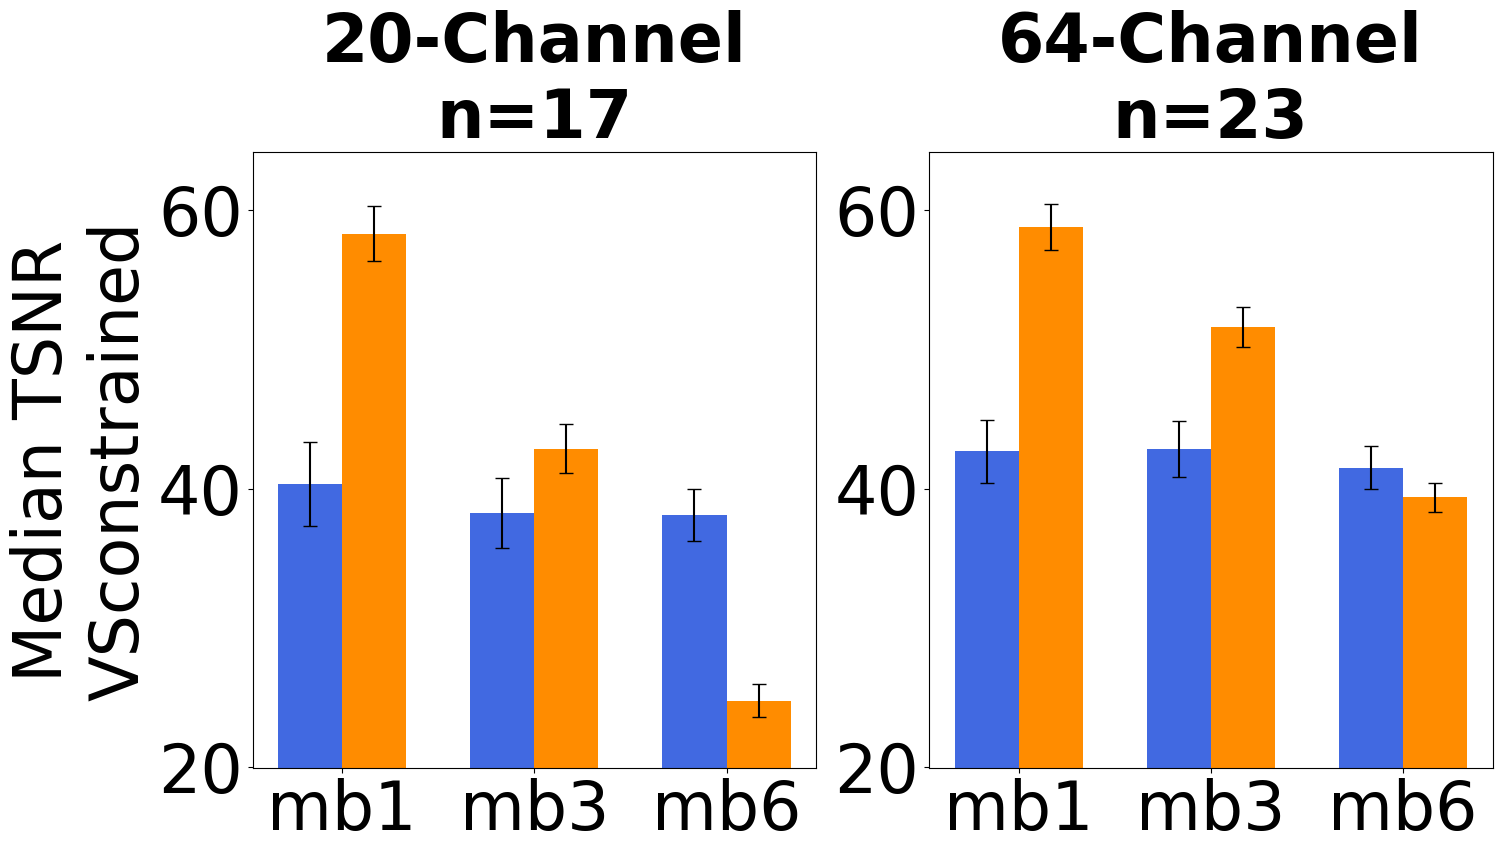

In [29]:
# Figure 5. TSNR for each acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "tsnr" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "rFFA", "bilateralMotor"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Beta

Processing files with parameters: type=act, img=beta, mask=VSconstrained, denoise=base
Using contrast: Rew>Pun
Data saved to ../derivatives/plots/multiecho_data_act_beta_VSconstrained_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
15    10017       64   -4.671750   94.225272 -104.142611 -162.286756   
14    10024       64  108.144702  171.678553  -71.579402  194.614259   
6     10035       64  177.945209   31.420981  -54.147004  346.247572   
38    10041       64  -49.422607  139.081973   60.893990  199.377341   
35    10043       64   40.083598  171.309089  261.922597  522.679206   

        mb3me4      mb6me4  
15   99.403756  -85.024436  
14  373.619278  223.327079  
6  -154.840010   11.494569  
38   85.674422  407.643753  
35  311.496890  234.641249  

Headcoil counts:
64-channel: 23
20-channel: 17


NameError: name 'axes' is not defined

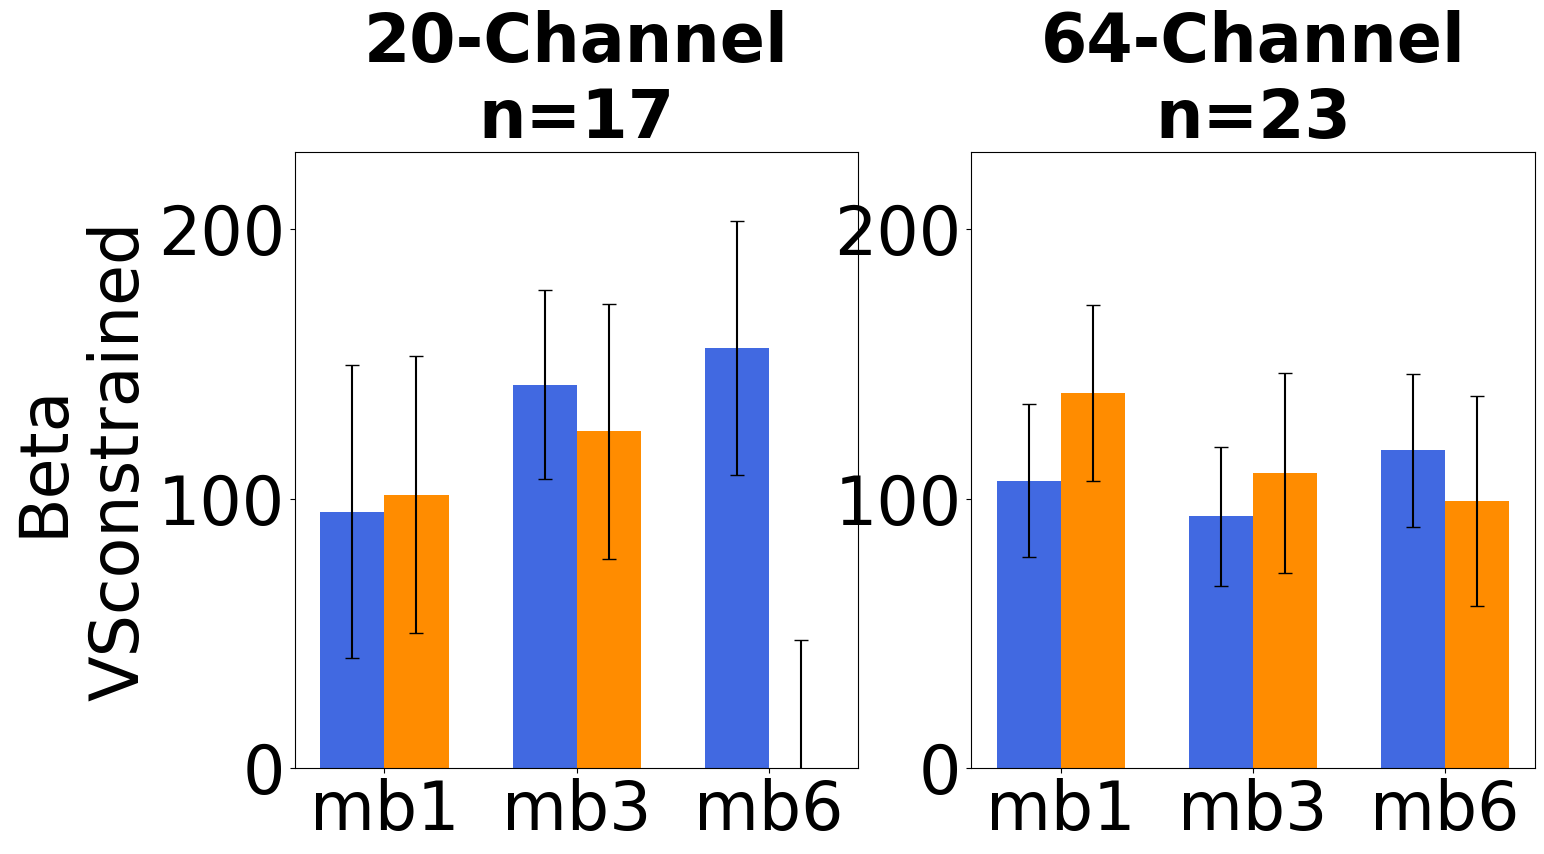

In [31]:
# Figure 6. Beta estimates for activation for each acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "rFFA", "bilateralMotor"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)


Analysis Parameters: TYPE_VALUE=ACT, IMG_VALUE=Zstat

Processing files with parameters: type=act, img=zstat, mask=VSconstrained, denoise=base
Using contrast: Rew>Pun
Data saved to ../derivatives/plots/multiecho_data_act_zstat_VSconstrained_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
25    10017       64 -0.052341  0.092611 -0.226344 -0.109317  0.125530   
32    10024       64  0.222361  0.609214 -0.343321  0.342741  1.116233   
7     10035       64  0.413395  0.157308 -0.332888  0.638243 -0.496693   
23    10041       64 -0.214285  0.464856  0.229929  0.332726  0.233385   
37    10043       64  0.063261  0.582494  1.209953  0.798848  0.840201   

      mb6me4  
25 -0.068198  
32  0.733408  
7   0.036513  
23  1.281765  
37  0.677401  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1      0
mb1me4      0

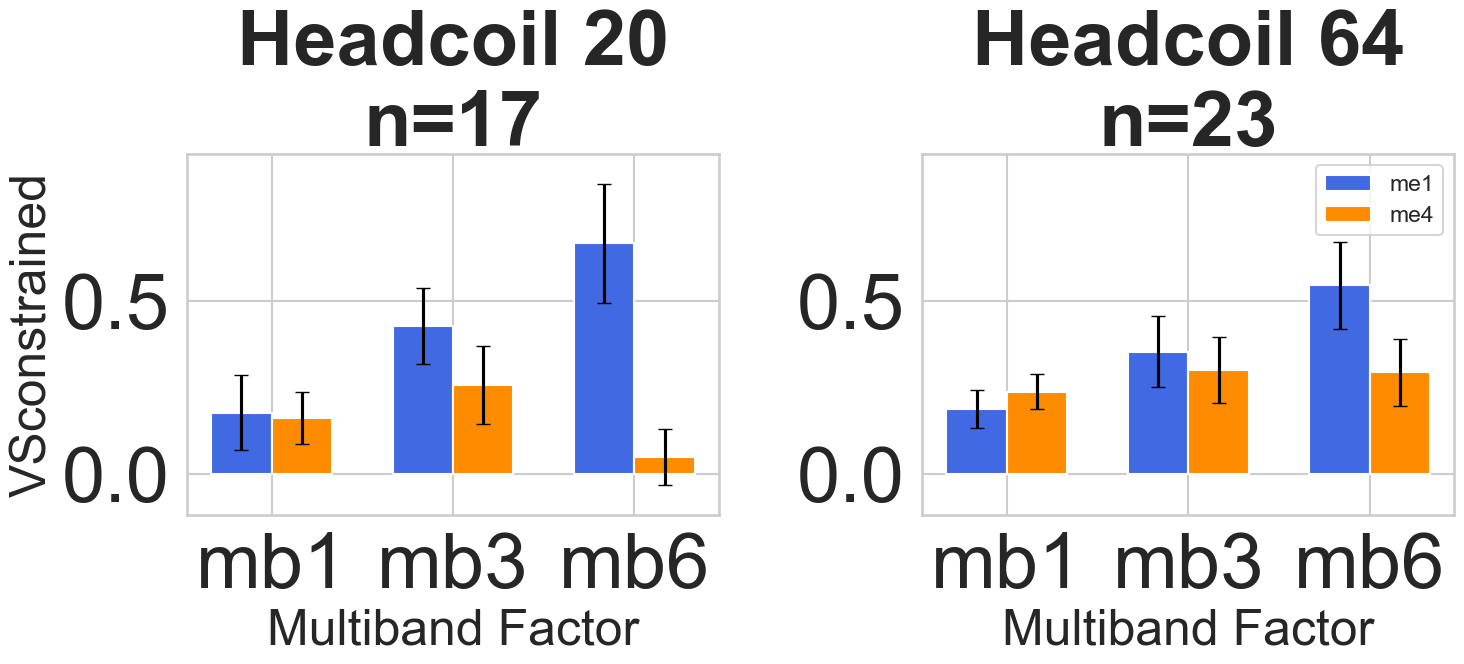


Processing files with parameters: type=act, img=zstat, mask=VMPFC, denoise=base
Using contrast: Rew>Pun
Data saved to ../derivatives/plots/multiecho_data_act_zstat_VMPFC_base_RewgtPun.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
2     10017       64 -0.709973  0.434254 -0.653981  0.399178 -0.726099   
36    10024       64 -0.550472 -0.092316 -0.420609  0.737697  0.720531   
13    10035       64  0.089808  0.477275  1.011197  0.127986  0.243046   
39    10041       64 -0.054656  0.019083  0.138309  0.241234 -1.078457   
21    10043       64 -0.860705  0.826497  0.737279  0.735896  0.310093   

      mb6me4  
2   0.584798  
36  0.741641  
13  0.947028  
39  0.340102  
21  0.442228  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1      0
mb1me4      0
mb3me4      0
mb6me4      0
dtype: int64

Running statistical analysi

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   mb1    mb3   0.0891 0.5497 -0.1121 0.2903  False
   mb1    mb6   0.2719 0.0046  0.0707 0.4731   True
   mb3    mb6   0.1828 0.0836 -0.0184  0.384  False
---------------------------------------------------

Running R-based EMM analysis for VMPFC (zstat)...

===== Joint Tests for 3-Way Interaction =====
 model term     df1 df2 F.ratio p.value
 headcoil         1  38   0.016  0.8995
 mb               2 190   4.670  0.0105
 me               1 190   0.091  0.7629
 headcoil:mb      2 190   0.801  0.4502
 headcoil:me      1 190   0.511  0.4756
 mb:me            2 190   0.563  0.5706
 headcoil:mb:me   2 190   1.775  0.1723

Debug: After mapping, emm_df shape: (12, 8)
Debug: After mapping, emm_df columns: ['mb', 'me', 'headcoil', 'emmean', 'SE', 'df', 'lower.CL', 'upper.CL']
Debug: After mapping, emm_df head:
    mb   me headcoil    emmea

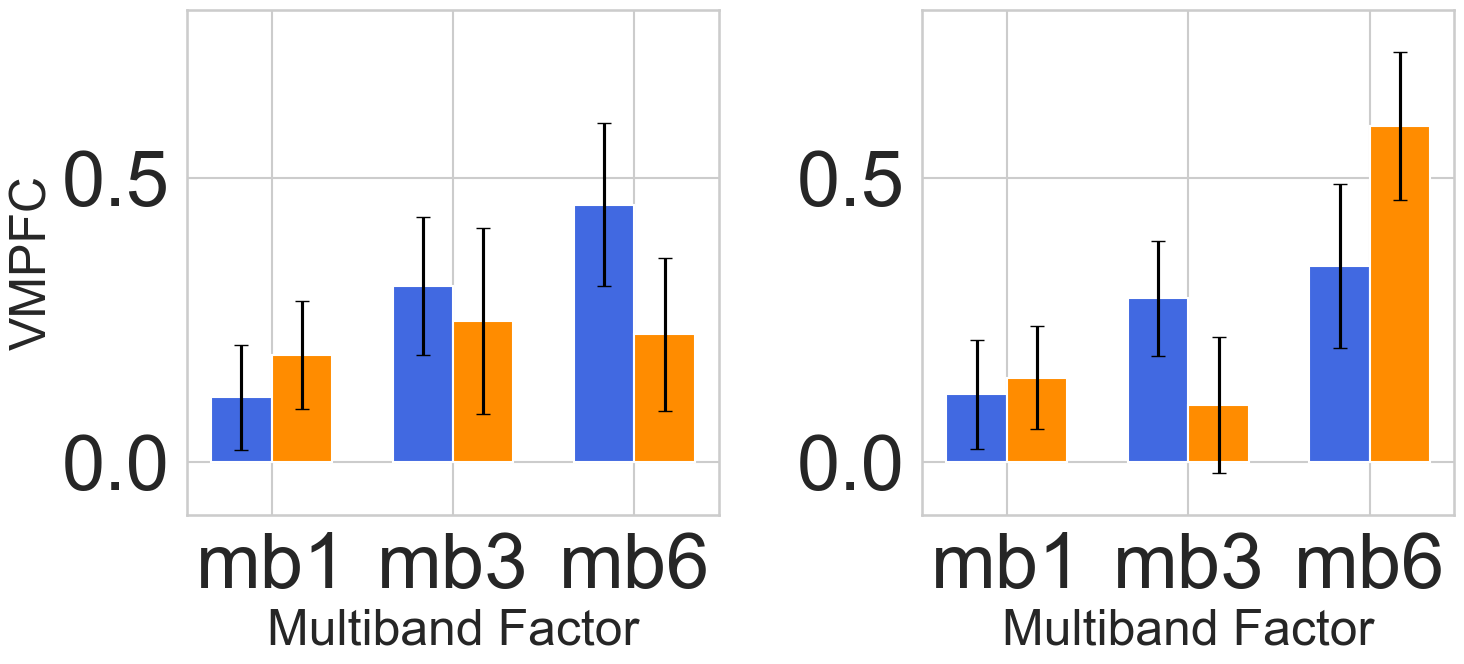


Processing files with parameters: type=act, img=zstat, mask=rFFA, denoise=base
Using contrast: Str>Com
Data saved to ../derivatives/plots/multiecho_data_act_zstat_rFFA_base_StrgtCom.csv
Found data for 40 subjects

Sample of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
28    10017       64  0.337843 -0.175917 -0.896624  0.158943  0.583400   
4     10024       64  1.626856  1.795230  1.589392  1.829804  0.894164   
24    10035       64 -0.654657  0.105597 -1.011226  0.093744  1.118368   
25    10041       64 -0.100881  0.112345  0.845002  0.581439  0.479374   
9     10043       64  0.667597  1.408967 -0.032406  0.445072  2.225275   

      mb6me4  
28  0.399349  
4   1.025648  
24  0.414418  
25  1.896115  
9   2.594905  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1      0
mb1me4      0
mb3me4      0
mb6me4      0
dtype: int64

Running statistical analysis 

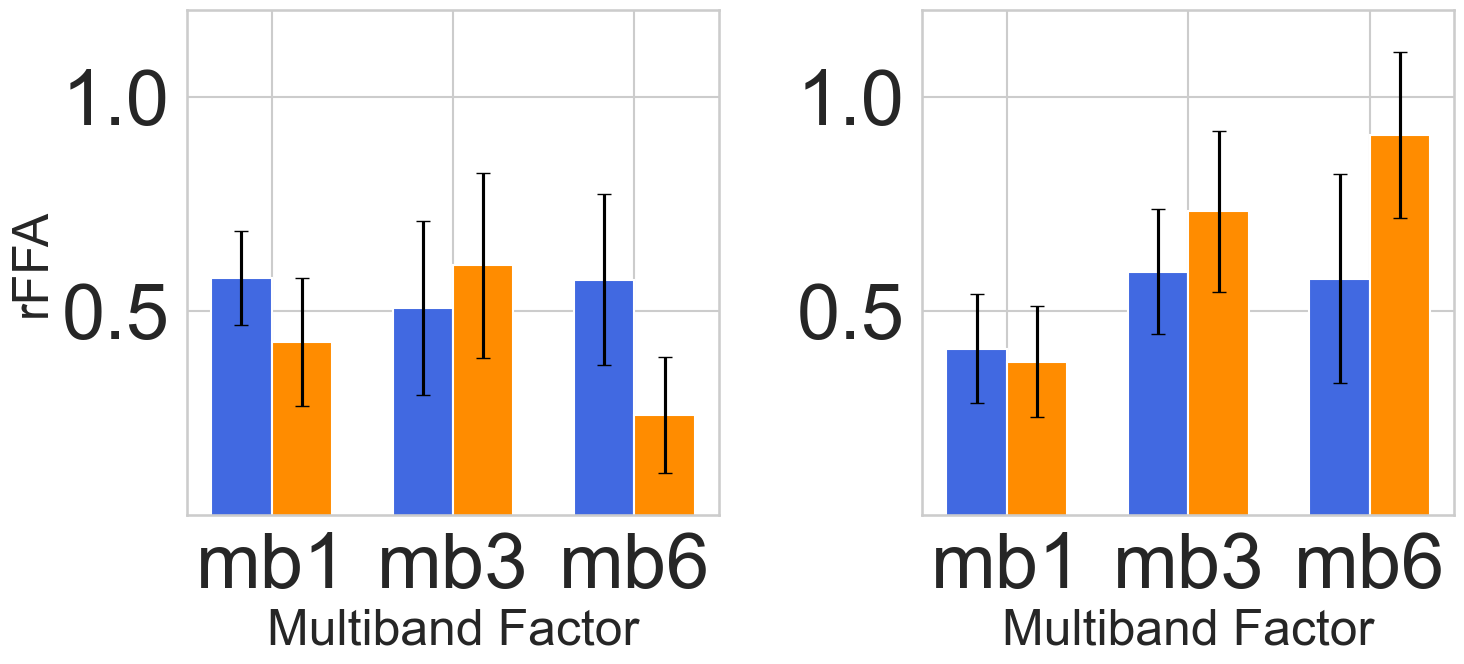


Processing files with parameters: type=act, img=zstat, mask=bilateralMotor, denoise=base
Using contrast: Avg (L>R, R>L)
Data saved to ../derivatives/plots/multiecho_data_act_zstat_bilateralMotor_base_Avg_(LgtR_RgtL).csv
Found data for 40 subjects

Sample of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
23    10017       64  0.186017 -0.118962 -0.582138 -0.281558  0.088459   
14    10024       64  0.068522  0.295420  0.670584  0.579380  1.138800   
31    10035       64 -0.705555 -0.303153  0.542330  0.351943  0.367168   
36    10041       64  0.537035  0.946837 -0.027800  0.229623  0.597164   
18    10043       64  1.056790  1.892270  2.450630  1.001350  1.644320   

      mb6me4  
23  0.212144  
14  1.251740  
31  0.670695  
36  0.871188  
18  2.730510  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1      0
mb1me4      2
mb3me4      0
mb6me4      0
dtype: in

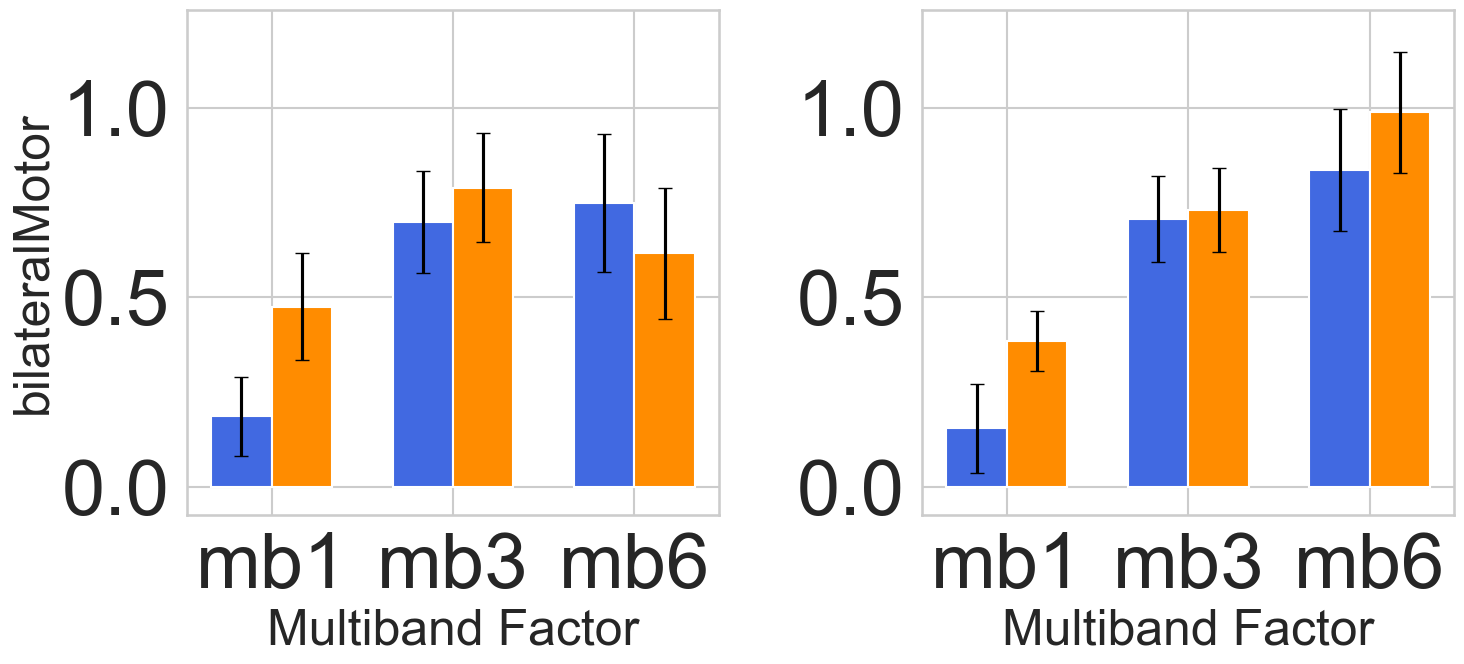


Processing files with parameters: type=act, img=zstat, mask=bilateralCerebellum, denoise=base
Using contrast: Avg (L>R, R>L)
Data saved to ../derivatives/plots/multiecho_data_act_zstat_bilateralCerebellum_base_Avg_(LgtR_RgtL).csv
Found data for 40 subjects

Sample of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
27    10017       64  0.159425 -0.073853 -0.740084 -0.472118  0.266526   
23    10024       64 -0.172129  0.482047  1.137600  0.803758  0.565260   
8     10035       64 -0.344368  0.430193  0.158513  0.648957  0.390335   
20    10041       64 -0.127824  0.536176  0.328442 -0.133032  0.232956   
26    10043       64 -0.219089  0.980414  0.953471  1.262250  0.755720   

      mb6me4  
27  0.284641  
23  0.609316  
8   0.310305  
20  0.737442  
26  1.347250  

Headcoil counts:
64-channel: 23
20-channel: 17
Missing values per column:
subject     0
headcoil    0
mb1me1      0
mb3me1      0
mb6me1      0
mb1me4      2
mb3me4      0
mb6me4      0

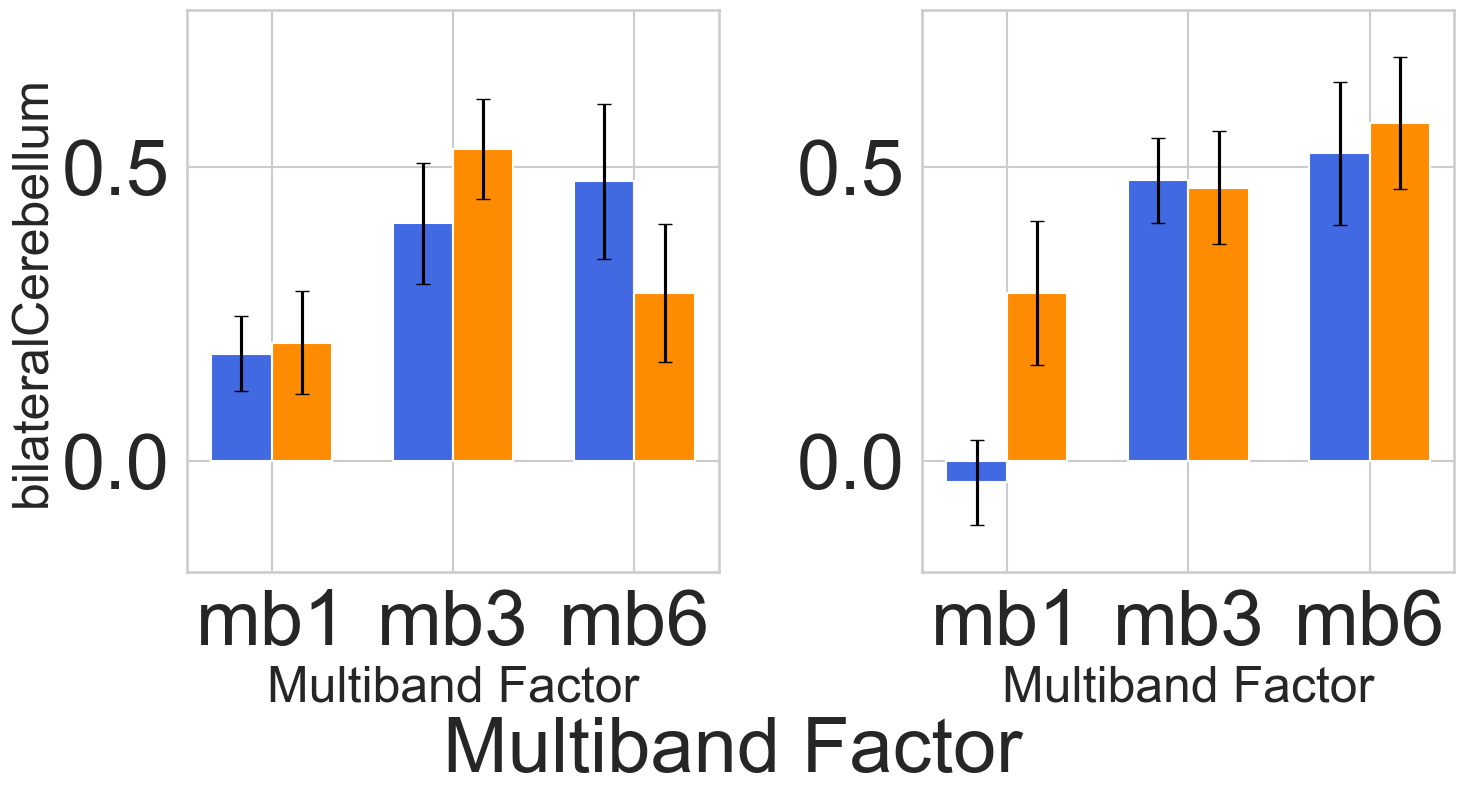

In [9]:
# Supp. Figure 6. zstats for activation for each acquisition in each ROI
TYPE_VALUE = "act" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "zstat" # "tsnr" "beta" "zstat"
MASK_VALUES = ["VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)

In [ ]:
# LME: ME
TYPE_VALUE = "ppi_seed-VS_thr5" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["MEbonf"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)

In [ ]:
# LME: HC x ME
TYPE_VALUE = "ppi_seed-VS_thr5" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["HCxMEbonf"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)

In [ ]:
# LME: 3way
TYPE_VALUE = "ppi_seed-VS_thr5" # "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta" # "tsnr" "beta" "zstat"
MASK_VALUES = ["3waybonf"] # "VSconstrained", "VMPFC", "rFFA", "bilateralMotor", "bilateralCerebellum"
DENOISE_VALUE = "base" # "base" "tedana"

# Run the analysis with the new parameters
results = run_analysis(TYPE_VALUE, IMG_VALUE, MASK_VALUES, DENOISE_VALUE)

# Fig 8. Analysis of Tedana vs. Base Denoising Effects with Framewise Displacement

This combined code chunk processes framewise displacement (FD) data and fMRI metric differences between two denoising methods (Tedana and a baseline) across multiecho acquisitions (mb1me4, mb3me4, mb6me4), then visualizes the relationship between FD and denoising effects using scatter plots. It consists of two parts: (1) calculating average FD values per subject and acquisition, and (2) extracting, processing, and plotting the denoising differences with FD.

### Key Components
1. **FD Preprocessing (Part 1)**:
   - Loads a TSV file containing FD data (e.g., `Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv`).
   - Filters out subjects ending in `sp` and acquisitions with `me1`, retaining only `me4` data.
   - Saves filtered data as `fd_mean_values.csv`.
   - Groups data by subject and acquisition (e.g., `mb1me4`), computes mean `fd_mean` values, and saves results to `fd_mean_averages.xlsx`.

2. **Data Extraction and Difference Calculation (Part 2)**:
   - `extract_file_data_with_difference`: 
     - Parses text files in a directory (e.g., `~/Documents/GitHub/multiecho-pilot/derivatives/extractions`) matching a regex pattern.
     - Extracts metric values (e.g., beta) for specified denoising methods (`denoise_tedana`, `denoise_base`) across acquisitions (mb1me4, mb3me4, mb6me4).
     - Computes differences (`tedana - base`) per subject and acquisition, handling missing data with NaNs.

3. **Data Merging (Part 2)**:
   - `create_dataframe_with_fd`: 
     - Constructs a DataFrame from difference data, adding headcoil assignments (20 or 64 channels) based on a predefined subject list.
     - Merges with FD data from `fd_mean_values.csv`, aligning on subject and acquisition.
     - Reshapes to long format with columns: `subject`, `headcoil`, `acq`, `tedana_minus_base`, and `fd_mean`.

4. **Visualization (Part 2)**:
   - `create_scatter_plots`: 
     - Generates two sets of scatter plots (one per acquisition):
       - **Set 1**: Splits by headcoil (red for 20, green for 64), with regression lines per headcoil.
       - **Set 2**: Combines all data (blue dots), with a single regression line.
     - X-axis: Mean FD; Y-axis: Tedana minus base difference; Subplots: One per acquisition.
   - `initialize_plotting_engine`: Sets large fonts and a whitegrid style for readability.

5. **Execution (Part 2)**:
   - `process_and_visualize_tedana_difference`: 
     - Orchestrates the workflow: extracts differences, merges with FD, and creates plots.
     - Saves merged data as CSV and plots as PNG if `save_files=True`.

### Inputs
- **Part 1**:
  - `input_file`: TSV file with FD data (e.g., `~/.../Outlier-info_mriqc-0.16.1.tsv`).
- **Part 2**:
  - `base_dir`: Directory with fMRI text files (default: `~/.../extractions`).
  - `type_value`: Analysis type (e.g., `act`).
  - `img_value`: Metric (e.g., `beta`).
  - `mask_value`: ROI (e.g., `VSconstrained`).
  - `denoise_tedana`, `denoise_base`: Denoising methods (e.g., `tedana`, `smooth`).
  - `fd_csv_path`: Path to FD CSV (default: `fd_mean_values.csv` from Part 1).
  - `acq_params`: Acquisitions (default: `["mb1me4", "mb3me4", "mb6me4"]`).
  - `headcoil_64_subjects`: List of subjects with 64-channel headcoils.

### Outputs
- **Part 1**:
  - `fd_mean_values.csv`: Filtered FD data.
  - `fd_mean_averages.xlsx`: Averaged FD per subject and acquisition.
- **Part 2**:
  - **DataFrame**: Saved as `multiecho_tedana_minus_base_<type>_<img>_<mask>.csv`.
  - **Plots**: Two PNG files (e.g., `tedana_minus_base_scatter_<type>_<img>_<mask>.png`) with headcoil-split and combined scatter plots.

### Notes
- Assumes `me4` acquisitions are the focus; `me1` data is excluded.
- Handles missing data by skipping invalid files and reporting NaNs in merges.
- Plot aesthetics (e.g., font size=56, dot size=300) are optimized for publication clarity.
- The two parts are interdependent: Part 1 generates FD data used by Part 2.

This workflow supports Figure 8 by linking head motion (FD) to denoising effects across acquisition types and headcoils, providing visual and tabular insights into data quality trade-offs.

In [ ]:
# Figure 8 Part 1, Generate avg fd_mean values for each ME acq
import pandas as pd

# Define file paths
input_file = "~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv"
output_file = "~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv"

# Load the TSV file
df = pd.read_csv(input_file, sep="\t")

# Filter out subjects ending in 'sp' and acquisitions containing 'me1'
df = df[~df['Sub'].str.endswith('sp')]
df = df[~df['acq'].str.contains('me1', na=False)]

# Save the filtered DataFrame to a CSV file
df.to_csv(output_file, index=False)

#print("Filtered data saved to:", output_file)

import pandas as pd

# Load your spreadsheet data
df = pd.read_csv(output_file)

# Extract the base 'acq' substring (e.g., mb1me4, mb3me4, mb6me4) from the 'acq' column
df['acq_base'] = df['acq'].str.extract(r'(mb\dme4)')

# Group by 'Sub' and 'acq_base' and calculate the average of 'fd_mean' for each group
averages = df.groupby(['Sub', 'acq_base'])['fd_mean'].mean().reset_index()

# Save the results to a new spreadsheet
output_file_path = 'fd_mean_averages.xlsx'  # Replace with your desired output file path
averages.to_excel(output_file_path, index=False)

# Optionally, print the averages to verify
print(averages)


In [ ]:
# Figure 8 part 2, define function for Figure 8 plots

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")
    # Significantly increase font size
    plt.rcParams.update({'font.size': 56})

def extract_file_data_with_difference(base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params):
    """Extract data and calculate differences between denoise methods for given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    print(f"Found {len(file_paths)} files in {base_dir}")
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or acq not in acq_params:
                continue
            if (file_type == type_value and img == img_value and mask == mask_value and 
                denoise in [denoise_tedana, denoise_base]):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {
                            denoise: {acq_param: np.nan for acq_param in acq_params}
                            for denoise in [denoise_tedana, denoise_base]
                        }
                    data_by_subject[sub_id][denoise][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    print(f"Subjects with data: {len(data_by_subject)}")
    
    diff_by_subject = {}
    for sub_id, data in data_by_subject.items():
        diff_by_subject[sub_id] = {}
        for acq in acq_params:
            tedana_val = data[denoise_tedana].get(acq, np.nan)
            base_val = data[denoise_base].get(acq, np.nan)
            diff = tedana_val - base_val if not (np.isnan(tedana_val) or np.isnan(base_val)) else np.nan
            diff_by_subject[sub_id][acq] = diff
    
    return diff_by_subject

def create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects):
    """Create and merge DataFrame with framewise displacement data"""
    df = pd.DataFrame.from_dict(diff_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['subject'] = df['subject'].astype(str)
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in headcoil_64_subjects else 20)
    column_order = ['subject', 'headcoil'] + acq_params
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    df_long = df.melt(id_vars=['subject', 'headcoil'], value_vars=acq_params, 
                      var_name='acq', value_name='tedana_minus_base')
    
    fd_df = pd.read_csv(fd_csv_path)
    fd_df = fd_df.rename(columns={'Sub': 'subject', 'acq_base': 'acq'})
    fd_df['subject'] = fd_df['subject'].str.replace('sub-', '', regex=False)
    fd_df['acq'] = fd_df['acq'].str.extract(r'(mb[1-6]me\d)')
    
    df_merged = pd.merge(df_long, fd_df[['subject', 'acq', 'fd_mean']], 
                         on=['subject', 'acq'], how='left')
    
    nan_count = df_merged['fd_mean'].isna().sum()
    print(f"\nNumber of NaN fd_mean values after merge: {nan_count} out of {len(df_merged)} rows")
    
    return df_merged

def create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base):
    """Create two batches of scatter plots:
       1. Split by headcoil (red for 20, green for 64)
       2. No split by headcoil (blue dots)
    """
    fig, axes = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)

    # Colors for headcoil scatter plots
    colors = {20: 'red', 64: 'green'}
    legend_handles = []

    for i, acq in enumerate(acq_params):
        ax = axes[i]
        acq_data = df[df['acq'] == acq]

        # Scatter plot with headcoil split
        scatter = sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            hue='headcoil', palette=colors, ax=ax, s=300  # Larger dots
        )

        # Capture legend handles for later use
        if i == 0:
            legend_handles = scatter.legend_.legendHandles

        # Regression lines for each headcoil
        for hc in [20, 64]:
            hc_data = acq_data[acq_data['headcoil'] == hc]
            if len(hc_data) > 1:  # Need at least 2 points for regression
                sns.regplot(x='fd_mean', y='tedana_minus_base', data=hc_data,
                            scatter=False, ax=ax, color=colors[hc], line_kws={'linewidth': 3})

        # Set title for each subplot
        ax.set_title(f'{acq}', fontsize=64, fontweight='bold')

        # Only add y-label to the first subplot
        if i == 0:
            ax.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax.set_ylabel('')

        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=56)

        # Remove individual legends
        ax.legend().remove()

        # Remove redundant x-labels (fd_mean under each plot)
        ax.set_xlabel('')

    # Fine-tuned x-axis label position (closer to ticks)
    fig.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)

    # Adjust layout to make space for the legend
    plt.subplots_adjust(right=0.8)

    # Add a single legend outside the plots (with smaller text and simple labels)
    fig.legend(legend_handles, ['20', '64'], title='Headcoil',
               loc='center left', bbox_to_anchor=(1, 0.5), fontsize=28, title_fontsize=28)

    plt.tight_layout()

    # Create second batch of plots (no headcoil split, all dots blue)
    fig2, axes2 = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)

    for i, acq in enumerate(acq_params):
        ax2 = axes2[i]
        acq_data = df[df['acq'] == acq]

        # Scatter plot (all blue)
        sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            color='blue', ax=ax2, s=300
        )

        # Regression line for all data points
        if len(acq_data) > 1:
            sns.regplot(x='fd_mean', y='tedana_minus_base', data=acq_data,
                        scatter=False, ax=ax2, color='blue', line_kws={'linewidth': 3})

        ax2.set_title(f'{acq}', fontsize=64, fontweight='bold')

        # Only add y-label to the first subplot
        if i == 0:
            ax2.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax2.set_ylabel('')

        ax2.tick_params(axis='both', which='major', labelsize=56)

        # Remove redundant x-labels
        ax2.set_xlabel('')

    # Fine-tuned x-axis label for second batch
    fig2.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)

    plt.tight_layout()

    return fig, fig2


def process_and_visualize_tedana_difference(type_value, img_value, mask_value, denoise_tedana, denoise_base, 
                                           base_dir=None, fd_csv_path=None, acq_params=None, 
                                           headcoil_64_subjects=None, save_files=True):
    """Run the full analysis for tedana-base difference visualization"""
    # Define default values if not provided
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    
    if fd_csv_path is None:
        fd_csv_path = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv")
    
    if acq_params is None:
        acq_params = ["mb1me4", "mb3me4", "mb6me4"]
    
    if headcoil_64_subjects is None:
        headcoil_64_subjects = [
            "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
            "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
            "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
            "10186", "10188", "10221"
        ]
    
    # Initialize plotting environment
    initialize_plotting_engine()
    
    print(f"\nProcessing files for tedana - base difference: type={type_value}, img={img_value}, mask={mask_value}")
    
    # Extract data and calculate differences
    diff_by_subject = extract_file_data_with_difference(
        base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params
    )
    
    if not diff_by_subject:
        print("No matching files found.")
        return None
    
    # Create and merge DataFrame with FD data
    df = create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects)
    
    if save_files:
        # Save to CSV
        output_file = f"multiecho_tedana_minus_base_{type_value}_{img_value}_{mask_value}.csv"
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df['subject'].unique())} subjects")
    
    # Display the first few rows
    print("\nSample of the merged data:")
    print(df.head())
    
    # Create scatter plots
    print("\nCreating scatter plots...")
    fig = create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base)
    
    if save_files:
        # Save the plot
        plot_file = f"tedana_minus_base_scatter_{type_value}_{img_value}_{mask_value}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return {
        'dataframe': df,
        'figure': fig
    }



Processing files for tedana - base difference: type=act, img=zstat, mask=VSconstrained
Found 11361 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Subjects with data: 40

Number of NaN fd_mean values after merge: 45 out of 345 rows
Data saved to multiecho_tedana_minus_base_act_zstat_VSconstrained.csv
Found data for 40 subjects

Sample of the merged data:
  subject  headcoil     acq  tedana_minus_base   fd_mean
0   10017        64  mb1me4          -0.006158  0.065809
1   10017        64  mb1me4          -0.006158  0.065809
2   10017        64  mb1me4          -0.006158  0.065809
3   10017        64  mb1me4          -0.006158  0.065809
4   10024        64  mb1me4           0.071574       NaN

Creating scatter plots...


AttributeError: 'Legend' object has no attribute 'legendHandles'

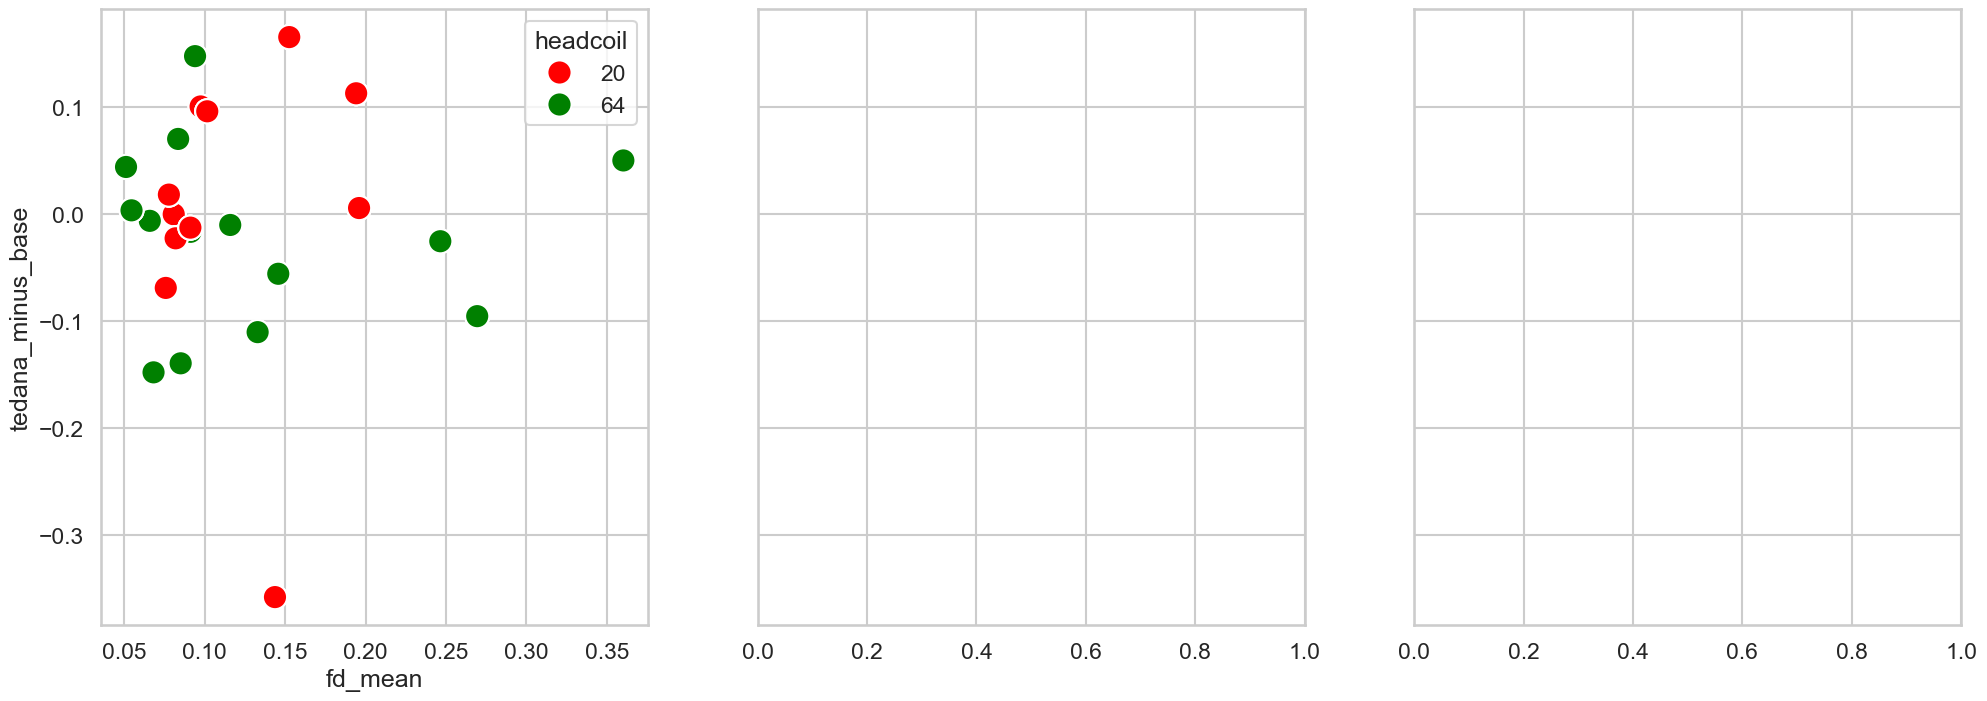

In [11]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from uuid import uuid4

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    sns.set_style("whitegrid")
    sns.set_context("talk")
    plt.rcParams.update({'font.size': 56})

def process_fd_mean_data(input_file, output_csv, output_excel):
    """Process TSV file to compute average fd_mean values for each subject and acquisition"""
    # Load the TSV file
    df = pd.read_csv(input_file, sep="\t")
    
    # Filter out subjects ending in 'sp' and acquisitions containing 'me1'
    df = df[~df['Sub'].str.endswith('sp')]
    df = df[~df['acq'].str.contains('me1', na=False)]
    
    # Save filtered data to CSV
    df.to_csv(output_csv, index=False)
    
    # Extract the base 'acq' substring (e.g., mb1me4, mb3me4, mb6me4)
    df['acq_base'] = df['acq'].str.extract(r'(mb\dme4)')
    
    # Group by 'Sub' and 'acq_base' and calculate the average of 'fd_mean'
    averages = df.groupby(['Sub', 'acq_base'])['fd_mean'].mean().reset_index()
    
    # Save averages to Excel
    averages.to_excel(output_excel, index=False)
    
    return averages

def extract_file_data_with_difference(base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params):
    """Extract data and calculate differences between denoise methods for given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    print(f"Found {len(file_paths)} files in {base_dir}")
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or acq not in acq_params:
                continue
            if (file_type == type_value and img == img_value and mask == mask_value and 
                denoise in [denoise_tedana, denoise_base]):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {
                            denoise: {acq_param: np.nan for acq_param in acq_params}
                            for denoise in [denoise_tedana, denoise_base]
                        }
                    data_by_subject[sub_id][denoise][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    print(f"Subjects with data: {len(data_by_subject)}")
    
    diff_by_subject = {}
    for sub_id, data in data_by_subject.items():
        diff_by_subject[sub_id] = {}
        for acq in acq_params:
            tedana_val = data[denoise_tedana].get(acq, np.nan)
            base_val = data[denoise_base].get(acq, np.nan)
            diff = tedana_val - base_val if not (np.isnan(tedana_val) or np.isnan(base_val)) else np.nan
            diff_by_subject[sub_id][acq] = diff
    
    return diff_by_subject

def create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects):
    """Create and merge DataFrame with framewise displacement data"""
    df = pd.DataFrame.from_dict(diff_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['subject'] = df['subject'].astype(str)
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in headcoil_64_subjects else 20)
    column_order = ['subject', 'headcoil'] + acq_params
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    df_long = df.melt(id_vars=['subject', 'headcoil'], value_vars=acq_params, 
                      var_name='acq', value_name='tedana_minus_base')
    
    fd_df = pd.read_csv(fd_csv_path)
    fd_df = fd_df.rename(columns={'Sub': 'subject', 'acq_base': 'acq'})
    fd_df['subject'] = fd_df['subject'].str.replace('sub-', '', regex=False)
    fd_df['acq'] = fd_df['acq'].str.extract(r'(mb[1-6]me\d)')
    
    df_merged = pd.merge(df_long, fd_df[['subject', 'acq', 'fd_mean']], 
                         on=['subject', 'acq'], how='left')
    
    nan_count = df_merged['fd_mean'].isna().sum()
    print(f"\nNumber of NaN fd_mean values after merge: {nan_count} out of {len(df_merged)} rows")
    
    return df_merged

def create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base):
    """Create two batches of scatter plots: split by headcoil and no split"""
    fig, axes = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)
    colors = {20: 'red', 64: 'green'}
    legend_handles = []

    for i, acq in enumerate(acq_params):
        ax = axes[i]
        acq_data = df[df['acq'] == acq]
        scatter = sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            hue='headcoil', palette=colors, ax=ax, s=300
        )
        if i == 0:
            legend_handles = scatter.legend_.legendHandles
        for hc in [20, 64]:
            hc_data = acq_data[acq_data['headcoil'] == hc]
            if len(hc_data) > 1:
                sns.regplot(x='fd_mean', y='tedana_minus_base', data=hc_data,
                            scatter=False, ax=ax, color=colors[hc], line_kws={'linewidth': 3})
        ax.set_title(f'{acq}', fontsize=64, fontweight='bold')
        if i == 0:
            ax.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=56)
        ax.legend().remove()
        ax.set_xlabel('')
    
    fig.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)
    plt.subplots_adjust(right=0.8)
    fig.legend(legend_handles, ['20', '64'], title='Headcoil',
               loc='center left', bbox_to_anchor=(1, 0.5), fontsize=28, title_fontsize=28)
    
    fig2, axes2 = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)
    for i, acq in enumerate(acq_params):
        ax2 = axes2[i]
        acq_data = df[df['acq'] == acq]
        sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            color='blue', ax=ax2, s=300
        )
        if len(acq_data) > 1:
            sns.regplot(x='fd_mean', y='tedana_minus_base', data=acq_data,
                        scatter=False, ax=ax2, color='blue', line_kws={'linewidth': 3})
        ax2.set_title(f'{acq}', fontsize=64, fontweight='bold')
        if i == 0:
            ax2.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax2.set_ylabel('')
        ax2.tick_params(axis='both', which='major', labelsize=56)
        ax2.set_xlabel('')
    
    fig2.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)
    plt.tight_layout()
    
    return fig, fig2

def process_and_visualize_tedana_difference(type_value, img_value, mask_value, denoise_tedana, denoise_base, 
                                           base_dir=None, fd_csv_path=None, acq_params=None, 
                                           headcoil_64_subjects=None, save_files=True):
    """Run the full analysis for tedana-base difference visualization"""
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    if fd_csv_path is None:
        fd_csv_path = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv")
    if acq_params is None:
        acq_params = ["mb1me4", "mb3me4", "mb6me4"]
    if headcoil_64_subjects is None:
        headcoil_64_subjects = [
            "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
            "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
            "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
            "10186", "10188", "10221"
        ]
    
    # Process fd_mean data
    input_file = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv")
    output_csv = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv")
    output_excel = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_averages.xlsx")
    process_fd_mean_data(input_file, output_csv, output_excel)
    
    # Initialize plotting
    initialize_plotting_engine()
    
    print(f"\nProcessing files for tedana - base difference: type={type_value}, img={img_value}, mask={mask_value}")
    
    # Extract data and calculate differences
    diff_by_subject = extract_file_data_with_difference(
        base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params
    )
    
    if not diff_by_subject:
        print("No matching files found.")
        return None
    
    # Create and merge DataFrame with FD data
    df = create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects)
    
    if save_files:
        output_file = f"multiecho_tedana_minus_base_{type_value}_{img_value}_{mask_value}.csv"
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df['subject'].unique())} subjects")
    print("\nSample of the merged data:")
    print(df.head())
    
    # Create scatter plots
    print("\nCreating scatter plots...")
    fig, fig2 = create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base)
    
    if save_files:
        plot_file = f"tedana_minus_base_scatter_{type_value}_{img_value}_{mask_value}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return {
        'dataframe': df,
        'figure': (fig, fig2)
    }

if __name__ == "__main__":
    # Example parameters (can be modified as needed)
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "VSconstrained"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Figure 8. VSconstrained
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "VSconstrained"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Figure 8. VMPFC
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "VMPFC"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Figure 8. rFFA
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "rFFA"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Figure 8. bilateralMotor
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "bilateralMotor"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

In [ ]:
# Figure 8. bilateralCerebellum
if __name__ == "__main__":
    # Parameters that can be changed to repurpose the script
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "bilateralCerebellum"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    # Run the analysis
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

# Fig 9. Bar Plot Analysis of fMRI Metrics for Specific Subjects

This code chunk defines functions to extract, process, and visualize fMRI metric data (e.g., beta values) from text files for a subset of subjects (those with `sp` in their IDs) across specified multiecho acquisition parameters (e.g., mb1me1, mb3me4). It generates a bar plot summarizing mean values and standard errors for a given region of interest (ROI) and metric, focusing on acquisition effects.

### Key Components
1. **Data Extraction**:
   - `extract_file_data`: 
     - Scans a directory (e.g., `base_dir`) for text files matching a regex pattern (`ts_sub-<ID>_acq_<...>.txt`).
     - Filters files by `type_value` (e.g., `act`), `img_value` (e.g., `beta`), `mask_value` (e.g., `VSconstrained`), `denoise_value` (e.g., `smooth`), and a list of `acq_params`.
     - Extracts float values for subjects with `sp` in their IDs, storing data in a dictionary by subject and acquisition.

2. **Data Structuring**:
   - `create_dataframe`: 
     - Converts the extracted data into a wide-format DataFrame with columns: `subject` and the specified `acq_params`.
     - Sorts by subject ID for consistency.

3. **Data Aggregation**:
   - `prepare_plot_data`: 
     - Computes means and standard errors of the metric for each acquisition parameter.
     - Returns a dictionary with results and the total subject count.

4. **Visualization**:
   - `create_bar_plot`: 
     - Generates a bar plot with lavender bars, showing mean metric values across acquisitions, with error bars (standard errors).
     - Customizes aesthetics: large fonts (e.g., title=48, labels=40), rotated x-tick labels, and dynamic y-axis limits.
   - Y-axis: Labeled with the ROI and metric (e.g., `VSconstrained, beta`); X-axis: Acquisition types.

5. **Execution**:
   - `process_and_visualize`: 
     - Runs the full pipeline: extracts data, creates a DataFrame, prepares plot data, and generates the bar plot.
     - Saves the DataFrame as a CSV and the plot as a PNG with descriptive filenames.

### Inputs
- `base_dir`: Directory containing fMRI text files (e.g., `~/Documents/GitHub/multiecho-pilot/derivatives/extractions`).
- `acq_params`: List of acquisitions (e.g., `["mb1me1", "mb3me4", "mb6me4"]`).
- `type_value`: Analysis type (e.g., `act` for activation).
- `img_value`: Metric to analyze (e.g., `beta`).
- `mask_value`: ROI (e.g., `VSconstrained`).
- `denoise_value`: Denoising method (e.g., `smooth`).

### Outputs
- **DataFrame**: Saved as `multiecho_data_<type>_<img>_<mask>_<denoise>.csv`, with subject IDs and metric values per acquisition.
- **Plot**: Bar plot saved as `multiecho_plots_<type>_<img>_<mask>_<denoise>.png`, showing means and errors across acquisitions.
- **Returns**: Processed DataFrame and matplotlib figure object.

### Notes
- Only processes subjects with `sp` in their IDs (e.g., special pilot subjects), excluding others.
- Handles missing or invalid files by skipping them and reporting errors, with NaNs for unmatched acquisitions.
- Plot design (lavender bars, whitegrid style) is optimized for clarity and publication quality.
- Assumes text files contain a single float value; errors are printed for debugging.

This chunk supports Figure 9 by summarizing fMRI metrics for a specific subject group across acquisition types, providing a visual and tabular representation of data quality or effect sizes.

In [ ]:
# Define functions for Figure 9

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# Activate pandas-R conversion
pandas2ri.activate()

# Import R packages
base = importr('base')
lme4 = importr('lme4')
emmeans = importr('emmeans')
ggplot2 = importr('ggplot2')

def extract_file_data(base_dir, acq_params, type_value, img_value, mask_value, denoise_value):
    """
    Extracts numerical data from text files matching specified parameters.
    
    Parameters:
    - base_dir: Path to the directory containing text files.
    - acq_params: List of acquisition parameters to include.
    - type_value, img_value, mask_value, denoise_value: Filtering criteria for filenames.
    
    Returns:
    - data_by_subject: Dictionary with subjects as keys and acquisition data as values.
    """
    pattern = re.compile(
        r"ts_sub-(\d+[a-zA-Z]*)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )

    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    matched_files = 0
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' not in sub_id:
                continue
            if (file_type.lower() == type_value.lower() and 
                img.lower() == img_value.lower() and 
                mask.lower() == mask_value.lower() and 
                denoise.lower() == denoise_value.lower() and 
                acq in acq_params):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                    matched_files += 1
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")

    print(f"Total matched files: {matched_files}")
    return data_by_subject

def create_dataframe(data_by_subject, acq_params):
    """
    Converts extracted data into a structured DataFrame.

    Parameters:
    - data_by_subject: Dictionary with extracted numerical values.
    - acq_params: List of acquisition parameters (column order).
    
    Returns:
    - df: DataFrame with subject IDs and extracted values.
    """
    df = pd.DataFrame.from_dict(data_by_subject, orient='index').reset_index()
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    column_order = ['subject'] + acq_params
    df = df[column_order].sort_values('subject')
    
    return df

def prepare_plot_data(df, acq_params):
    """
    Computes means and standard errors for each acquisition parameter.

    Parameters:
    - df: DataFrame containing extracted values.
    - acq_params: List of acquisition parameters.

    Returns:
    - results: Dictionary with mean values, errors, and subject count.
    """
    means = {acq: df[acq].mean() for acq in acq_params}
    errors = {acq: df[acq].sem() for acq in acq_params}
    return {'means': means, 'errors': errors, 'count': len(df)}

def create_bar_plot(plot_data, acq_params, title, y_label):
    """
    Creates a formatted bar plot with error bars.

    Parameters:
    - plot_data: Dictionary with mean values, errors, and subject count.
    - acq_params: List of acquisition parameters.
    - title: Plot title.
    - y_label: Y-axis label.

    Returns:
    - fig: The created matplotlib figure.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.set_context("talk")

    means = [plot_data['means'][acq] for acq in acq_params]
    errors = [plot_data['errors'][acq] for acq in acq_params]
    
    x_positions = np.arange(len(acq_params))
    ax.bar(x_positions, means, color='lavender', yerr=errors, capsize=5, width=0.8)

    ax.set_ylabel(y_label, fontsize=40)
    ax.set_title(title, fontsize=48, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(acq_params, fontsize=32, rotation=45, ha='right')
    ax.set_xlabel('Acquisition', fontsize=40)
    ax.tick_params(axis='both', labelsize=32)
 
    # Adjust y-axis limits dynamically
    y_min = min([v - e for v, e in zip(means, errors) if not np.isnan(v)])
    y_max = max([v + e for v, e in zip(means, errors) if not np.isnan(v)])
    margin = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - margin, y_max + margin)

    plt.tight_layout()
    return fig

def create_emm_line_plot(emm_df, mask_value, output_dir, type_value, img_value, denoise_value):
    """
    Create a line plot for estimated marginal means and save as PNG.

    Parameters:
    - emm_df: DataFrame with EMM data.
    - mask_value: Mask value for labeling.
    - output_dir: Directory to save the plot.
    - type_value, img_value, denoise_value: Parameters for filename.

    Returns:
    - fig: The created matplotlib figure.
    """
    plt.rcParams.update({'font.size': 56})
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define colors for each acquisition parameter
    # Define colors for each acquisition parameter
    acq_params = sorted(emm_df['acq'].unique())
    custom_labels = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]
    lavender_color = '#800080'

    # Plot EMMs for each acquisition parameter
    for acq in acq_params:
        acq_data = emm_df[emm_df['acq'] == acq]
        if not acq_data.empty:
            emmean = acq_data['emmean'].values[0]
            se = acq_data['SE'].values[0]
            x_pos = acq_params.index(acq)
            ax.errorbar([x_pos], [emmean], yerr=[se], fmt='o', color=lavender_color, capsize=8, capthick=4, elinewidth=3, markersize=15)

    # Connect points with a line
    x_positions = np.arange(len(acq_params))
    emmeans = [emm_df[emm_df['acq'] == acq]['emmean'].values[0] for acq in acq_params]
    ax.plot(x_positions, emmeans, color=lavender_color, linewidth=5, linestyle='-')

    # Set labels and ticks
    ax.set_title(f"SP Subjects (n={emm_df['df'].iloc[0]:.0f})", fontsize=56, fontweight='bold')
    ax.set_ylabel(f"{mask_value} EMMs", fontsize=56)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(custom_labels, fontsize=32, rotation=45, ha='right')
    ax.set_xlabel("Acquisition", fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=32)

    # Revised y-limit logic to prevent cutting off error bars
    y_values = emm_df['emmean'].values
    y_errors = emm_df['SE'].values
    if y_values.size > 0:
        y_upper = max(y_values + y_errors)
        y_lower = min(y_values - y_errors)
        padding = (y_upper - y_lower) * 0.1
        ax.set_ylim(y_lower - padding, y_upper + padding)
    else:
        ax.set_ylim(0, 1)

    
    plt.tight_layout()
    if output_dir:
        plot_file = os.path.join(output_dir, f"emm_plot_{type_value}_{img_value}_{mask_value}_{denoise_value}.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"EMM plot saved as '{plot_file}'")
    plt.close()  # Close the figure to prevent rendering in the notebook
    return fig

def process_and_visualize(base_dir, acq_params, type_value, img_value, mask_value, denoise_value, output_dir="../derivatives/plots"):
    """
    Full pipeline to extract, process, visualize data, and perform statistical analysis.

    Parameters:
    - base_dir: Path to data files.
    - acq_params: List of acquisition parameters.
    - type_value, img_value, mask_value, denoise_value: Filtering criteria.
    - output_dir: Directory to save outputs.

    Returns:
    - df: Processed DataFrame.
    - fig: Bar plot figure.
    - emm_fig: EMM plot figure.
    - lmm_result: Linear mixed-effects model result.
    """
    print(f"Processing files with parameters: type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}")
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract data
    data_by_subject = extract_file_data(base_dir, acq_params, type_value, img_value, mask_value, denoise_value)
    
    if not data_by_subject:
        print("No matching files found.")
        return pd.DataFrame(columns=['subject'] + acq_params), plt.figure(), plt.figure(), None
    
    # Create DataFrame
    df = create_dataframe(data_by_subject, acq_params)
    output_file = os.path.join(output_dir, f"multiecho_data_{type_value}_{img_value}_{mask_value}_{denoise_value}.csv")
    df.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")

    print(f"Found data for {len(df)} subjects")
    print("\nSample of the data:")
    print(df.head())
    print(f"Missing values per column:\n{df.isnull().sum()}")

    # Reshape data for statistical analysis
    df_long = pd.melt(
        df, 
        id_vars=['subject'], 
        value_vars=acq_params,
        var_name='acq', 
        value_name=img_value
    )
    df_long['acq'] = pd.Categorical(df_long['acq'], categories=acq_params, ordered=True)

    # Run Python-based linear mixed-effects model
    print(f"\nRunning statistical analysis for {mask_value} ({img_value})...")
    df_long_clean = df_long.dropna(subset=[img_value])
    if len(df_long_clean) < 2:
        print(f"Insufficient data for LMM after removing NaNs: {len(df_long_clean)} observations")
        result = None
    else:
        try:
            model = smf.mixedlm(f"{img_value} ~ acq", df_long_clean, groups=df_long_clean["subject"])
            result = model.fit()
            print(result.summary())
            
            # Pairwise comparisons for acq
            print(f"\nPairwise comparisons for acquisition parameters:")
            tukey_acq = pairwise_tukeyhsd(endog=df_long_clean[img_value], groups=df_long_clean['acq'], alpha=0.05)
            print(tukey_acq)
        except Exception as e:
            print(f"LMM failed: {e}")
            print(f"Shape of df_long_clean: {df_long_clean.shape}")
            print(f"Missing values in df_long_clean:\n{df_long_clean.isnull().sum()}")
            result = None

    # Run R-based EMM analysis
    print(f"\nRunning R-based EMM analysis for {mask_value} ({img_value})...")
    emm_fig = None
    if len(df_long_clean) >= 2:
        try:
            # Convert to R dataframe
            rdf = pandas2ri.py2rpy(df_long_clean)
            ro.globalenv['rdf'] = rdf
            ro.globalenv['img_value'] = img_value
            
            # Fit model and compute EMMs in R
            ro.r('''
            library(lme4)
            library(emmeans)
            
            rdf$subject <- as.factor(rdf$subject)
            rdf$acq <- factor(rdf$acq, levels = c("mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"))
            
            formula_str <- paste(img_value, "~ acq + (1 | subject)")
            model <- lmer(as.formula(formula_str), data = rdf)
            
            emm <- emmeans(model, ~ acq)
            emm_df <- as.data.frame(emm)
            ''')
            
            # Retrieve EMM data
            emm_r_df = ro.globalenv['emm_df']
            emm_df = pandas2ri.rpy2py(emm_r_df)
            
            # Verify EMM data
            print(f"Debug: emm_df shape: {emm_df.shape}")
            print(f"Debug: emm_df columns: {emm_df.columns.tolist()}")
            print(f"Debug: emm_df head:\n{emm_df.head()}")
            
            # Create EMM line plot
            emm_fig = create_emm_line_plot(emm_df, mask_value, output_dir, type_value, img_value, denoise_value)
            
        except Exception as e:
            print(f"R-based EMM analysis failed: {e}")

    # Create bar plot
    print("\nCreating bar plot...")
    plot_data = prepare_plot_data(df, acq_params)
    fig = create_bar_plot(plot_data, acq_params, f"SP Subjects (n={plot_data['count']})", f'{mask_value}, {img_value}')

    plot_file = os.path.join(output_dir, f"multiecho_plots_{type_value}_{img_value}_{mask_value}_{denoise_value}.png")
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"Bar plot saved as '{plot_file}'")
    
    return df, fig, emm_fig, result

In [ ]:
# Define functions for Figure 9

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# Activate pandas-R conversion
pandas2ri.activate()

# Import R packages
base = importr('base')
lme4 = importr('lme4')
emmeans = importr('emmeans')
ggplot2 = importr('ggplot2')

def extract_file_data(base_dir, acq_params, type_value, img_value, mask_value, denoise_value):
    """
    Extracts numerical data from text files matching specified parameters.
    
    Parameters:
    - base_dir: Path to the directory containing text files.
    - acq_params: List of acquisition parameters to include.
    - type_value, img_value, mask_value, denoise_value: Filtering criteria for filenames.
    
    Returns:
    - data_by_subject: Dictionary with subjects as keys and acquisition data as values.
    """
    pattern = re.compile(
        r"ts_sub-(\d+[a-zA-Z]*)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )

    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    matched_files = 0
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' not in sub_id:
                continue
            if (file_type.lower() == type_value.lower() and 
                img.lower() == img_value.lower() and 
                mask.lower() == mask_value.lower() and 
                denoise.lower() == denoise_value.lower() and 
                acq in acq_params):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                    matched_files += 1
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")

    print(f"Total matched files: {matched_files}")
    return data_by_subject

def create_dataframe(data_by_subject, acq_params):
    """
    Converts extracted data into a structured DataFrame.

    Parameters:
    - data_by_subject: Dictionary with extracted numerical values.
    - acq_params: List of acquisition parameters (column order).
    
    Returns:
    - df: DataFrame with subject IDs and extracted values.
    """
    df = pd.DataFrame.from_dict(data_by_subject, orient='index').reset_index()
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    column_order = ['subject'] + acq_params
    df = df[column_order].sort_values('subject')
    
    return df

def prepare_plot_data(df, acq_params):
    """
    Computes means and standard errors for each acquisition parameter.

    Parameters:
    - df: DataFrame containing extracted values.
    - acq_params: List of acquisition parameters.

    Returns:
    - results: Dictionary with mean values, errors, and subject count.
    """
    means = {acq: df[acq].mean() for acq in acq_params}
    errors = {acq: df[acq].sem() for acq in acq_params}
    return {'means': means, 'errors': errors, 'count': len(df)}

def create_bar_plot(plot_data, acq_params, title, y_label):
    """
    Creates a formatted bar plot with error bars.

    Parameters:
    - plot_data: Dictionary with mean values, errors, and subject count.
    - acq_params: List of acquisition parameters.
    - title: Plot title.
    - y_label: Y-axis label.

    Returns:
    - fig: The created matplotlib figure.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.set_context("talk")

    means = [plot_data['means'][acq] for acq in acq_params]
    errors = [plot_data['errors'][acq] for acq in acq_params]
    
    x_positions = np.arange(len(acq_params))
    ax.bar(x_positions, means, color='lavender', yerr=errors, capsize=5, width=0.8)

    ax.set_ylabel(y_label, fontsize=40)
    ax.set_title(title, fontsize=48, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(acq_params, fontsize=32, rotation=45, ha='right')
    ax.set_xlabel('Acquisition', fontsize=40)
    ax.tick_params(axis='both', labelsize=32)

    # Adjust y-axis limits dynamically
    y_min = min([v - e for v, e in zip(means, errors) if not np.isnan(v)])
    y_max = max([v + e for v, e in zip(means, errors) if not np.isnan(v)])
    margin = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - margin, y_max + margin)

    plt.tight_layout()
    return fig

def create_emm_line_plot(emm_df, mask_value, output_dir, type_value, img_value, denoise_value):
    """
    Create a line plot for estimated marginal means and save as PNG.

    Parameters:
    - emm_df: DataFrame with EMM data.
    - mask_value: Mask value for labeling.
    - output_dir: Directory to save the plot.
    - type_value, img_value, denoise_value: Parameters for filename.

    Returns:
    - fig: The created matplotlib figure.
    """
    plt.rcParams.update({'font.size': 56})
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define colors for each acquisition parameter
    acq_params = sorted(emm_df['acq'].unique())
    custom_labels = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]
    lavender_color = '#800080'

    # Plot EMMs for each acquisition parameter
    for acq in acq_params:
        acq_data = emm_df[emm_df['acq'] == acq]
        if not acq_data.empty:
            emmean = acq_data['emmean'].values[0]
            se = acq_data['SE'].values[0]
            x_pos = acq_params.index(acq)
            ax.errorbar([x_pos], [emmean], yerr=[se], fmt='o', color=lavender_color, capsize=8, capthick=4, elinewidth=3, markersize=15)

    # Connect points with a line
    x_positions = np.arange(len(acq_params))
    emmeans = [emm_df[emm_df['acq'] == acq]['emmean'].values[0] for acq in acq_params]
    ax.plot(x_positions, emmeans, color=lavender_color, linewidth=5, linestyle='-')

    # Set labels and ticks
    #ax.set_title(f"SP Subjects (n={emm_df['df'].iloc[0]:.0f})", fontsize=56, fontweight='bold')
    ax.set_ylabel(f"{img_value} EMMs", fontsize=56)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(custom_labels, fontsize=32, rotation=45, ha='right')
    ax.set_xlabel("Acquisition", fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=32)

    # Revised y-limit logic to prevent cutting off error bars
    y_values = emm_df['emmean'].values
    y_errors = emm_df['SE'].values
    if y_values.size > 0:
        y_upper = max(y_values + y_errors)
        y_lower = min(y_values - y_errors)
        padding = (y_upper - y_lower) * 0.1
        ax.set_ylim(y_lower - padding, y_upper + padding)
    else:
        ax.set_ylim(0, 1)

    
    plt.tight_layout()
    if output_dir:
        plot_file = os.path.join(output_dir, f"emm_plot_{type_value}_{img_value}_{mask_value}_{denoise_value}.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"EMM plot saved as '{plot_file}'")
    plt.close()  # Close the figure to prevent rendering in the notebook
    return fig
    
    plt.tight_layout()
    if output_dir:
        plot_file = os.path.join(output_dir, f"emm_plot_{type_value}_{img_value}_{mask_value}_{denoise_value}.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"EMM plot saved as '{plot_file}'")
    plt.close()  # Close the figure to prevent rendering in the notebook
    return fig

def process_and_visualize(base_dir, acq_params, type_value, img_value, mask_value, denoise_value, output_dir="../derivatives/plots"):
    """
    Full pipeline to extract, process, visualize data, and perform statistical analysis.

    Parameters:
    - base_dir: Path to data files.
    - acq_params: List of acquisition parameters.
    - type_value, img_value, mask_value, denoise_value: Filtering criteria.
    - output_dir: Directory to save outputs.

    Returns:
    - df: Processed DataFrame.
    - fig: Bar plot figure.
    - emm_fig: EMM plot figure.
    - lmm_result: Linear mixed-effects model result.
    """
    print(f"Processing files with parameters: type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}")
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract data
    data_by_subject = extract_file_data(base_dir, acq_params, type_value, img_value, mask_value, denoise_value)
    
    if not data_by_subject:
        print("No matching files found.")
        return pd.DataFrame(columns=['subject'] + acq_params), plt.figure(), plt.figure(), None
    
    # Create DataFrame
    df = create_dataframe(data_by_subject, acq_params)
    output_file = os.path.join(output_dir, f"multiecho_data_{type_value}_{img_value}_{mask_value}_{denoise_value}.csv")
    df.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")

    print(f"Found data for {len(df)} subjects")
    print("\nSample of the data:")
    print(df.head())
    print(f"Missing values per column:\n{df.isnull().sum()}")

    # Reshape data for statistical analysis
    df_long = pd.melt(
        df, 
        id_vars=['subject'], 
        value_vars=acq_params,
        var_name='acq', 
        value_name=img_value
    )
    df_long['acq'] = pd.Categorical(df_long['acq'], categories=acq_params, ordered=True)

    # Run Python-based linear mixed-effects model
    print(f"\nRunning statistical analysis for {mask_value} ({img_value})...")
    df_long_clean = df_long.dropna(subset=[img_value])
    if len(df_long_clean) < 2:
        print(f"Insufficient data for LMM after removing NaNs: {len(df_long_clean)} observations")
        result = None
    else:
        try:
            model = smf.mixedlm(f"{img_value} ~ acq", df_long_clean, groups=df_long_clean["subject"])
            result = model.fit()
            print(result.summary())
            
            # Pairwise comparisons for acq
            print(f"\nPairwise comparisons for acquisition parameters:")
            tukey_acq = pairwise_tukeyhsd(endog=df_long_clean[img_value], groups=df_long_clean['acq'], alpha=0.05)
            print(tukey_acq)
        except Exception as e:
            print(f"LMM failed: {e}")
            print(f"Shape of df_long_clean: {df_long_clean.shape}")
            print(f"Missing values in df_long_clean:\n{df_long_clean.isnull().sum()}")
            result = None

    # Run R-based EMM analysis
    print(f"\nRunning R-based EMM analysis for {mask_value} ({img_value})...")
    emm_fig = None
    if len(df_long_clean) >= 2:
        try:
            # Convert to R dataframe
            rdf = pandas2ri.py2rpy(df_long_clean)
            ro.globalenv['rdf'] = rdf
            ro.globalenv['img_value'] = img_value
            
            # Fit model and compute EMMs in R
            ro.r('''
            library(lme4)
            library(emmeans)
            
            rdf$subject <- as.factor(rdf$subject)
            rdf$acq <- factor(rdf$acq, levels = c("mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"))
            
            formula_str <- paste(img_value, "~ acq + (1 | subject)")
            model <- lmer(as.formula(formula_str), data = rdf)
            
            emm <- emmeans(model, ~ acq)
            emm_df <- as.data.frame(emm)
            ''')
            
            # Retrieve EMM data
            emm_r_df = ro.globalenv['emm_df']
            emm_df = pandas2ri.rpy2py(emm_r_df)
            
            # Verify EMM data
            print(f"Debug: emm_df shape: {emm_df.shape}")
            print(f"Debug: emm_df columns: {emm_df.columns.tolist()}")
            print(f"Debug: emm_df head:\n{emm_df.head()}")
            
            # Create EMM line plot
            emm_fig = create_emm_line_plot(emm_df, mask_value, output_dir, type_value, img_value, denoise_value)
            
        except Exception as e:
            print(f"R-based EMM analysis failed: {e}")

    # Create bar plot
    print("\nCreating bar plot...")
    plot_data = prepare_plot_data(df, acq_params)
    fig = create_bar_plot(plot_data, acq_params, f"SP Subjects (n={plot_data['count']})", f'{mask_value}, {img_value}')

    plot_file = os.path.join(output_dir, f"multiecho_plots_{type_value}_{img_value}_{mask_value}_{denoise_value}.png")
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"Bar plot saved as '{plot_file}'")
    
    return df, fig, emm_fig, result

In [ ]:
# Figure 9. Beta estimates for activation for each acquisition in VS for ‘SP’ subjects
if __name__ == "__main__":
    BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    ACQ_PARAMS = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]
    
    df, fig = process_and_visualize(
        base_dir=BASE_DIR, 
        acq_params=ACQ_PARAMS, 
        type_value="act", 
        img_value="beta", 
        mask_value="VSconstrained", 
        denoise_value="base"
    )


In [ ]:
# Supp. Figure 9. zstat for activation for each acquisition in VS for ‘SP’ subjects
if __name__ == "__main__":
    BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    ACQ_PARAMS = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]
    
    df, fig = process_and_visualize(
        base_dir=BASE_DIR, 
        acq_params=ACQ_PARAMS, 
        type_value="act", 
        img_value="zstat", 
        mask_value="VSconstrained", 
        denoise_value="base"
    )